# Análise da comparação contexto e as palavras das sentenças do FaQuAD 

Realiza a análise da comparação das palavras das sentenças dos documentos originais e perturbados com o contexto dos dados do FaQuAD utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em um arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    ) 

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-07-12 00:56:10,171 : INFO : NumExpr defaulting to 2 threads.
2022-07-12 00:56:10,835 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

2022-07-12 00:56:14,673 : INFO : Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-07-12 00:56:14,741 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-07-12 00:56:14,747 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-07-12 00:56:14,762 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.6 MB/s 
     |████████████████████████████████| 146 kB 45.9 MB/s 
     |████████████████████████████████| 181 kB 48.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cd670c1a770d2867d89ce5c8cef1651f1fb5500d3940eba39ba3b613df2dd4b3
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 1

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = False,
    do_lower_case = False, # default True  
    output_attentions = False, # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do SQuAD
DIRETORIO_COHEBERT = "FAQUAD"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-12 00:56:59,065 : INFO : Diretório criado: /content/FAQUAD


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-07-12 00:57:01,139 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-07-12 00:57:01,748 : INFO : Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-12 00:57:01,804 : INFO : TERMINADO ORIGINAIS: 900.
2022-07-12 00:57:01,807 : INFO : TERMINADO ORIGINAIS POS: 900.


In [ ]:
lista_documentos_originais.sample(5)

id  \
823  2f1e3e2b0d26491ebf0895e9e8bae7e3   
568  546ef44da19c4bdc96a95a1cee34ffb5   
598  e61d0bea45c54cc8a05724ac941191bd   
497  ba270025fa8a451f9096e27ce277f9b3   
600  cb9a0ac3fafd4772b5735300a0e1223a   

                                             sentencas  \
823  ['Como a Universidade do Paraná é chamada hoje...   
568  ['Pelo que é responsável o ministério da educa...   
598  ['Quando os alunos especiais podem fazer matrí...   
497  ['O canditado do POSCOMP pode pleitear vaga em...   
600  ['Quais os resultados finais que devem ser reg...   

                                             documento  
823  Como a Universidade do Paraná é chamada hoje e...  
568  Pelo que é responsável o ministério da educaçã...  
598  Quando os alunos especiais podem fazer matrícu...  
497  O canditado do POSCOMP pode pleitear vaga em q...  
600  Quais os resultados finais que devem ser regis...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [ ]:
lista_documentos_originais_pos.sample(5)

id  \
689  ef5197b438e64597af76a00c4d3cd2b8   
829  f417bfe6a66c4e358e9730d4e72f5b7d   
699  796c10e0d97445779f4f1a2c5d9bbe50   
679  1c317eeaba7e4b289008c9d87285666b   
357  6066b65076d145658e78b885fcf5496e   

                                         pos_documento  
689  [[['Atividades', 'complementares', 'não', 'pre...  
829  [[['Quando', 'começou', 'o', 'ensino', 'superi...  
699  [[['Como', 'deve', 'ser', 'feito', 'o', 'pedid...  
679  [[['Como', 'deve', 'ser', 'complementada', 'a'...  
357  [[['De', 'quem', 'foram', 'as', 'palavras', '“...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-12 00:57:02,072 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 900.
2022-07-12 00:57:02,075 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 900.


#### Criando dados indexados originais

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                                    
4918ff59e83343b88c1fd3a204f55a3b  [Como pode ser definido um sistema de informaç...   
fb885a2f0a624520a6586476563715e8      [O que as soluções tecnológicas automatizam?]   
a8d728463e2f4fe792c6c756e0fd14a4  [Por que a preocupação com a coleta, armazenam...   
927902205b9f494881848f7fc065c347  [Qual um componente indispensável nas organiza...   
ee17827309224fa8acfb23a05e2fa853  [Em que se concentram as responsabilidades do ...   

                                                                          documento  
id                                                                                   
4918ff59e83343b88c1fd3a204f55a3b   Como pode ser definido um sistema de informação?  
fb885a2f0a624520a6586476563715e8        O que as soluções tecnológicas automatizam?  
a8d728463e2f4fe792c6c756e0fd14a4  Por que a preocupação com a coleta, armazename...  
927902205b9f494881848f7fc065c347  Qual um componente indispensável nas organizaç...  
ee17827309224fa8acfb23a05e2fa853  Em que se concentram as responsabilidades do a...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-12 00:57:02,213 : INFO : TERMINADO PERTURBADOS: 900.
2022-07-12 00:57:02,221 : INFO : TERMINADO PERTURBADOS POS: 900.


In [ ]:
lista_documentos_perturbados.sample(5)

id  \
26   957688fc416542fa8451e6aa4aa3f0eb_pert_0   
295  d35688f40f6941b9b951eb2edf9e0ae2_pert_0   
555  f2ccd205ac284d239c3da37353f84196_pert_0   
695  d273fe3ba6364cd5abee71304e23fc2a_pert_0   
573  0a8d5e4e3f344923ab95e82faa063a9b_pert_0   

                                            perturbado  \
26   ['Qual a mais famosa opção de atividade comple...   
295  ['Para que a engenharia de software utiliza té...   
555    ['Os modelos atuais são equivalentes ao quê ?']   
695  ['Em qual horário as atividades complementares...   
573    ['Lecturers são equivalentes ao que nos EUA ?']   

                                   documentoPerturbado  \
26   Qual a mais famosa opção de atividade compleme...   
295  Para que a engenharia de software utiliza técn...   
555        Os modelos atuais são equivalentes ao quê ?   
695  Em qual horário as atividades complementares p...   
573        Lecturers são equivalentes ao que nos EUA ?   

                                             sentencas  
26   [['Qual a mais famosa opção de atividade compl...  
295  [['Para que a engenharia de software [MASK] té...  
555  [['Os modelos [MASK] são equivalentes ao quê ?...  
695  [['Em qual [MASK] as atividades complementares...  
573  [['Lecturers [MASK] equivalentes ao que nos EU...

In [ ]:
lista_documentos_perturbados_pos.sample(5)

id  \
141  754dfbcc661f4d718523580f52017950_pert_0   
105  b9d4a99cc94e4df9b52a33db272f6360_pert_0   
740  cb52bda90cca4d8f8ff8f72459167f32_pert_0   
255  71831ba838dd491ba282a072bad4ad0d_pert_0   
517  f20ebd2a1baa435e8458af51f6397bea_pert_0   

                                         pos_documento  
141  [[['O', 'que', 'diferencia', 'o', 'computador'...  
105  [[['O', 'que', 'foi', 'feito', 'com', 'a', 'fo...  
740  [[['Onde', 'está', 'o', 'tratamento', 'das', '...  
255  [[['Quem', 'era', 'a', 'área', 'de', 'ensino',...  
517  [[['Quem', 'enfrentou', 'os', 'maiores', 'desa...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-12 00:57:02,422 : INFO : TERMINADO CORREÇÃO PERTURBADO: 900.
2022-07-12 00:57:02,425 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 900.


#### Criando dados indexados perturbados

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
fb885a2f0a624520a6586476563715e8_pert_0        [O que as soluções tecnológicas oferecem ?]   
a8d728463e2f4fe792c6c756e0fd14a4_pert_0  [Por que a preocupação com a coleta , armazena...   
927902205b9f494881848f7fc065c347_pert_0  [Qual um componente indispensável nas empresas ?]   
ee17827309224fa8acfb23a05e2fa853_pert_0  [Em que se incluem as responsabilidades do ana...   

                                                                       documentoPerturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
fb885a2f0a624520a6586476563715e8_pert_0          O que as soluções tecnológicas oferecem ?   
a8d728463e2f4fe792c6c756e0fd14a4_pert_0  Por que a preocupação com a coleta , armazenam...   
927902205b9f494881848f7fc065c347_pert_0    Qual um componente indispensável nas empresas ?   
ee17827309224fa8acfb23a05e2fa853_pert_0  Em que se incluem as responsabilidades do anal...   

                                                                                 sentencas  
id                                                                                          
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[Como [MASK] ser definido um sistema de infor...  
fb885a2f0a624520a6586476563715e8_pert_0  [[O que as soluções tecnológicas [MASK] ?, aut...  
a8d728463e2f4fe792c6c756e0fd14a4_pert_0  [[Por que a preocupação com a coleta , armazen...  
927902205b9f494881848f7fc065c347_pert_0  [[Qual um componente indispensável nas [MASK] ...  
ee17827309224fa8acfb23a05e2fa853_pert_0  [[Em que se [MASK] as responsabilidades do ana...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                        
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8_pert_0  [[[O, que, as, soluções, tecnológicas, oferece...
a8d728463e2f4fe792c6c756e0fd14a4_pert_0  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347_pert_0  [[[Qual, um, componente, indispensável, nas, e...
ee17827309224fa8acfb23a05e2fa853_pert_0  [[[Em, que, se, incluem, as, responsabilidades...

### 3.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 900 documentos originais


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

2022-07-12 00:57:02,778 : INFO : TERMINADO AGRUPAMENTO: 1800.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

2022-07-12 00:57:02,806 : INFO : TERMINADO AGRUPAMENTO: 1800.


In [ ]:
lista_documentos_agrupados.sample(5)

id  \
1371  29e53c012cde4600ac96f3343d78fcf3_pert_0   
1186         fae4ebdaf7aa482b978b7b0b472b141f   
1123  c843ce5345d940ce99f92eac2f25b095_pert_0   
1637  4b3871f3dd7c46c2b1a66805c8a8b707_pert_0   
309   44033fafb0af47a8b1ff1da0be3e5194_pert_0   

                                              sentencas  \
1371  [Onde deve constar a carga horária para compro...   
1186  [A matrícula em disciplinas isoladas depende d...   
1123  [Ao que são destinados os cursos stricto sensu ?]   
1637  [Onde está o desenvolvimento da primeira unive...   
309         [Quem são os ícones da era da informação ?]   

                                              documento  classe  
1371  Onde deve constar a carga horária para comprov...       0  
1186  A matrícula em disciplinas isoladas depende de...       1  
1123    Ao que são destinados os cursos stricto sensu ?       0  
1637  Onde está o desenvolvimento da primeira univer...       0  
309           Quem são os ícones da era da informação ?       0

In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

2022-07-12 00:57:02,850 : INFO : TERMINADO AGRUPAMENTO POS: 1800.


In [ ]:
lista_documentos_agrupados_pos.sample(5)

id  \
430  6994d0d5f4a04b1da3d646ffb47ca8bf_pert_0   
775         1d1c8ef8048b4551aa43298849bb3906   
718         f71500e2feec42198524d833bc76cd14   
257         19f97ef575744f09b17a7c1aafe504e8   
212         3fb67e37ecd849c0b5ac1f3537cf15d8   

                                         pos_documento  
430  [[[A, quem, deve, ser, requisitada, a, inclusã...  
775  [[[Quando, os, cursos, de, Farmácia, e, Odonto...  
718  [[[O, que, o, desenvolvimento, cada, vez, mais...  
257  [[[O, que, é, CREA, ?], [PRON, PRON, AUX, PROP...  
212  [[[Quem, executa, os, programas, ?], [PRON, VE...

#### Criar dados indexados

In [ ]:
lista_documentos_agrupados_indexado = lista_documentos_agrupados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b         [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
fb885a2f0a624520a6586476563715e8             [O que as soluções tecnológicas automatizam?]   
fb885a2f0a624520a6586476563715e8_pert_0        [O que as soluções tecnológicas oferecem ?]   
a8d728463e2f4fe792c6c756e0fd14a4         [Por que a preocupação com a coleta, armazenam...   

                                                                                 documento  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b          Como pode ser definido um sistema de informação?   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
fb885a2f0a624520a6586476563715e8               O que as soluções tecnológicas automatizam?   
fb885a2f0a624520a6586476563715e8_pert_0          O que as soluções tecnológicas oferecem ?   
a8d728463e2f4fe792c6c756e0fd14a4         Por que a preocupação com a coleta, armazename...   

                                         classe  
id                                               
4918ff59e83343b88c1fd3a204f55a3b              1  
4918ff59e83343b88c1fd3a204f55a3b_pert_0       0  
fb885a2f0a624520a6586476563715e8              1  
fb885a2f0a624520a6586476563715e8_pert_0       0  
a8d728463e2f4fe792c6c756e0fd14a4              1

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-12 00:57:02,987 : INFO : Diretório já existe: /content/FAQUAD


### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

2022-07-12 00:57:03,735 : INFO : Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

2022-07-12 00:57:03,883 : INFO : Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

2022-07-12 00:57:04,100 : INFO : TERMINADO ORIGINAIS: 19484.


In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  \
1864          a0c407039e4a4d3a8fdac5c4c154c315              172   
10751  696a05c70e62447ab2a7b935d0df1077_pert_0             1019   
673    d880448a5a844d08a3a698c27558266a_pert_0               59   
10389         c6304c4b813a4da2bc05a12ad42ee6e8              982   
4629          790c5a7ad3dc444bbcd4760a29889728              458   

       index_sentenca  index_wi        wi  pos_i  cos_ctxall_mean  \
1864                0         6   precisa   VERB         0.797140   
10751               0         5    evento   NOUN         0.801328   
673                 0         0         O   PRON         0.850906   
10389               0         5      como    ADP         0.874673   
4629                0         5  Mestrado  PROPN         0.812906   

       euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  ...  \
1864         24.412142       1231.40000           0.828618  ...   
10751        21.437948       1006.40370           0.862985  ...   
673          19.292761        949.08545           0.806683  ...   
10389        18.506483        912.43400           0.792810  ...   
4629         21.168179        967.78450           0.820466  ...   

       man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
1864         1128.06900         0.918418        16.009020       787.958923   
10751         845.70605         0.661505        29.934298      1425.698242   
673          1058.69040         0.759763        24.957731      1183.247314   
10389        1146.87730              NaN              NaN              NaN   
4629         1069.29460         0.523506        37.263695      1708.837646   

       cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
1864          0.618393        32.746445      1593.180420             0.841460   
10751         0.926154        13.440068       628.820557             0.897653   
673           0.708462        26.704086      1316.437134             0.775116   
10389         0.755607        25.274076      1234.301270             0.755607   
4629          0.723603        27.987343      1276.232666             0.676060   

       euc_ctxverbnoun_max  man_ctxverbnoun_max  
1864             21.938498          1078.272949  
10751            15.563217           731.827148  
673              23.411348          1138.806396  
10389            25.274076          1234.301270  
4629             29.297955          1313.402832  

[5 rows x 36 columns]

Remove as pontuações

In [ ]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  \
3346   3726147cc69b4a3b98fe7a31fa4f961a_pert_0              315   
7568   6066b65076d145658e78b885fcf5496e_pert_0              715   
13028         73fc0c9b75344150be634b3d1d31dd1f             1208   
5914   0476289d1f24453c9defc9a26d3b5e9d_pert_0              573   
17840  2f1e3e2b0d26491ebf0895e9e8bae7e3_pert_0             1647   

       index_sentenca  index_wi         wi pos_i  cos_ctxall_mean  \
3346                0         1          a   DET         0.893432   
7568                0        44         em   ADP         0.719031   
13028               0         0       Quem  PRON         0.775008   
5914                0         9  essencial   ADJ         0.822995   
17840               0         9        dia  NOUN         0.833023   

       euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  ...  \
3346         17.197634        858.14905           0.783854  ...   
7568         30.778152       1527.32670           0.691233  ...   
13028        24.476002       1192.43770           0.735732  ...   
5914         29.384493       1257.76000           0.854882  ...   
17840        21.206341       1036.12110           0.853437  ...   

       man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
3346          1165.2922         0.738456        27.038826      1327.092407   
7568          1592.2805         0.665475        32.999577      1644.477539   
13028         1301.1782         0.730465        26.868139      1316.975464   
5914          1181.4365         0.770356        31.990126      1391.490845   
17840          976.8662         0.719014        28.560059      1413.697266   

       cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
3346          0.747137        25.991438      1256.314697             0.792095   
7568          0.664685        32.970081      1630.371826             0.690657   
13028         0.590485        33.150784      1619.196289             0.723953   
5914          0.762088        32.485718      1383.207764             0.790708   
17840         1.000000         0.000000         0.000000             0.869748   

       euc_ctxverbnoun_max  man_ctxverbnoun_max  
3346             23.406475          1153.919678  
7568             31.900532          1582.563232  
13028            26.874739          1320.800415  
5914             31.129814          1331.824585  
17840            19.040039           942.464905  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [ ]:
# Faz uma cópia da lista não indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_comparacao_contexto_indexado.set_index(["id", "index_sentenca", "index_wi", "pos_i"], inplace=True)
lista_comparacao_contexto_indexado.head()

index_documento  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV                  0   
                                                1        VERB                 0   
                                                2        AUX                  0   
                                                3        VERB                 0   
                                                4        DET                  0   

                                                                      wi  \
id                               index_sentenca index_wi pos_i             
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV        Como   
                                                1        VERB       pode   
                                                2        AUX         ser   
                                                3        VERB   definido   
                                                4        DET          um   

                                                                cos_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV           0.853577   
                                                1        VERB          0.843366   
                                                2        AUX           0.842175   
                                                3        VERB          0.822999   
                                                4        DET           0.890127   

                                                                euc_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV          19.730730   
                                                1        VERB         20.869614   
                                                2        AUX          21.132103   
                                                3        VERB         23.358629   
                                                4        DET          16.717981   

                                                                man_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV          958.74950   
                                                1        VERB         984.97650   
                                                2        AUX         1042.47640   
                                                3        VERB        1126.17190   
                                                4        DET          830.50824   

                                                                cos_ctxclean_mean  \
id                               index_sentenca index_wi pos_i                      
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV             0.793780   
                                                1        VERB            0.762653   
                                                2        AUX             0.758202   
                                                3        VERB            0.872648   
                                                4        DET             0.800822   

                                                                euc_ctxclean_mean  \
id                               index_sentenca index_wi pos_i                      
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV            23.196814   
                                                1        VERB           25.310417   
                                                2        AUX            25.717234   
                                                3        VERB           20.237915   
                                                4        DET            22.226166   

           

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count    19484.000000    19484.000000    19484.000000   19484.000000   
mean         0.815296       22.374614     1081.124375       0.806932   
std          0.056760        3.544850      160.831247       0.059052   
min          0.065848       11.003908      531.921000       0.065848   
25%          0.787975       20.002136      974.710802       0.778761   
50%          0.819557       22.098861     1071.673200       0.812354   
75%          0.849772       24.398975     1176.337975       0.843576   
max          0.949564       43.372269     2096.301800       0.928310   

      euc_ctxall_max man_ctxall_max  
count   19484.000000   19484.000000  
mean       22.968614    1109.934276  
std         3.548301     160.802083  
min        13.802571     662.937000  
25%        20.543304    1002.248575  
50%        22.654561    1097.098150  
75%        24.981371    1200.808000  
max        44.610634    2355.653300

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count     1800.000000     1800.000000     1800.000000    1800.000000   
mean         0.747750       26.906307     1270.819641       0.732129   
std          0.106382        3.896965      159.098982       0.106690   
min          0.065848       15.736688      784.407000       0.065848   
25%          0.733432       24.302569     1161.898250       0.717448   
50%          0.764897       26.585205     1271.958150       0.750465   
75%          0.795516       28.890735     1373.464050       0.780726   
max          0.902758       43.372269     2096.301800       0.902758   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count    1800.000000    1800.000000  
mean       27.482320    1303.302582  
std         3.902536     172.534025  
min        15.736688     784.407000  
25%        24.788218    1185.351925  
50%        27.058060    1292.556250  
75%        29.385192    1403.284400  
max        44.610634    2355.653300

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/1800 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 1798
2 de 1114
3 a 725
4 que 716
5 o 700
6 O 384
7 da 343
8 é 341
9 do 302
10 Qual 270
11 os 228
12 para 209
13 em 192
14 as 169
15 ser 157
16 deve 143
17 Quem 134
18 foi 124
19 no 124
20 e 123


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count      19484.000000      19484.000000      19484.000000     19484.000000   
mean           0.792178         23.597984       1137.434708         0.783791   
std            0.066217          3.688474        178.953528         0.067041   
min            0.090934          0.000000          0.000000         0.090934   
25%            0.757515         21.183445       1018.019650         0.749039   
50%            0.797423         23.491816       1134.756700         0.789015   
75%            0.834170         25.809036       1250.062775         0.826040   
max            1.000000         41.346760       2052.186800         1.000000   

      euc_ctxclean_max man_ctxclean_max  
count     19484.000000     19484.000000  
mean         24.181075      1165.280997  
std           3.623004       175.309036  
min           0.000000         0.000000  
25%          21.804601      1050.094525  
50%          24.026958      1159.470150  
75%          26.303487      1270.705300  
max          45.882721      2389.520500

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count       1800.000000       1800.000000       1800.000000      1800.000000   
mean           0.702877         28.361963       1366.260194         0.691423   
std            0.109822          3.483188        149.986015         0.109751   
min            0.090934         20.486967        992.376600         0.090934   
25%            0.686566         25.931837       1263.645925         0.674985   
50%            0.722319         27.889719       1346.125700         0.712173   
75%            0.755477         30.452660       1469.325625         0.741877   
max            0.839475         41.346760       2052.186800         0.833382   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count      1800.000000      1800.000000  
mean         28.910941      1392.683892  
std           3.580957       161.481182  
min          20.584442      1004.441500  
25%          26.402134      1281.362050  
50%          28.402077      1371.619100  
75%          30.834625      1491.545700  
max          45.882721      2389.520500

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/1800 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 1798
2 de 1114
3 a 725
4 que 716
5 o 700
6 O 384
7 da 343
8 é 341
9 do 302
10 Qual 270
11 os 228
12 para 209
13 em 192
14 as 169
15 ser 157
16 deve 143
17 Quem 134
18 foi 124
19 no 124
20 e 123


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count     17994.000000     17994.000000     17994.000000    17994.000000   
mean          0.713665        28.077130      1354.733408        0.706503   
std           0.123048         8.560336       405.978342        0.125455   
min           0.032986         0.000000         0.000000        0.032986   
25%           0.634740        25.347880      1237.774017        0.626816   
50%           0.699320        29.568674      1436.848938        0.694504   
75%           0.771240        33.302788      1604.211426        0.768070   
max           1.000000        53.025936      2238.714355        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count    17994.000000    17994.000000  
mean        28.587188     1379.115730  
std          8.500056      402.416144  
min          0.000000        0.000000  
25%         25.609435     1251.085754  
50%         29.987413     1454.140381  
75%         33.779559     1625.119843  
max         53.025936     2580.427734

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count      1638.000000      1638.000000      1638.000000     1638.000000   
mean          0.579684        35.169157      1671.481857        0.557054   
std           0.109898         4.325252       184.402162        0.108354   
min           0.032986        24.883394      1183.602661        0.032986   
25%           0.547433        32.193473      1548.554688        0.523056   
50%           0.593284        34.911348      1663.311340        0.570157   
75%           0.641751        37.894690      1796.435730        0.620036   
max           0.766345        53.025936      2238.714355        0.766345   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count     1638.000000     1638.000000  
mean        36.187366     1718.191221  
std          4.268367      189.033680  
min         24.883394     1183.602661  
25%         33.256701     1591.822937  
50%         35.928167     1709.955872  
75%         38.615974     1833.700562  
max         53.025936     2580.427734

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/1800 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 ? 1798
2 de 1114
3 a 725
4 que 716
5 o 700
6 O 384
7 da 343
8 é 341
9 do 302
10 Qual 270
11 os 228
12 para 209
13 em 192
14 as 169
15 ser 157
16 deve 143
17 Quem 134
18 foi 124
19 no 124
20 e 123


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count     18688.000000     18688.000000     18688.000000    18688.000000   
mean          0.731839        26.589417      1275.449198        0.724314   
std           0.109719         6.815917       329.202985        0.109905   
min           0.060114         0.000000         0.000000        0.060114   
25%           0.659994        23.458511      1122.554291        0.654012   
50%           0.721344        27.637681      1332.076782        0.715003   
75%           0.797876        30.895934      1490.483459        0.787063   
max           1.000000        52.020824      2521.047119        1.000000   

      euc_ctxnoun_max man_ctxnoun_max  
count    18688.000000    18688.000000  
mean        27.118432     1300.548293  
std          6.692019      322.957234  
min          0.000000        0.000000  
25%         24.106368     1158.800659  
50%         27.992985     1347.794373  
75%         31.242631     1505.767517  
max         52.020824     2549.512207

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count      1681.000000      1681.000000      1681.000000     1681.000000   
mean          0.604705        33.540131      1604.211795        0.594500   
std           0.103895         3.832244       163.051576        0.105243   
min           0.060114        23.992584      1203.039551        0.060114   
25%           0.576721        31.013908      1497.668945        0.567793   
50%           0.623177        33.035847      1589.271484        0.614668   
75%           0.662747        35.774323      1706.276611        0.653503   
max           0.770095        52.020824      2521.047119        0.758545   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count     1681.000000     1681.000000  
mean        34.042367     1627.835734  
std          4.004721      177.615078  
min         24.831429     1210.433960  
25%         31.266453     1509.526978  
50%         33.491016     1603.763672  
75%         36.384995     1735.407837  
max         52.020824     2549.512207

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/1800 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 1798
2 de 1114
3 a 725
4 que 716
5 o 700
6 O 384
7 da 343
8 é 341
9 do 302
10 Qual 270
11 os 228
12 para 209
13 em 192
14 as 169
15 ser 157
16 deve 143
17 Quem 134
18 foi 124
19 no 124
20 e 123


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count         19479.000000         19479.000000         19479.000000   
mean              0.775870            24.438343          1177.544636   
std               0.083559             4.718724           228.282215   
min               0.050545             0.000000             0.000000   
25%               0.728096            21.531361          1031.365417   
50%               0.777519            24.623173          1193.889282   
75%               0.833138            27.230864          1321.288879   
max               1.000000            46.118202          2154.859375   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count        19479.000000        19479.000000        19479.000000  
mean             0.767972           24.971073         1202.902271  
std              0.086757            4.826918          232.797104  
min              0.050545            0.000000            0.000000  
25%              0.720981           22.110042         1060.072693  
50%              0.769854           25.082930         1215.952881  
75%              0.825954           27.672515         1341.460632  
max              1.000000           49.117348         2483.040771

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count          1799.000000          1799.000000          1799.000000   
mean              0.667702            30.108853          1444.920174   
std               0.109618             3.709763           152.387923   
min               0.050545            21.556427          1059.028687   
25%               0.654339            27.530098          1333.741272   
50%               0.690368            29.400274          1425.065918   
75%               0.721250            32.036968          1532.876038   
max               0.818244            46.118202          2154.859375   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count         1799.000000         1799.000000         1799.000000  
mean             0.650072           30.951696         1483.081181  
std              0.112653            4.020340          176.495277  
min              0.050545           21.556427         1059.028687  
25%              0.626200           28.083862         1358.574036  
50%              0.676007           30.168871         1452.463013  
75%              0.712361           33.210318         1583.003113  
max              0.818244           49.117348         2483.040771

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/1800 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 1798
2 de 1114
3 a 725
4 que 716
5 o 700
6 O 384
7 da 343
8 é 341
9 do 302
10 Qual 270
11 os 228
12 para 209
13 em 192
14 as 169
15 ser 157
16 deve 143
17 Quem 134
18 foi 124
19 no 124
20 e 123


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [ ]:
equacao_medida = "ctxall"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1097.000000 0.814353 0.045774 0.656502 0.781911 0.813618 0.846753   
ADP   3170.000000 0.817182 0.043840 0.556775 0.791671 0.821958 0.848283   
ADV    417.000000 0.796553 0.045542 0.650445 0.772467 0.798617 0.826737   
AUX    904.000000 0.851905 0.036776 0.670497 0.831245 0.854677 0.875536   
CCONJ  133.000000 0.559899 0.292876 0.141648 0.222534 0.759909 0.817857   
DET   2427.000000 0.848704 0.037220 0.563480 0.828144 0.855392 0.874251   
INTJ     2.000000 0.841410 0.000000 0.841410 0.841410 0.841410 0.841410   
NOUN  4491.000000 0.799251 0.042575 0.612205 0.773486 0.800431 0.827224   
NUM     83.000000 0.774893 0.055277 0.634027 0.740799 0.769962 0.804999   
PRON  1633.000000 0.822900 0.041718 0.598486 0.798062 0.827193 0.852151   
PROPN  799.000000 0.801827 0.059484 0.654635 0.759302 0.800071 0.840784   
PUNCT 1866.000000 0.824643 0.045076 0.065848 0.804263 0.828553 0.849966   
SCONJ  432.000000 0.799467 0.042225 0.584943 0.778168 0.801584 0.827869   
VERB  2030.000000 0.808285 0.046281 0.539066 0.779756 0.809923 0.839483   

           max  
pos_i           
ADJ   0.930073  
ADP   0.926882  
ADV   0.904297  
AUX   0.928310  
CCONJ 0.876483  
DET   0.924240  
INTJ  0.841410  
NOUN  0.941702  
NUM   0.923627  
PRON  0.939928  
PROPN 0.949564  
PUNCT 0.911559  
SCONJ 0.899360  
VERB  0.939491

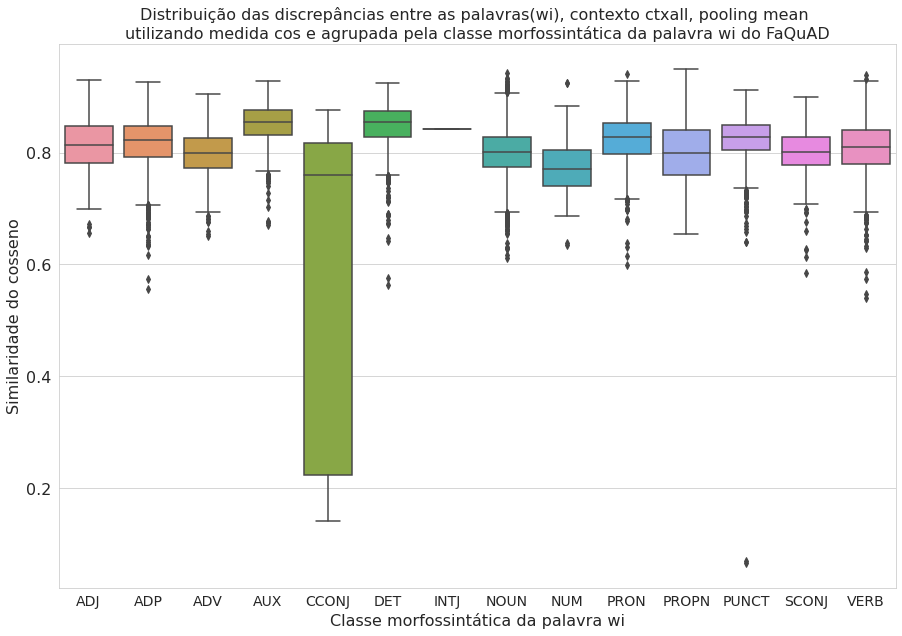

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1097.000000 0.788648 0.044912 0.596984 0.763652 0.793225 0.820163   
ADP   3170.000000 0.817182 0.043840 0.556775 0.791671 0.821958 0.848283   
ADV    417.000000 0.794425 0.044064 0.650445 0.771267 0.797661 0.823621   
AUX    904.000000 0.851905 0.036776 0.670497 0.831245 0.854677 0.875536   
CCONJ  133.000000 0.554965 0.293111 0.141648 0.222534 0.759909 0.817857   
DET   2427.000000 0.846068 0.038409 0.563480 0.824930 0.852831 0.872904   
INTJ     2.000000 0.841410 0.000000 0.841410 0.841410 0.841410 0.841410   
NOUN  4491.000000 0.787799 0.042474 0.611669 0.763845 0.791351 0.818002   
NUM     83.000000 0.742401 0.075100 0.489918 0.717879 0.752158 0.783902   
PRON  1633.000000 0.821893 0.041628 0.598486 0.797006 0.825552 0.850906   
PROPN  799.000000 0.749342 0.049507 0.528102 0.716060 0.752933 0.785379   
PUNCT 1866.000000 0.824643 0.045076 0.065848 0.804263 0.828553 0.849966   
SCONJ  432.000000 0.799467 0.042225 0.584943 0.778168 0.801584 0.827869   
VERB  2030.000000 0.793934 0.044791 0.539066 0.768272 0.797025 0.824037   

           max  
pos_i           
ADJ   0.910083  
ADP   0.926882  
ADV   0.893849  
AUX   0.928310  
CCONJ 0.876483  
DET   0.921000  
INTJ  0.841410  
NOUN  0.902142  
NUM   0.882978  
PRON  0.916563  
PROPN 0.894280  
PUNCT 0.911559  
SCONJ 0.899360  
VERB  0.906923

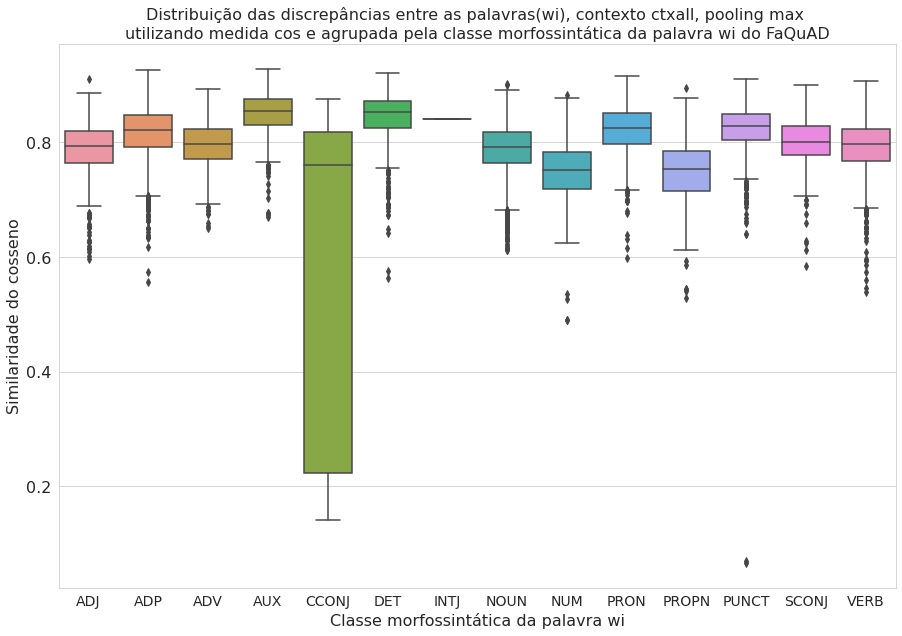

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1097.000000 22.877995 4.158938 12.266150 20.103525 22.999136 25.325178   
ADP   3170.000000 22.450611 3.051618 13.826190 20.394966 22.136566 24.090384   
ADV    417.000000 24.883467 3.731275 14.655649 22.236046 24.516970 27.223608   
AUX    904.000000 20.045086 2.779454 13.802571 18.253344 19.861135 21.670513   
CCONJ  133.000000 27.555527 6.059505 18.047207 21.818970 25.579899 33.927437   
DET   2427.000000 20.039819 2.612541 14.041231 18.291036 19.614542 21.515104   
INTJ     2.000000 20.755898 0.000000 20.755898 20.755898 20.755898 20.755898   
NOUN  4491.000000 23.211993 3.169754 11.380696 21.303830 23.036470 25.023160   
NUM     83.000000 26.040087 4.913584 12.023673 22.355802 26.753698 29.396729   
PRON  1633.000000 22.009899 2.960240 12.498813 20.065128 21.789957 23.707291   
PROPN  799.000000 22.154213 4.213940 11.003908 19.473188 22.332947 24.927898   
PUNCT 1866.000000 21.221565 2.759759 15.135784 19.664497 21.001560 22.439626   
SCONJ  432.000000 23.821761 2.827000 16.335728 21.912990 23.776222 25.600879   
VERB  2030.000000 24.089145 3.874788 11.439407 21.625501 24.009188 26.449080   

            max  
pos_i            
ADJ   40.175587  
ADP   38.786926  
ADV   41.998959  
AUX   31.886904  
CCONJ 36.011719  
DET   39.653755  
INTJ  20.755898  
NOUN  41.371395  
NUM   34.638588  
PRON  37.479225  
PROPN 39.002686  
PUNCT 43.372269  
SCONJ 35.341991  
VERB  41.847027

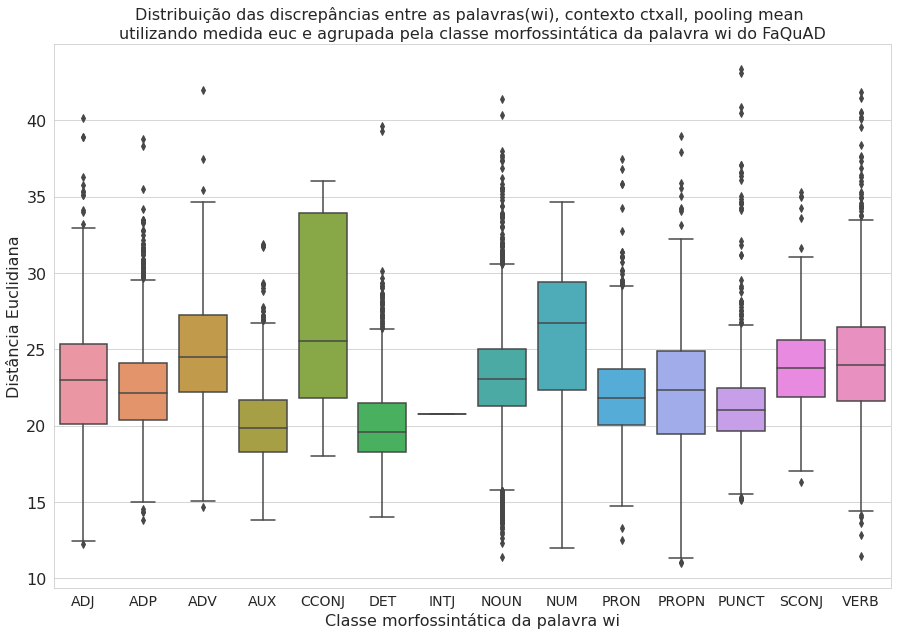

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1097.000000 24.679094 3.351256 16.396372 22.390406 24.165688 26.637775   
ADP   3170.000000 22.450611 3.051618 13.826190 20.394966 22.136566 24.090384   
ADV    417.000000 25.035420 3.579817 17.539572 22.527082 24.596743 27.223608   
AUX    904.000000 20.045086 2.779454 13.802571 18.253344 19.861135 21.670513   
CCONJ  133.000000 27.820776 6.167438 18.047207 22.064198 26.845734 34.015987   
DET   2427.000000 20.236910 2.681537 14.041231 18.415549 19.790110 21.910246   
INTJ     2.000000 20.755898 0.000000 20.755898 20.755898 20.755898 20.755898   
NOUN  4491.000000 24.011409 2.885353 16.334976 22.043654 23.738420 25.628960   
NUM     83.000000 28.574852 5.281745 17.487141 25.909524 28.007341 31.291804   
PRON  1633.000000 22.086798 2.940195 14.769711 20.102461 21.868151 23.802406   
PROPN  799.000000 25.781295 3.176639 19.133038 23.554811 25.444410 27.465319   
PUNCT 1866.000000 21.221565 2.759759 15.135784 19.664497 21.001560 22.439626   
SCONJ  432.000000 23.821761 2.827000 16.335728 21.912990 23.776222 25.600879   
VERB  2030.000000 25.171178 3.400965 16.289457 22.833166 24.919869 27.143982   

            max  
pos_i            
ADJ   40.175587  
ADP   38.786926  
ADV   41.998959  
AUX   31.886904  
CCONJ 39.050915  
DET   39.653755  
INTJ  20.755898  
NOUN  41.371395  
NUM   44.610634  
PRON  37.479225  
PROPN 39.040554  
PUNCT 43.372269  
SCONJ 35.341991  
VERB  41.847027

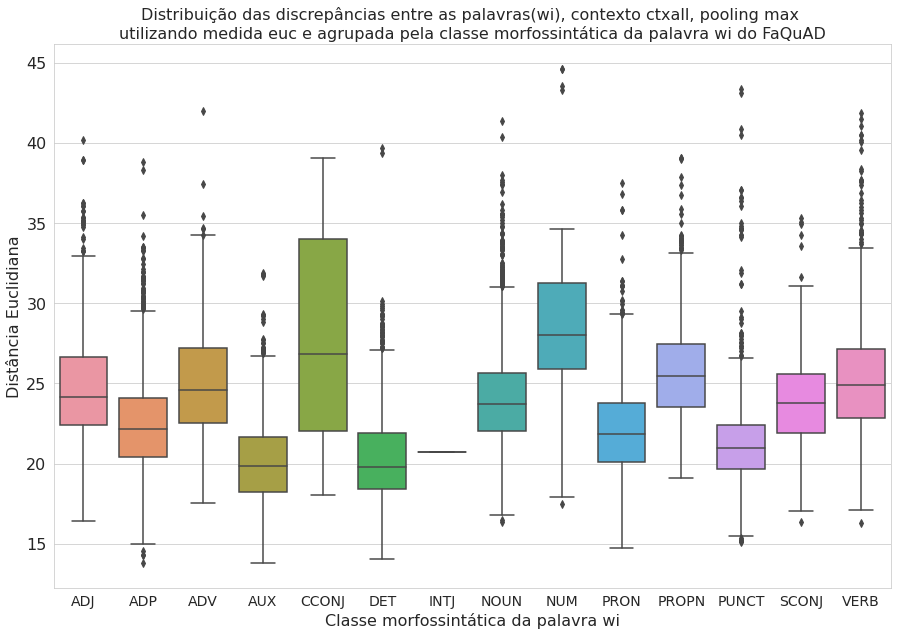

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1097.000000 1081.383259 185.535367  562.979430  954.346400 1094.009800   
ADP   3170.000000 1105.596854 149.577631  670.707460 1005.715575 1089.845250   
ADV    417.000000 1203.814346 170.685559  658.352900 1087.253000 1192.927400   
AUX    904.000000  974.926730 137.977809  662.937000  885.360905  967.789520   
CCONJ  133.000000 1106.692527 106.535591  883.885600 1054.659700 1097.280800   
DET   2427.000000  984.995418 128.893410  684.856260  897.508500  966.137760   
INTJ     2.000000 1010.784900   0.000000 1010.784900 1010.784900 1010.784900   
NOUN  4491.000000 1097.051105 142.993978  545.380860 1010.102785 1089.222000   
NUM     83.000000 1241.586924 216.373556  583.081000 1110.791550 1286.697000   
PRON  1633.000000 1082.808906 148.641444  601.046000  984.968500 1075.385400   
PROPN  799.000000 1047.743188 192.174328  531.921000  928.639830 1058.015600   
PUNCT 1866.000000 1050.086552 123.999338  731.404700  973.594425 1044.117250   
SCONJ  432.000000 1175.771459 142.014646  802.930050 1079.868150 1174.465100   
VERB  2030.000000 1156.557244 176.752080  546.874760 1048.039500 1151.918350   

              75%         max  
pos_i                          
ADJ   1197.733200 1650.674300  
ADP   1185.587475 1923.836200  
ADV   1309.059000 1795.792000  
AUX   1056.018600 1576.014600  
CCONJ 1142.542100 1507.446300  
DET   1062.040800 1970.572300  
INTJ  1010.784900 1010.784900  
NOUN  1181.027100 1802.809400  
NUM   1364.292500 1674.458000  
PRON  1173.749000 1865.322500  
PROPN 1170.445100 1725.087200  
PUNCT 1120.328100 1736.348100  
SCONJ 1267.232150 1740.684300  
VERB  1272.766575 2096.301800

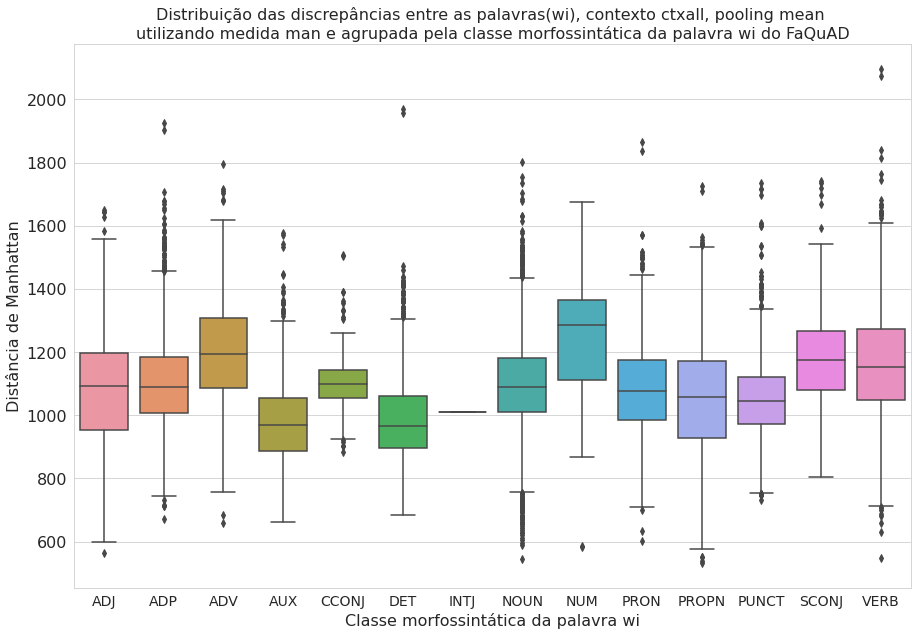

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1097.000000 1167.225757 150.585436  795.790300 1059.341600 1144.478000   
ADP   3170.000000 1105.596854 149.577631  670.707460 1005.715575 1089.845250   
ADV    417.000000 1211.515879 162.216163  863.057600 1096.659400 1198.579000   
AUX    904.000000  974.926730 137.977809  662.937000  885.360905  967.789520   
CCONJ  133.000000 1118.300599 125.913668  883.885600 1058.429600 1098.747300   
DET   2427.000000  994.319246 131.515932  684.856260  903.483930  976.919300   
INTJ     2.000000 1010.784900   0.000000 1010.784900 1010.784900 1010.784900   
NOUN  4491.000000 1135.393263 133.091098  790.062130 1042.061200 1121.352700   
NUM     83.000000 1371.982024 277.623682  882.931000 1223.961550 1335.216300   
PRON  1633.000000 1086.119129 147.448523  698.587800  991.239800 1077.226300   
PROPN  799.000000 1228.690666 161.346996  878.958600 1120.196550 1212.335400   
PUNCT 1866.000000 1050.086552 123.999338  731.404700  973.594425 1044.117250   
SCONJ  432.000000 1175.771459 142.014646  802.930050 1079.868150 1174.465100   
VERB  2030.000000 1209.157486 157.132838  790.707300 1101.147600 1198.179200   

              75%         max  
pos_i                          
ADJ   1251.437300 1836.660600  
ADP   1185.587475 1923.836200  
ADV   1309.887600 1795.792000  
AUX   1056.018600 1576.014600  
CCONJ 1145.090300 1699.366000  
DET   1075.157800 1970.572300  
INTJ  1010.784900 1010.784900  
NOUN  1210.122300 1802.809400  
NUM   1475.832650 2355.653300  
PRON  1177.823700 1865.322500  
PROPN 1308.033750 1878.586200  
PUNCT 1120.328100 1736.348100  
SCONJ 1267.232150 1740.684300  
VERB  1303.020575 2123.833000

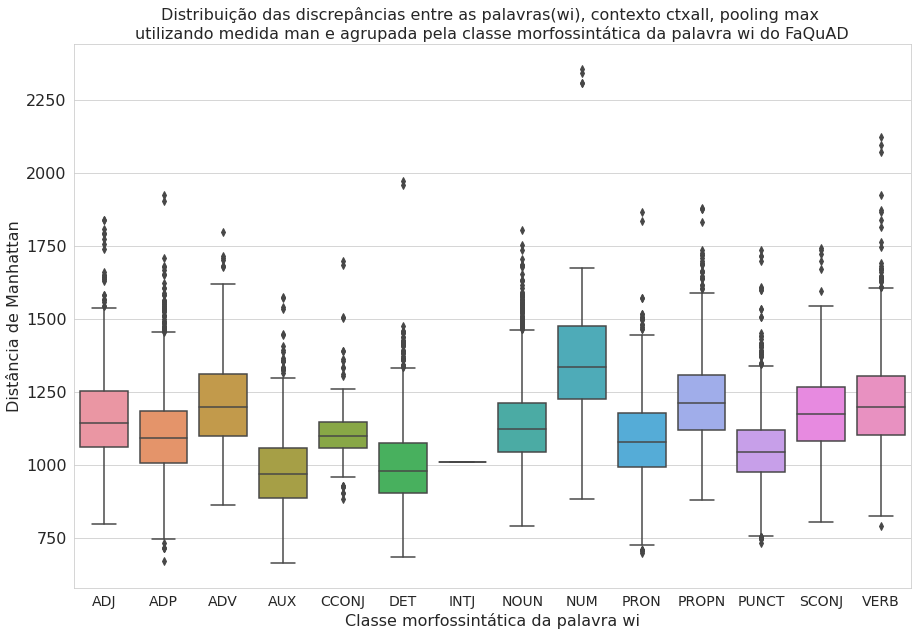

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [ ]:
equacao_medida = "ctxclean"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1097.000000 0.832978 0.047084 0.595275 0.810357 0.840453 0.864181   
ADP   3170.000000 0.756420 0.048622 0.490508 0.729358 0.761812 0.790674   
ADV    417.000000 0.756502 0.057375 0.614339 0.723640 0.753720 0.789553   
AUX    904.000000 0.783281 0.041533 0.630779 0.757500 0.784768 0.810121   
CCONJ  133.000000 0.498066 0.287745 0.097799 0.165232 0.695410 0.753534   
DET   2427.000000 0.784701 0.041349 0.546662 0.759365 0.788658 0.814392   
INTJ     2.000000 0.766589 0.000000 0.766589 0.766589 0.766589 0.766589   
NOUN  4491.000000 0.826021 0.046443 0.577471 0.801362 0.831467 0.858462   
NUM     83.000000 0.782642 0.055009 0.632085 0.750221 0.785189 0.823057   
PRON  1633.000000 0.743223 0.041563 0.534108 0.717846 0.747577 0.772760   
PROPN  799.000000 0.818278 0.052515 0.651761 0.783590 0.819537 0.855451   
PUNCT 1866.000000 0.818195 0.050742 0.090934 0.791823 0.818814 0.844908   
SCONJ  432.000000 0.734137 0.049089 0.516473 0.706127 0.733633 0.766523   
VERB  2030.000000 0.808555 0.053060 0.508645 0.776866 0.813965 0.846238   

           max  
pos_i           
ADJ   0.950571  
ADP   0.874897  
ADV   0.909024  
AUX   0.901563  
CCONJ 0.796547  
DET   0.928719  
INTJ  0.766589  
NOUN  0.947550  
NUM   0.865661  
PRON  0.848479  
PROPN 0.950515  
PUNCT 1.000000  
SCONJ 0.844304  
VERB  0.928156

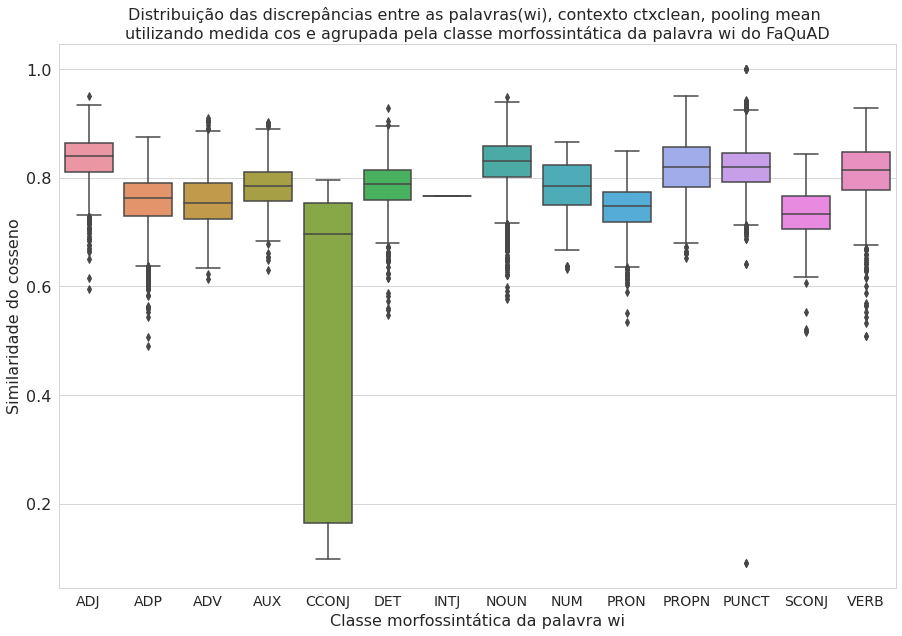

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1097.000000 0.806853 0.058972 0.565427 0.770990 0.815757 0.848963   
ADP   3170.000000 0.756420 0.048622 0.490508 0.729358 0.761812 0.790674   
ADV    417.000000 0.754396 0.055027 0.614339 0.723640 0.752754 0.783216   
AUX    904.000000 0.783281 0.041533 0.630779 0.757500 0.784768 0.810121   
CCONJ  133.000000 0.493383 0.287597 0.097799 0.165232 0.695410 0.753534   
DET   2427.000000 0.782090 0.041091 0.546662 0.757489 0.786473 0.812001   
INTJ     2.000000 0.766589 0.000000 0.766589 0.766589 0.766589 0.766589   
NOUN  4491.000000 0.814516 0.054917 0.577471 0.785147 0.823971 0.853456   
NUM     83.000000 0.751492 0.090053 0.463293 0.729114 0.778099 0.810679   
PRON  1633.000000 0.742254 0.041562 0.534108 0.716968 0.746897 0.771661   
PROPN  799.000000 0.765903 0.069740 0.488019 0.719841 0.769488 0.818674   
PUNCT 1866.000000 0.818195 0.050742 0.090934 0.791823 0.818814 0.844908   
SCONJ  432.000000 0.734137 0.049089 0.516473 0.706127 0.733633 0.766523   
VERB  2030.000000 0.794152 0.055498 0.508645 0.760628 0.798898 0.834047   

           max  
pos_i           
ADJ   0.950571  
ADP   0.874897  
ADV   0.909024  
AUX   0.901563  
CCONJ 0.796547  
DET   0.897384  
INTJ  0.766589  
NOUN  0.947550  
NUM   0.865661  
PRON  0.848479  
PROPN 0.950515  
PUNCT 1.000000  
SCONJ 0.844304  
VERB  0.928156

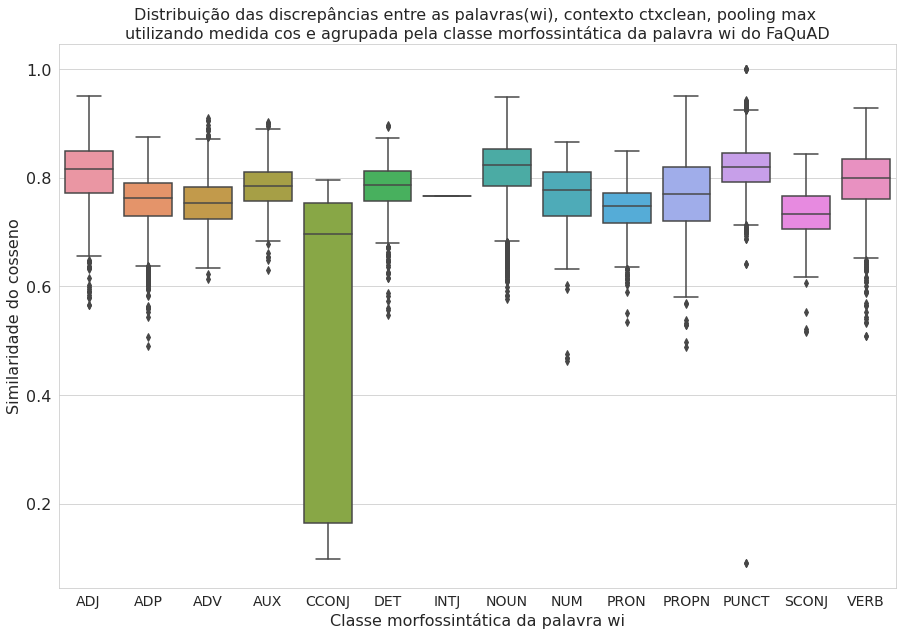

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1097.000000 21.797297 3.852266 12.506747 19.088041 21.388073 24.071512   
ADP   3170.000000 25.627815 2.930316 17.508099 23.654201 25.308575 27.127378   
ADV    417.000000 26.867417 3.388395 14.735398 24.875025 26.806547 28.759628   
AUX    904.000000 23.941910 2.483432 15.841943 22.374454 23.934771 25.439590   
CCONJ  133.000000 30.700833 5.725179 22.636559 25.423666 28.086103 36.867222   
DET   2427.000000 23.650898 2.430022 13.549007 21.950120 23.447512 25.128427   
INTJ     2.000000 24.891756 0.000000 24.891756 24.891756 24.891756 24.891756   
NOUN  4491.000000 21.720722 3.308261 12.273237 19.556680 21.374775 23.476480   
NUM     83.000000 25.647969 3.703810 18.519711 22.913236 25.033346 28.078592   
PRON  1633.000000 26.255000 2.450790 19.506306 24.527325 26.103443 27.738163   
PROPN  799.000000 21.329439 3.578561 12.614815 19.275565 21.353251 23.357200   
PUNCT 1866.000000 21.540364 3.234084  0.000000 20.036829 21.664781 23.229146   
SCONJ  432.000000 27.113133 2.773205 20.170033 25.274375 27.235436 28.890318   
VERB  2030.000000 24.014782 3.591461 14.396695 21.589018 24.083946 26.114501   

            max  
pos_i            
ADJ   37.081745  
ADP   41.011265  
ADV   39.329906  
AUX   32.556019  
CCONJ 38.969032  
DET   40.233822  
INTJ  24.891756  
NOUN  38.564785  
NUM   33.368782  
PRON  39.723881  
PROPN 36.935345  
PUNCT 41.346760  
SCONJ 39.077946  
VERB  41.019470

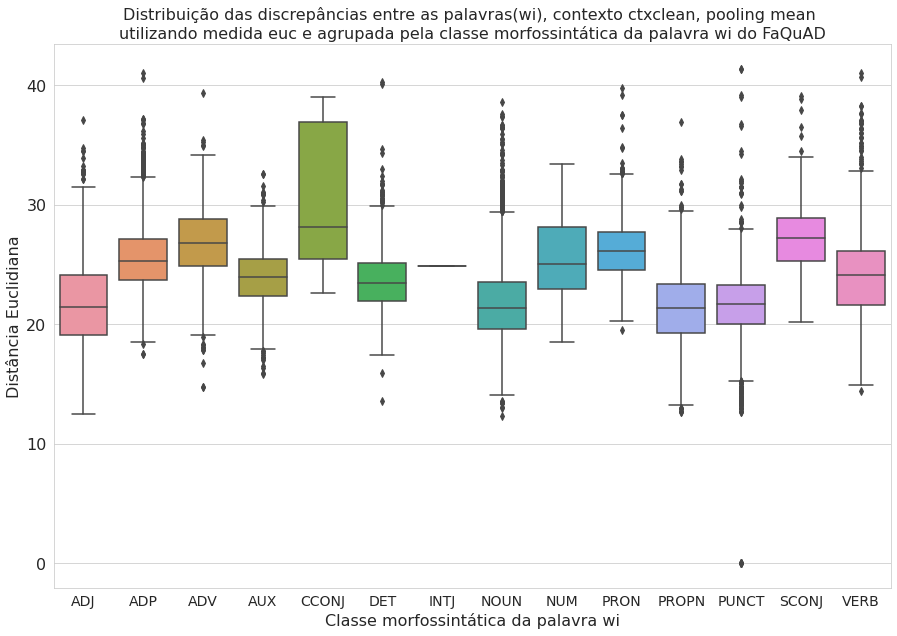

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1097.000000 23.603532 3.765111 12.506747 21.124199 23.298725 25.637659   
ADP   3170.000000 25.627815 2.930316 17.508099 23.654201 25.308575 27.127378   
ADV    417.000000 27.016119 3.157513 16.715555 24.951496 26.836245 28.759628   
AUX    904.000000 23.941910 2.483432 15.841943 22.374454 23.934771 25.439590   
CCONJ  133.000000 30.953919 5.762863 22.636559 25.560137 28.742865 36.876183   
DET   2427.000000 23.831526 2.407362 16.611156 22.137877 23.640902 25.281003   
INTJ     2.000000 24.891756 0.000000 24.891756 24.891756 24.891756 24.891756   
NOUN  4491.000000 22.509644 3.556362 12.273237 20.078531 22.067444 24.497017   
NUM     83.000000 28.040577 5.284831 21.144985 24.434998 26.850166 29.926703   
PRON  1633.000000 26.320316 2.440090 19.506306 24.559765 26.148886 27.816719   
PROPN  799.000000 24.886235 4.092082 15.133454 21.927508 24.675468 27.283607   
PUNCT 1866.000000 21.540364 3.234084  0.000000 20.036829 21.664781 23.229146   
SCONJ  432.000000 27.113133 2.773205 20.170033 25.274375 27.235436 28.890318   
VERB  2030.000000 25.076496 3.369728 15.135900 23.010351 24.900990 26.902776   

            max  
pos_i            
ADJ   37.794750  
ADP   41.011265  
ADV   39.329906  
AUX   32.556019  
CCONJ 40.161556  
DET   40.233822  
INTJ  24.891756  
NOUN  38.564785  
NUM   45.882721  
PRON  39.723881  
PROPN 39.749187  
PUNCT 41.346760  
SCONJ 39.077946  
VERB  41.765808

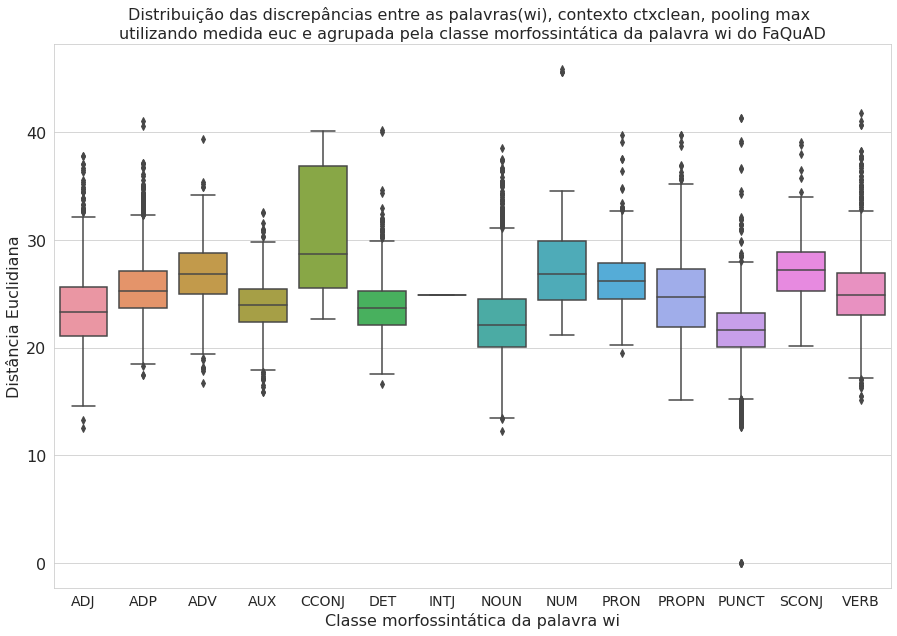

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1097.000000 1030.852160 178.187578  598.419800  901.715640 1015.585700   
ADP   3170.000000 1253.791540 144.733819  873.548200 1155.661725 1235.012600   
ADV    417.000000 1298.927879 167.440173  717.304100 1201.345800 1297.987200   
AUX    904.000000 1154.682954 119.942273  775.562900 1078.763000 1148.753850   
CCONJ  133.000000 1232.700904  97.503831 1003.795500 1170.964100 1215.265300   
DET   2427.000000 1151.875024 116.996175  640.704160 1070.517150 1141.463000   
INTJ     2.000000 1202.241000   0.000000 1202.241000 1202.241000 1202.241000   
NOUN  4491.000000 1029.586626 153.835969  599.121640  928.483585 1010.660900   
NUM     83.000000 1225.708240 176.779157  875.102400 1093.572050 1201.987500   
PRON  1633.000000 1281.619273 123.633351  931.603640 1193.798800 1274.439600   
PROPN  799.000000 1010.715214 164.191382  612.919800  914.379265 1010.416200   
PUNCT 1866.000000 1055.136979 153.752917    0.000000  982.895300 1064.447100   
SCONJ  432.000000 1330.454058 139.504323  988.990660 1241.346675 1328.907300   
VERB  2030.000000 1152.353868 170.211290  701.138800 1034.169650 1151.318900   

              75%         max  
pos_i                          
ADJ   1138.289100 1665.026700  
ADP   1327.520650 2022.175800  
ADV   1399.880400 1750.353500  
AUX   1229.579500 1610.165300  
CCONJ 1269.339400 1582.580700  
DET   1223.017200 1983.860100  
INTJ  1202.241000 1202.241000  
NOUN  1112.478600 1795.649400  
NUM   1345.997200 1616.053800  
PRON  1361.167700 1958.045900  
PROPN 1098.784900 1643.934700  
PUNCT 1143.836175 1663.805200  
SCONJ 1421.622100 1935.035400  
VERB  1255.178200 2052.186800

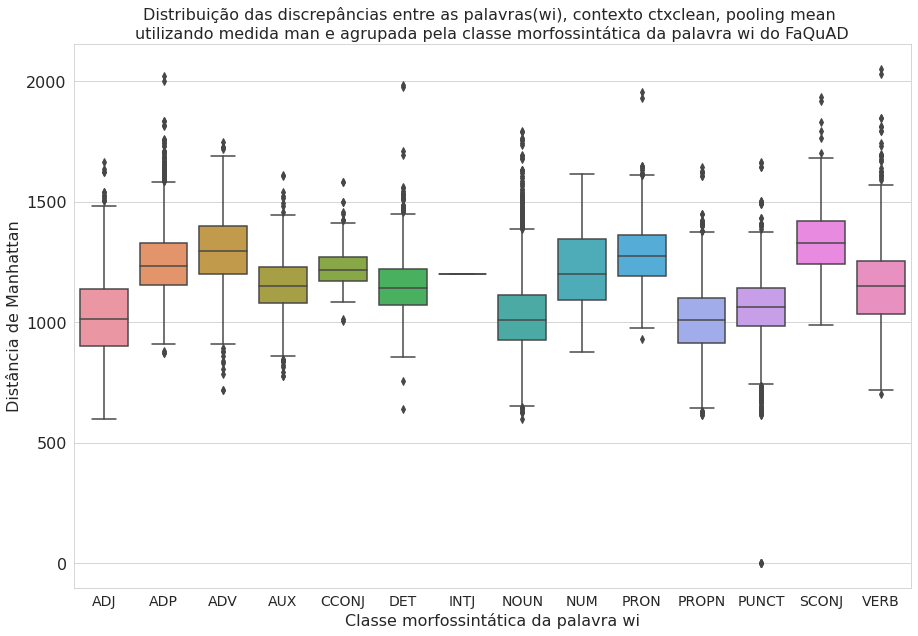

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1097.000000 1115.516053 176.567125  613.251400 1004.642760 1099.455900   
ADP   3170.000000 1253.791540 144.733819  873.548200 1155.661725 1235.012600   
ADV    417.000000 1306.460903 155.763729  787.253900 1202.149200 1302.513100   
AUX    904.000000 1154.682954 119.942273  775.562900 1078.763000 1148.753850   
CCONJ  133.000000 1243.577358 111.372854 1084.424000 1174.161700 1217.832300   
DET   2427.000000 1160.388053 115.000252  792.279100 1079.158800 1149.756300   
INTJ     2.000000 1202.241000   0.000000 1202.241000 1202.241000 1202.241000   
NOUN  4491.000000 1066.782767 167.741339  599.121640  950.002700 1042.219200   
NUM     83.000000 1348.702651 282.819828 1009.924130 1173.122800 1290.118300   
PRON  1633.000000 1284.364375 122.651085  931.603640 1195.699000 1276.493200   
PROPN  799.000000 1184.917446 204.713407  702.643900 1040.566150 1169.521700   
PUNCT 1866.000000 1055.136979 153.752917    0.000000  982.895300 1064.447100   
SCONJ  432.000000 1330.454058 139.504323  988.990660 1241.346675 1328.907300   
VERB  2030.000000 1203.341596 163.169418  728.473450 1102.439475 1196.028100   

              75%         max  
pos_i                          
ADJ   1212.311500 1901.692300  
ADP   1327.520650 2022.175800  
ADV   1399.880400 1750.353500  
AUX   1229.579500 1610.165300  
CCONJ 1280.162500 1742.060800  
DET   1230.332050 1983.860100  
INTJ  1202.241000 1202.241000  
NOUN  1163.840700 1795.649400  
NUM   1430.525200 2389.520500  
PRON  1363.572500 1958.045900  
PROPN 1300.878600 1930.331300  
PUNCT 1143.836175 1663.805200  
SCONJ 1421.622100 1935.035400  
VERB  1293.983025 2148.943000

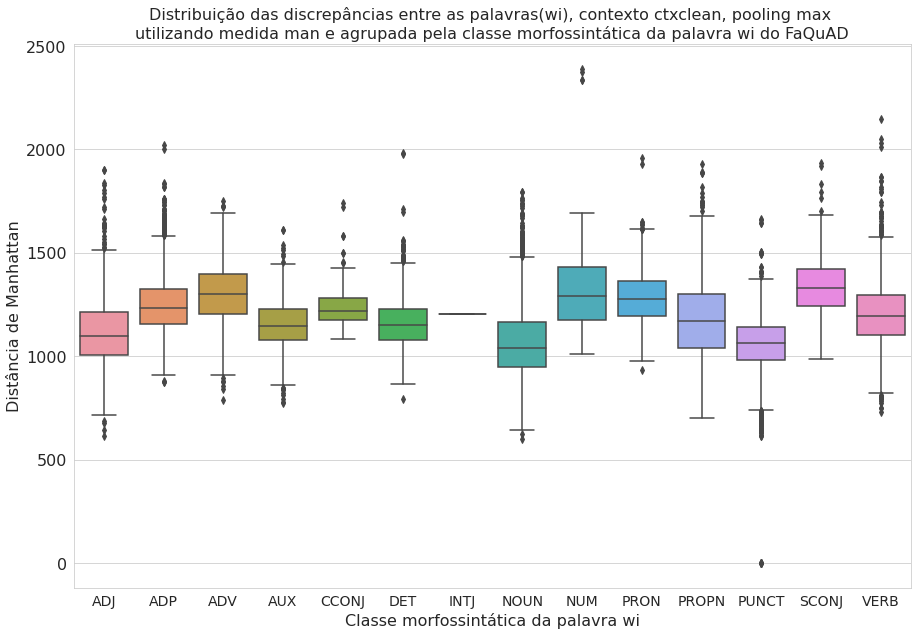

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [ ]:
equacao_medida = "ctxverb"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ    949.000000 0.661576 0.070842 0.473259 0.609072 0.659020 0.714765   
ADP   2867.000000 0.654019 0.075658 0.385327 0.606613 0.658357 0.709955   
ADV    406.000000 0.724368 0.059875 0.539334 0.687826 0.730457 0.771671   
AUX    904.000000 0.933119 0.055097 0.729218 0.895488 0.922989 1.000000   
CCONJ  127.000000 0.426372 0.275833 0.050180 0.116941 0.577093 0.668216   
DET   2153.000000 0.723449 0.069893 0.437009 0.676861 0.726474 0.774660   
INTJ     0.000000      NaN      NaN      NaN      NaN      NaN      NaN   
NOUN  4053.000000 0.643465 0.069186 0.387621 0.595422 0.646098 0.693847   
NUM     82.000000 0.628522 0.055781 0.526766 0.583847 0.627629 0.660595   
PRON  1551.000000 0.718931 0.061070 0.487405 0.678055 0.720315 0.764953   
PROPN  751.000000 0.605524 0.075405 0.409724 0.554777 0.607504 0.658596   
PUNCT 1698.000000 0.703594 0.064272 0.032986 0.664967 0.715466 0.747618   
SCONJ  423.000000 0.712773 0.064145 0.484276 0.669182 0.717142 0.761030   
VERB  2030.000000 0.918171 0.058822 0.626744 0.879928 0.918653 0.946714   

           max  
pos_i           
ADJ   0.857933  
ADP   0.837969  
ADV   0.866467  
AUX   1.000000  
CCONJ 0.781156  
DET   0.890831  
INTJ       NaN  
NOUN  0.825155  
NUM   0.798906  
PRON  0.868897  
PROPN 0.782765  
PUNCT 0.823296  
SCONJ 0.869758  
VERB  1.000000

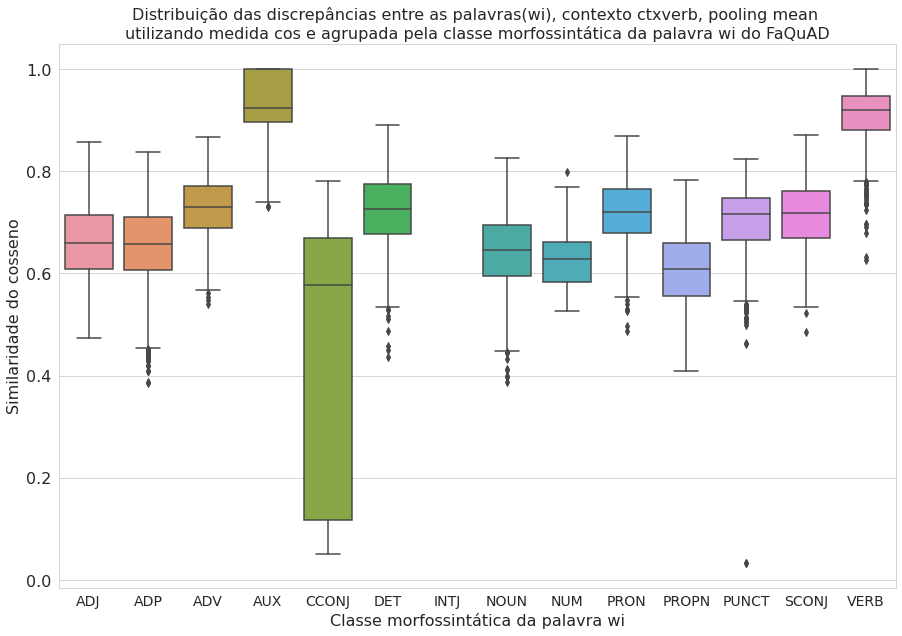

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ    949.000000 0.641199 0.079783 0.370270 0.585667 0.642185 0.699909   
ADP   2867.000000 0.654019 0.075658 0.385327 0.606613 0.658357 0.709955   
ADV    406.000000 0.722959 0.061763 0.539334 0.686485 0.730457 0.771671   
AUX    904.000000 0.933119 0.055097 0.729218 0.895488 0.922989 1.000000   
CCONJ  127.000000 0.421620 0.275229 0.050180 0.116941 0.564236 0.668216   
DET   2153.000000 0.721061 0.070438 0.437009 0.674070 0.723626 0.773259   
INTJ     0.000000      NaN      NaN      NaN      NaN      NaN      NaN   
NOUN  4053.000000 0.633954 0.071970 0.387621 0.582744 0.637328 0.686874   
NUM     82.000000 0.602681 0.086358 0.356551 0.559480 0.610104 0.660396   
PRON  1551.000000 0.718002 0.060859 0.487405 0.676493 0.719794 0.764745   
PROPN  751.000000 0.563809 0.074573 0.370552 0.513260 0.570170 0.618816   
PUNCT 1698.000000 0.703594 0.064272 0.032986 0.664967 0.715466 0.747618   
SCONJ  423.000000 0.712773 0.064145 0.484276 0.669182 0.717142 0.761030   
VERB  2030.000000 0.903505 0.070988 0.546779 0.866038 0.912133 0.939424   

           max  
pos_i           
ADJ   0.849664  
ADP   0.837969  
ADV   0.866467  
AUX   1.000000  
CCONJ 0.781156  
DET   0.890831  
INTJ       NaN  
NOUN  0.825155  
NUM   0.798906  
PRON  0.868897  
PROPN 0.751667  
PUNCT 0.823296  
SCONJ 0.869758  
VERB  1.000000

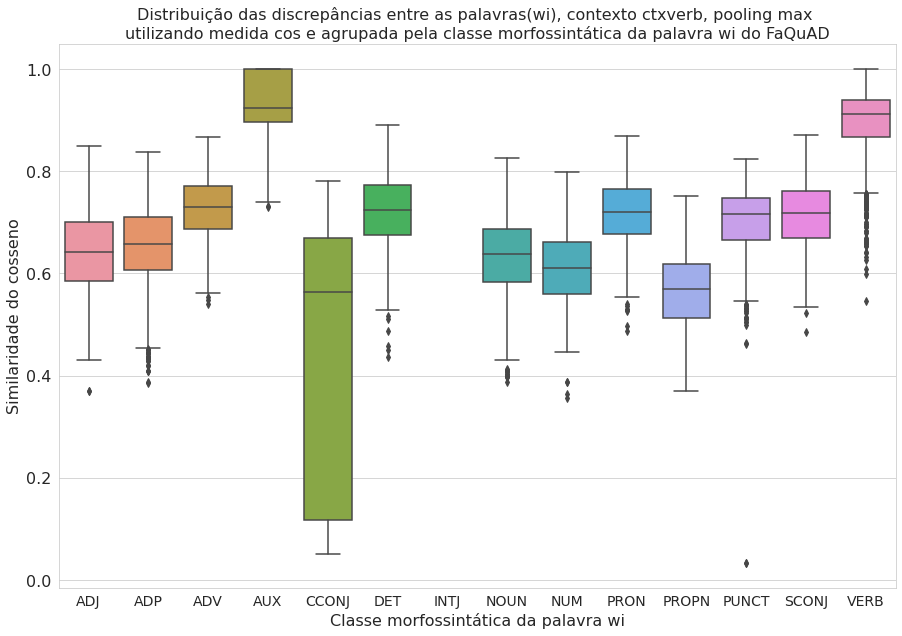

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ    949.000000 31.952066 4.171569 20.052076 29.017319 31.913668 34.722931   
ADP   2867.000000 32.225145 4.305144 21.028620 29.188417 31.933140 34.791756   
ADV    406.000000 29.518887 4.359623 20.386522 26.219331 28.923495 32.551796   
AUX    904.000000 11.178243 8.291666  0.000000  0.000000 14.871537 17.171801   
CCONJ  127.000000 36.492619 6.946014 23.956995 30.124535 36.060108 42.460112   
DET   2153.000000 28.337644 4.491397 17.231613 25.081615 27.993504 31.240421   
INTJ     0.000000       NaN      NaN       NaN       NaN       NaN       NaN   
NOUN  4053.000000 32.517560 4.061905 21.070621 29.623922 32.276436 35.059002   
NUM     82.000000 34.745793 3.717128 22.895027 32.470872 34.273954 37.653844   
PRON  1551.000000 28.850899 4.108733 18.917839 25.727776 28.699093 31.497779   
PROPN  751.000000 33.618605 4.180710 23.014595 30.760416 33.612888 36.443768   
PUNCT 1698.000000 29.172688 4.035196 21.972168 26.220039 28.328070 31.437829   
SCONJ  423.000000 29.247713 4.003779 18.909821 26.380250 28.888344 31.723665   
VERB  2030.000000 13.905131 8.258279  0.000000 12.676439 16.286005 19.302178   

            max  
pos_i            
ADJ   46.776455  
ADP   50.578110  
ADV   42.571362  
AUX   29.411528  
CCONJ 53.025936  
DET   46.666256  
INTJ        NaN  
NOUN  50.967281  
NUM   42.326515  
PRON  43.353962  
PROPN 47.838364  
PUNCT 44.580868  
SCONJ 44.035061  
VERB  38.669708

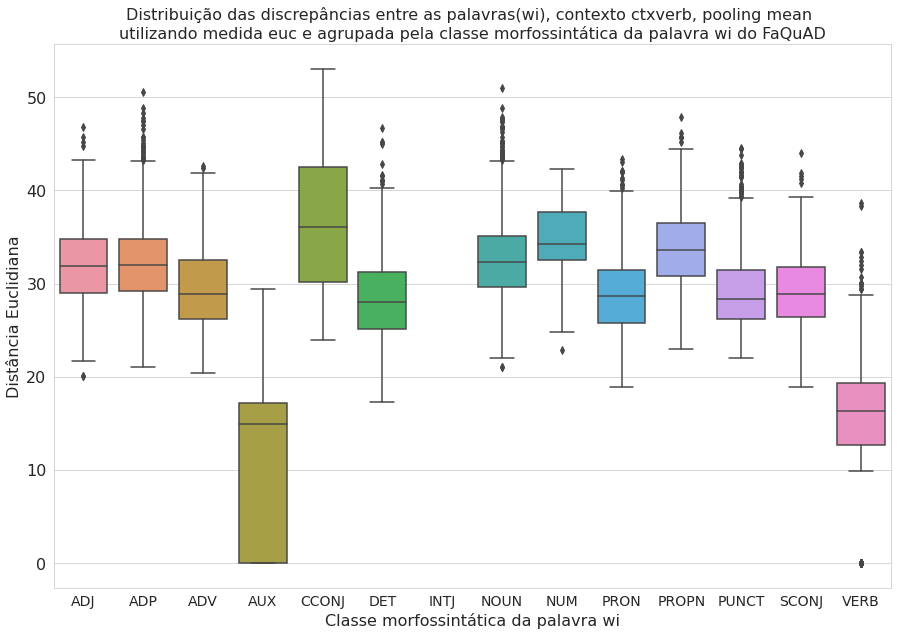

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ    949.000000 33.175208 4.244242 21.820919 30.315430 33.017605 36.010502   
ADP   2867.000000 32.225145 4.305144 21.028620 29.188417 31.933140 34.791756   
ADV    406.000000 29.601794 4.418479 20.386522 26.231268 29.005716 32.620989   
AUX    904.000000 11.178243 8.291666  0.000000  0.000000 14.871537 17.171801   
CCONJ  127.000000 36.740847 6.900783 23.956995 31.033578 36.384464 42.494755   
DET   2153.000000 28.488896 4.520363 17.231613 25.259470 28.107698 31.447557   
INTJ     0.000000       NaN      NaN       NaN       NaN       NaN       NaN   
NOUN  4053.000000 33.091396 4.069833 22.208706 30.278234 32.895458 35.749149   
NUM     82.000000 36.639317 5.198363 22.895027 33.259341 36.501902 38.974068   
PRON  1551.000000 28.914405 4.081964 18.917839 25.737205 28.738138 31.583554   
PROPN  751.000000 36.095783 4.122427 25.496618 33.101185 35.904079 38.494987   
PUNCT 1698.000000 29.172688 4.035196 21.972168 26.220039 28.328070 31.437829   
SCONJ  423.000000 29.247713 4.003779 18.909821 26.380250 28.888344 31.723665   
VERB  2030.000000 15.474836 8.510497  0.000000 13.975241 16.923749 20.929525   

            max  
pos_i            
ADJ   48.215569  
ADP   50.578110  
ADV   42.571362  
AUX   29.411528  
CCONJ 53.025936  
DET   46.666256  
INTJ        NaN  
NOUN  50.967281  
NUM   51.522079  
PRON  43.353962  
PROPN 49.000332  
PUNCT 44.580868  
SCONJ 44.035061  
VERB  41.658283

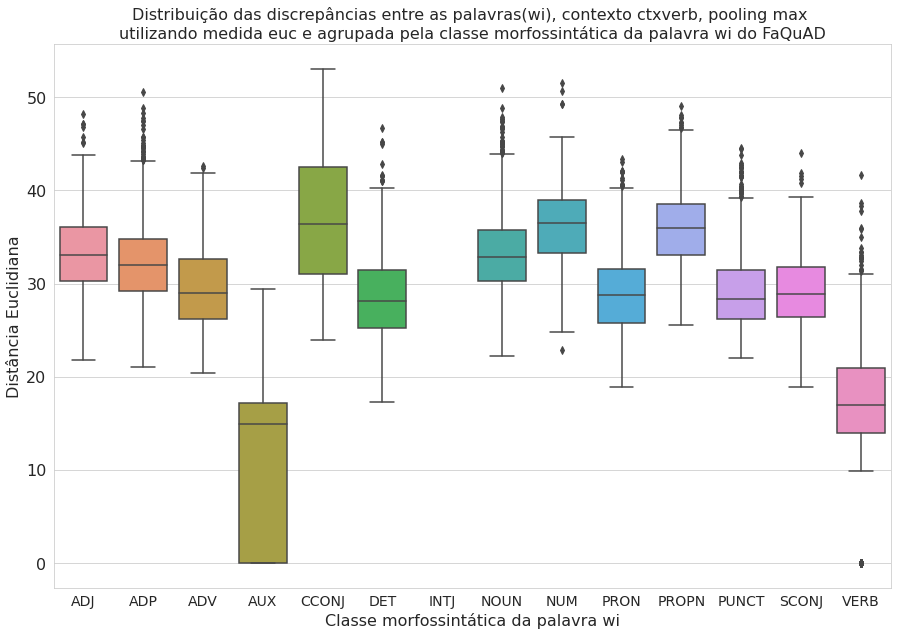

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ    949.000000 1522.354638 189.082894  976.753784 1392.040283 1526.834229   
ADP   2867.000000 1574.679224 195.519469 1027.001343 1434.930664 1563.812988   
ADV    406.000000 1433.076872 205.003028  994.830078 1274.991821 1406.194702   
AUX    904.000000  538.782476 399.752157    0.000000    0.000000  719.296570   
CCONJ  127.000000 1550.084494 175.895456 1163.411865 1424.874146 1568.944336   
DET   2153.000000 1383.129750 209.038667  839.918701 1232.517578 1375.317871   
INTJ     0.000000         NaN        NaN         NaN         NaN         NaN   
NOUN  4053.000000 1545.522578 184.491885 1010.455994 1419.823120 1540.080688   
NUM     82.000000 1670.847260 168.171285 1118.581787 1569.278076 1660.794128   
PRON  1551.000000 1406.363816 194.851404  887.338440 1257.968628 1399.520020   
PROPN  751.000000 1597.368063 191.167118 1102.573364 1468.759766 1603.777344   
PUNCT 1698.000000 1429.127337 180.784391 1091.821777 1295.561798 1398.831299   
SCONJ  423.000000 1431.050146 192.329264  929.643494 1293.016968 1418.707275   
VERB  2030.000000  670.062459 398.052768    0.000000  615.228943  780.261597   

              75%         max  
pos_i                          
ADJ   1657.346802 2038.015869  
ADP   1700.757690 2215.054199  
ADV   1562.448242 2084.447510  
AUX    824.231934 1445.671875  
CCONJ 1659.829895 1966.840332  
DET   1520.564453 2180.291992  
INTJ          NaN         NaN  
NOUN  1668.983398 2227.109619  
NUM   1814.996307 2004.097168  
PRON  1537.708984 2051.021973  
PROPN 1731.544617 2238.714355  
PUNCT 1542.729584 2041.574219  
SCONJ 1544.354797 2050.023926  
VERB   934.008011 1946.588623

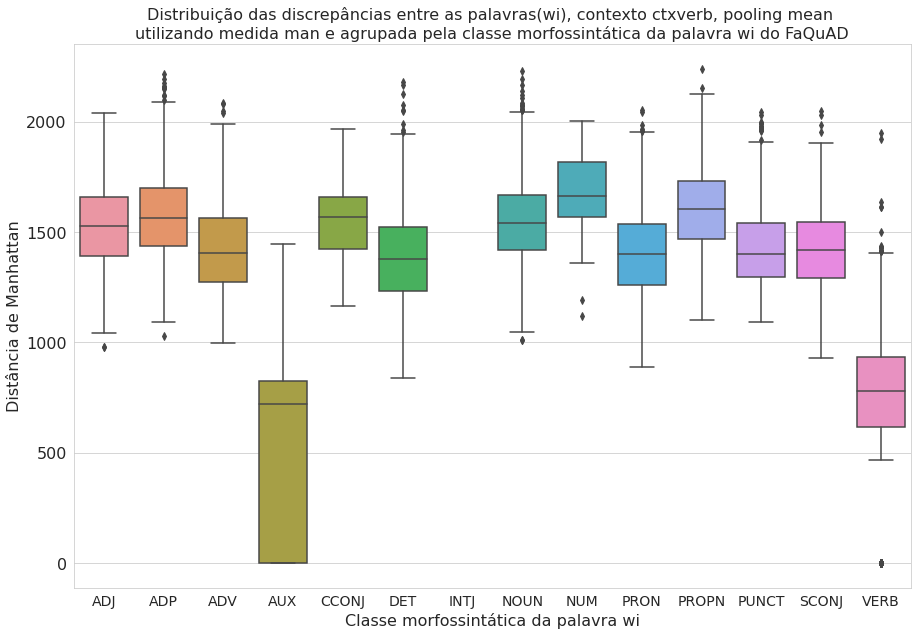

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ    949.000000 1579.590240 194.520244 1041.799561 1454.497559 1575.909912   
ADP   2867.000000 1574.679224 195.519469 1027.001343 1434.930664 1563.812988   
ADV    406.000000 1437.091366 207.884703  994.830078 1275.047089 1410.867188   
AUX    904.000000  538.782476 399.752157    0.000000    0.000000  719.296570   
CCONJ  127.000000 1560.410984 173.703444 1168.406982 1427.540283 1575.891846   
DET   2153.000000 1390.120527 209.933922  839.918701 1238.089600 1380.254761   
INTJ     0.000000         NaN        NaN         NaN         NaN         NaN   
NOUN  4053.000000 1572.410942 186.459184 1048.865356 1439.095215 1568.671387   
NUM     82.000000 1765.147586 254.003633 1118.581787 1596.704987 1730.559448   
PRON  1551.000000 1409.132872 193.377352  887.338440 1258.546936 1402.393799   
PROPN  751.000000 1717.112984 193.554113 1182.005493 1577.937256 1702.468994   
PUNCT 1698.000000 1429.127337 180.784391 1091.821777 1295.561798 1398.831299   
SCONJ  423.000000 1431.050146 192.329264  929.643494 1293.016968 1418.707275   
VERB  2030.000000  746.659517 412.027770    0.000000  676.092667  815.029572   

              75%         max  
pos_i                          
ADJ   1703.501709 2323.440918  
ADP   1700.757690 2215.054199  
ADV   1570.381104 2084.447510  
AUX    824.231934 1445.671875  
CCONJ 1663.061340 1966.840332  
DET   1531.125732 2180.291992  
INTJ          NaN         NaN  
NOUN  1701.798096 2227.109619  
NUM   1897.804260 2580.427734  
PRON  1540.665283 2051.021973  
PROPN 1828.691101 2292.497803  
PUNCT 1542.729584 2041.574219  
SCONJ 1544.354797 2050.023926  
VERB  1004.876511 2155.059082

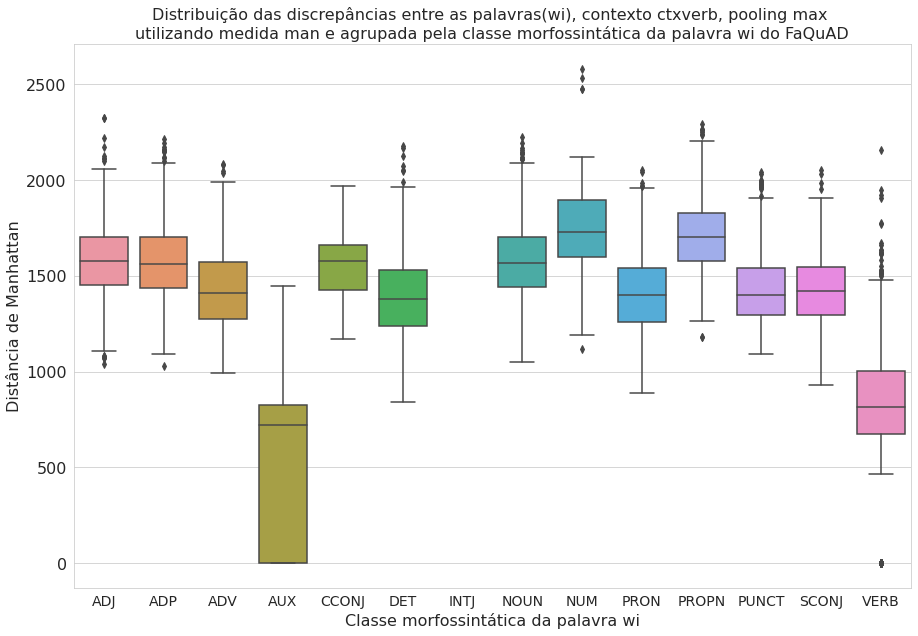

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [ ]:
equacao_medida = "ctxnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1087.000000 0.736097 0.064453 0.449130 0.697794 0.744182 0.777790   
ADP   3105.000000 0.714621 0.071411 0.354187 0.681417 0.730455 0.762187   
ADV    405.000000 0.646008 0.055832 0.490859 0.611675 0.642168 0.686046   
AUX    813.000000 0.675657 0.050464 0.505005 0.641772 0.677505 0.710787   
CCONJ  131.000000 0.451383 0.265080 0.064572 0.149015 0.617822 0.692003   
DET   2372.000000 0.724702 0.045807 0.468404 0.698437 0.728761 0.755508   
INTJ     2.000000 0.715697 0.000000 0.715697 0.715697 0.715697 0.715697   
NOUN  4491.000000 0.877929 0.055823 0.637471 0.841923 0.876271 0.910004   
NUM     82.000000 0.666802 0.048944 0.539983 0.639962 0.675966 0.705302   
PRON  1450.000000 0.637843 0.054961 0.467243 0.600405 0.636952 0.674129   
PROPN  629.000000 0.631872 0.085954 0.340414 0.583805 0.640961 0.694282   
PUNCT 1745.000000 0.661967 0.051197 0.060114 0.632396 0.665968 0.695282   
SCONJ  418.000000 0.627127 0.059360 0.436940 0.589778 0.627971 0.669881   
VERB  1958.000000 0.679279 0.060737 0.449301 0.640523 0.683220 0.724212   

           max  
pos_i           
ADJ   0.912062  
ADP   0.862737  
ADV   0.851276  
AUX   0.829319  
CCONJ 0.750172  
DET   0.840222  
INTJ  0.715697  
NOUN  1.000000  
NUM   0.774303  
PRON  0.802034  
PROPN 0.828312  
PUNCT 0.807098  
SCONJ 0.789321  
VERB  0.826893

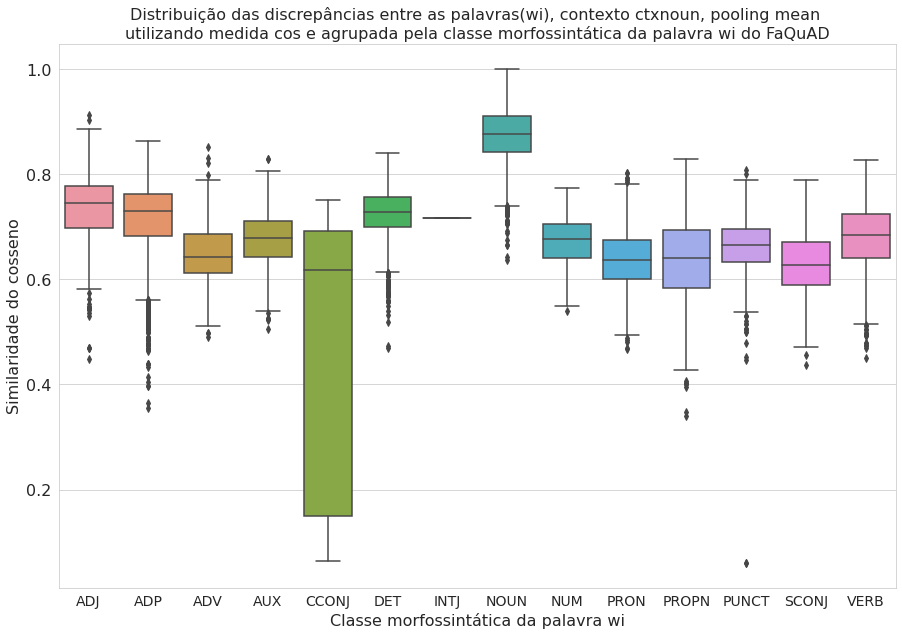

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1087.000000 0.711583 0.065652 0.449130 0.672872 0.713571 0.755167   
ADP   3105.000000 0.714621 0.071411 0.354187 0.681417 0.730455 0.762187   
ADV    405.000000 0.644619 0.055076 0.490859 0.611190 0.641313 0.685649   
AUX    813.000000 0.675657 0.050464 0.505005 0.641772 0.677505 0.710787   
CCONJ  131.000000 0.447272 0.265430 0.064572 0.149015 0.617822 0.692003   
DET   2372.000000 0.722283 0.047810 0.468404 0.695117 0.727016 0.755064   
INTJ     2.000000 0.715697 0.000000 0.715697 0.715697 0.715697 0.715697   
NOUN  4491.000000 0.866137 0.065020 0.591252 0.830060 0.868917 0.906780   
NUM     82.000000 0.640066 0.080939 0.368128 0.607692 0.655364 0.694116   
PRON  1450.000000 0.636902 0.055073 0.467243 0.598326 0.636181 0.673575   
PROPN  629.000000 0.591414 0.089139 0.340414 0.530477 0.592051 0.653408   
PUNCT 1745.000000 0.661967 0.051197 0.060114 0.632396 0.665968 0.695282   
SCONJ  418.000000 0.627127 0.059360 0.436940 0.589778 0.627971 0.669881   
VERB  1958.000000 0.666424 0.059720 0.438007 0.630327 0.671240 0.707324   

           max  
pos_i           
ADJ   0.912062  
ADP   0.862737  
ADV   0.851276  
AUX   0.829319  
CCONJ 0.750172  
DET   0.840222  
INTJ  0.715697  
NOUN  1.000000  
NUM   0.774303  
PRON  0.802034  
PROPN 0.828312  
PUNCT 0.807098  
SCONJ 0.789321  
VERB  0.826829

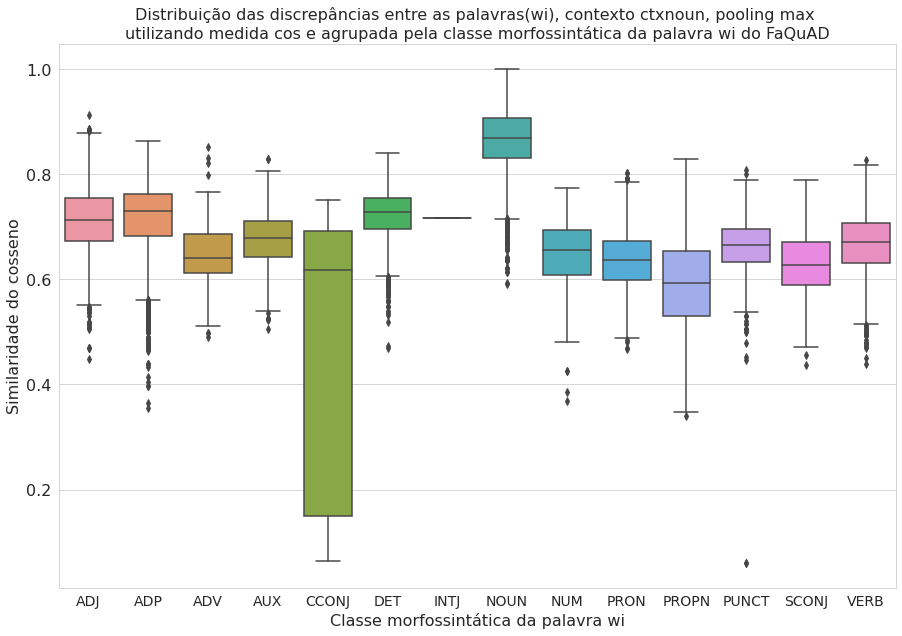

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1087.000000 27.381820 4.548101 16.109329 24.430786 26.929197 30.089295   
ADP   3105.000000 27.999877 4.001576 19.074944 25.147757 27.285685 30.098694   
ADV    405.000000 32.677875 3.275391 21.059134 30.749838 32.170250 34.441334   
AUX    813.000000 29.790010 2.725678 21.624643 27.956520 29.669062 31.442907   
CCONJ  131.000000 34.018260 5.924135 25.980354 28.646101 33.231709 39.262545   
DET   2372.000000 27.110968 2.594158 20.259514 25.339873 26.851882 28.511026   
INTJ     2.000000 27.721729 0.000000 27.721729 27.721729 27.721729 27.721729   
NOUN  4491.000000 17.637761 6.084048  0.000000 15.775094 18.451187 21.072151   
NUM     82.000000 31.920359 3.720522 24.688049 29.063966 32.094677 34.323872   
PRON  1450.000000 31.685376 2.872127 22.133200 29.771747 31.571425 33.466513   
PROPN  629.000000 31.648052 4.757725 21.426603 28.366663 31.124647 34.345074   
PUNCT 1745.000000 29.934614 3.010718 21.970367 27.950199 29.544184 31.266949   
SCONJ  418.000000 32.508549 3.247727 23.464041 30.469362 32.311642 34.385341   
VERB  1958.000000 30.859522 3.747309 21.020739 28.378601 30.670193 33.045288   

            max  
pos_i            
ADJ   44.187862  
ADP   46.894058  
ADV   48.023861  
AUX   43.336243  
CCONJ 47.555218  
DET   41.866512  
INTJ  27.721729  
NOUN  39.985626  
NUM   39.114853  
PRON  44.974079  
PROPN 52.020824  
PUNCT 46.366825  
SCONJ 43.995499  
VERB  48.707672

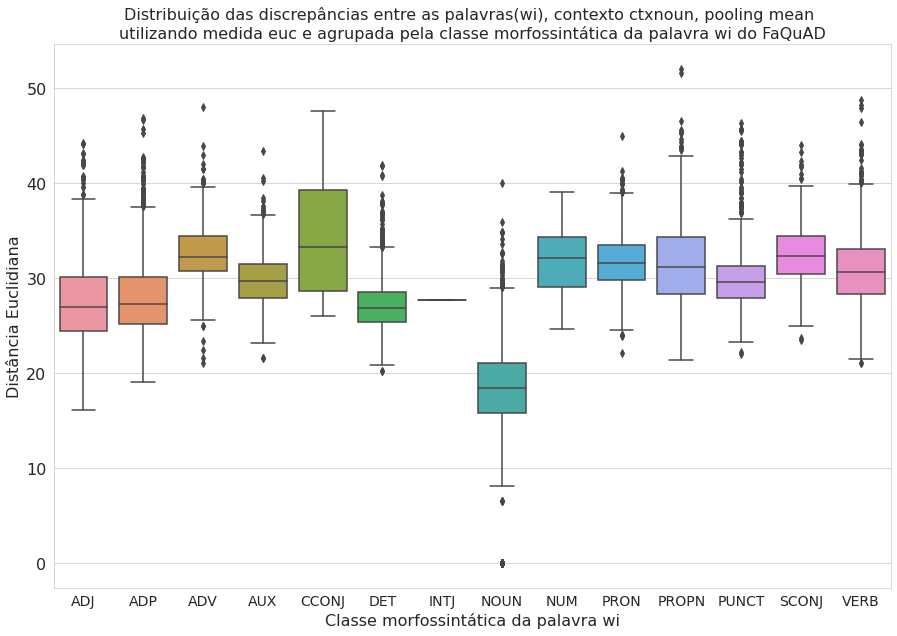

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1087.000000 28.917009 4.206429 16.109329 26.062657 28.595917 31.179502   
ADP   3105.000000 27.999877 4.001576 19.074944 25.147757 27.285685 30.098694   
ADV    405.000000 32.760935 3.209810 21.059134 30.847605 32.218407 34.447720   
AUX    813.000000 29.790010 2.725678 21.624643 27.956520 29.669062 31.442907   
CCONJ  131.000000 34.246230 5.982279 25.980354 28.840487 33.325901 39.271778   
DET   2372.000000 27.261266 2.696247 20.259514 25.368792 26.990138 28.737110   
INTJ     2.000000 27.721729 0.000000 27.721729 27.721729 27.721729 27.721729   
NOUN  4491.000000 18.603745 6.223806  0.000000 16.300100 19.186712 22.073004   
NUM     82.000000 33.940501 5.017141 24.688049 30.701811 33.208788 36.250569   
PRON  1450.000000 31.744892 2.872158 22.133200 29.851154 31.602914 33.575790   
PROPN  629.000000 34.080675 4.862160 21.426603 30.790426 33.891537 37.163872   
PUNCT 1745.000000 29.934614 3.010718 21.970367 27.950199 29.544184 31.266949   
SCONJ  418.000000 32.508549 3.247727 23.464041 30.469362 32.311642 34.385341   
VERB  1958.000000 31.716097 3.446687 21.597652 29.379535 31.396749 33.665613   

            max  
pos_i            
ADJ   48.768486  
ADP   46.894058  
ADV   48.023861  
AUX   43.336243  
CCONJ 47.555218  
DET   41.866512  
INTJ  27.721729  
NOUN  39.985626  
NUM   50.848377  
PRON  44.974079  
PROPN 52.020824  
PUNCT 46.366825  
SCONJ 43.995499  
VERB  48.707672

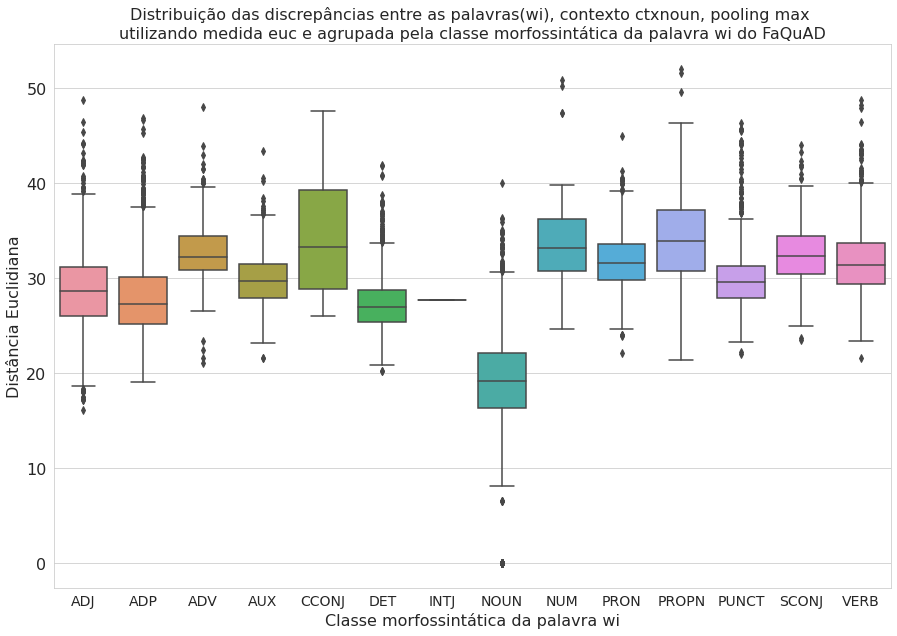

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1087.000000 1288.214771 209.565825  745.595520 1145.312805 1271.204712   
ADP   3105.000000 1356.606569 195.924133  906.792847 1214.773193 1318.213867   
ADV    405.000000 1566.673543 149.945540  992.361328 1465.647583 1551.657715   
AUX    813.000000 1427.472710 126.067707 1048.377808 1339.592529 1422.049561   
CCONJ  131.000000 1433.460437 182.204161 1199.664062 1292.743652 1398.210693   
DET   2372.000000 1307.649072 123.932343  982.965088 1224.703766 1293.799683   
INTJ     2.000000 1349.718140   0.000000 1349.718140 1349.718140 1349.718140   
NOUN  4491.000000  833.741134 286.363307    0.000000  745.289490  874.080261   
NUM     82.000000 1516.129990 158.496731 1215.976807 1405.530670 1528.380249   
PRON  1450.000000 1537.554123 138.160537 1061.072510 1441.197449 1534.700378   
PROPN  629.000000 1498.218614 224.020945 1022.135010 1344.356201 1470.398926   
PUNCT 1745.000000 1460.498589 128.828519 1084.860474 1373.057007 1447.996338   
SCONJ  418.000000 1583.378092 161.087073 1157.232178 1468.926178 1570.917786   
VERB  1958.000000 1473.374949 173.714185  990.989319 1356.249573 1467.096436   

              75%         max  
pos_i                          
ADJ   1424.347290 2064.401855  
ADP   1461.679688 2309.904297  
ADV   1646.599609 2076.725586  
AUX   1507.487793 1899.568726  
CCONJ 1485.013672 2141.751709  
DET   1373.465363 2034.913696  
INTJ  1349.718140 1349.718140  
NOUN   999.607971 1705.408447  
NUM   1620.628113 1840.279419  
PRON  1623.952362 1997.242920  
PROPN 1634.468506 2521.047119  
PUNCT 1531.777954 2102.167236  
SCONJ 1670.425140 2187.544434  
VERB  1577.578156 2188.519287

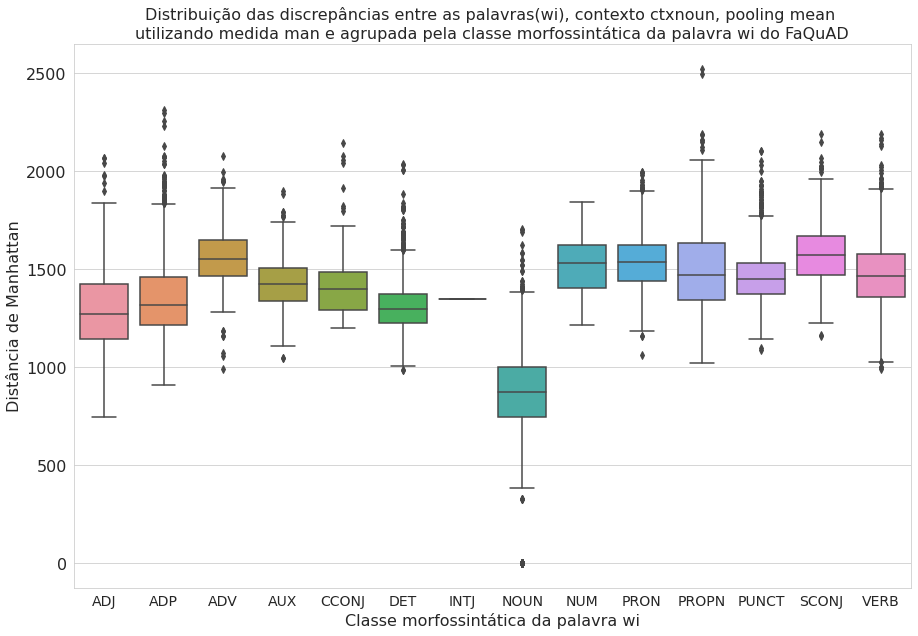

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1087.000000 1359.439145 193.590504  781.642456 1230.040100 1341.064697   
ADP   3105.000000 1356.606569 195.924133  906.792847 1214.773193 1318.213867   
ADV    405.000000 1570.970883 145.946110  992.361328 1470.412109 1555.158813   
AUX    813.000000 1427.472710 126.067707 1048.377808 1339.592529 1422.049561   
CCONJ  131.000000 1443.093520 188.727968 1199.664062 1309.377808 1398.635864   
DET   2372.000000 1314.667862 128.793653  982.965088 1225.881683 1299.096802   
INTJ     2.000000 1349.718140   0.000000 1349.718140 1349.718140 1349.718140   
NOUN  4491.000000  879.603474 294.324832    0.000000  771.302124  906.463684   
NUM     82.000000 1619.265565 249.405263 1237.516113 1482.156006 1583.182190   
PRON  1450.000000 1540.093455 137.836813 1061.072510 1443.560883 1537.092102   
PROPN  629.000000 1615.117974 234.682460 1022.135010 1455.551270 1602.683105   
PUNCT 1745.000000 1460.498589 128.828519 1084.860474 1373.057007 1447.996338   
SCONJ  418.000000 1583.378092 161.087073 1157.232178 1468.926178 1570.917786   
VERB  1958.000000 1514.408375 161.923757 1026.994629 1405.173004 1504.260864   

              75%         max  
pos_i                          
ADJ   1475.163818 2064.401855  
ADP   1461.679688 2309.904297  
ADV   1657.665771 2076.725586  
AUX   1507.487793 1899.568726  
CCONJ 1494.297546 2141.751709  
DET   1386.662750 2034.913696  
INTJ  1349.718140 1349.718140  
NOUN  1045.429016 1775.009766  
NUM   1715.225342 2549.512207  
PRON  1627.871063 1997.242920  
PROPN 1770.836548 2521.047119  
PUNCT 1531.777954 2102.167236  
SCONJ 1670.425140 2187.544434  
VERB  1603.726868 2239.623535

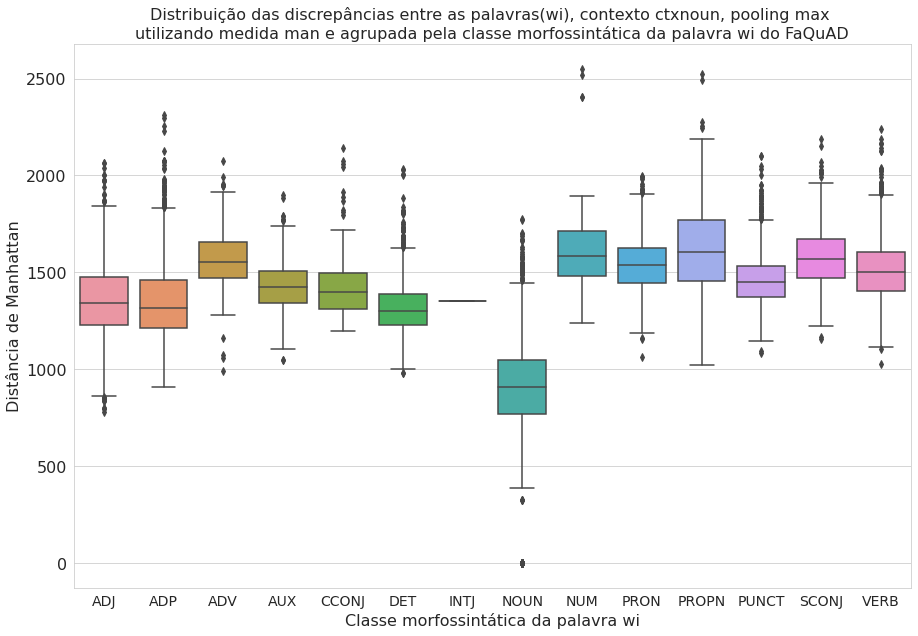

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [ ]:
equacao_medida = "ctxverbnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1097.000000 0.754219 0.047419 0.539062 0.723965 0.755766 0.786760   
ADP   3170.000000 0.738415 0.059067 0.430342 0.711436 0.748680 0.778716   
ADV    417.000000 0.732809 0.047709 0.560537 0.708210 0.739757 0.765053   
AUX    904.000000 0.863030 0.054641 0.693936 0.829751 0.859182 0.888180   
CCONJ  133.000000 0.474399 0.284279 0.091822 0.151982 0.658954 0.729053   
DET   2426.000000 0.769375 0.048608 0.558363 0.737422 0.772533 0.803774   
INTJ     2.000000 0.715697 0.000000 0.715697 0.715697 0.715697 0.715697   
NOUN  4491.000000 0.840634 0.045643 0.619692 0.811309 0.842754 0.871863   
NUM     83.000000 0.699542 0.043162 0.572057 0.670020 0.702324 0.725874   
PRON  1631.000000 0.725464 0.045630 0.547794 0.696629 0.726113 0.756524   
PROPN  798.000000 0.659493 0.074363 0.413818 0.615724 0.666283 0.710100   
PUNCT 1865.000000 0.727237 0.047283 0.050545 0.701392 0.732874 0.756625   
SCONJ  432.000000 0.717556 0.053147 0.527582 0.685757 0.721060 0.755752   
VERB  2030.000000 0.846837 0.047452 0.574439 0.820311 0.847418 0.876529   

           max  
pos_i           
ADJ   0.882007  
ADP   0.862668  
ADV   0.876434  
AUX   1.000000  
CCONJ 0.785885  
DET   0.894944  
INTJ  0.715697  
NOUN  1.000000  
NUM   0.802693  
PRON  0.851450  
PROPN 0.820403  
PUNCT 0.832677  
SCONJ 0.833087  
VERB  1.000000

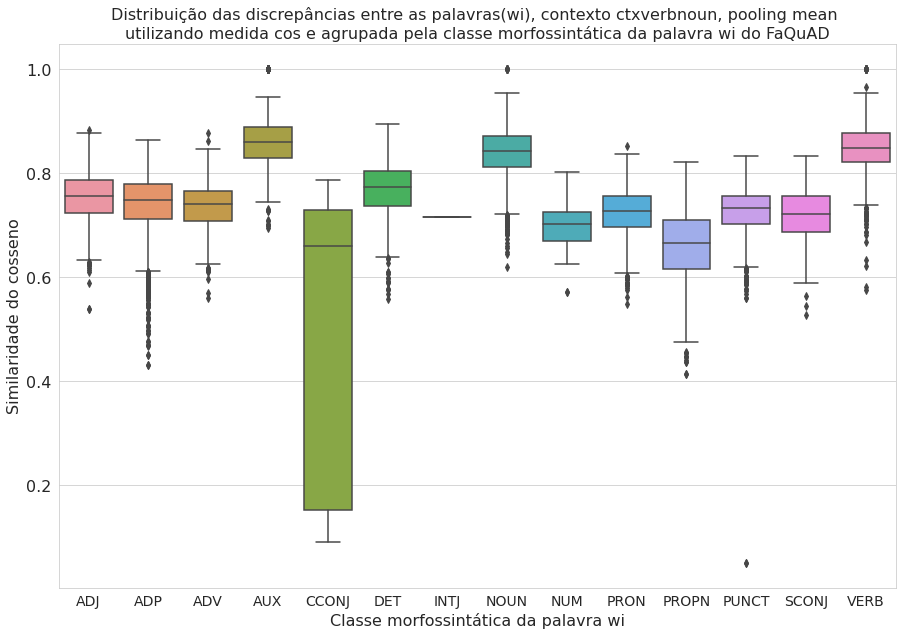

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ   1097.000000 0.729889 0.055824 0.515536 0.698578 0.733994 0.768528   
ADP   3170.000000 0.738415 0.059067 0.430342 0.711436 0.748680 0.778716   
ADV    417.000000 0.730940 0.049398 0.560537 0.705240 0.738936 0.764900   
AUX    904.000000 0.863030 0.054641 0.693936 0.829751 0.859182 0.888180   
CCONJ  133.000000 0.469865 0.284372 0.091822 0.151982 0.658954 0.729053   
DET   2426.000000 0.766892 0.050423 0.558363 0.733645 0.770321 0.803139   
INTJ     2.000000 0.715697 0.000000 0.715697 0.715697 0.715697 0.715697   
NOUN  4491.000000 0.829200 0.056479 0.567776 0.797606 0.836384 0.867516   
NUM     83.000000 0.671829 0.082358 0.389424 0.642362 0.691718 0.725874   
PRON  1631.000000 0.724543 0.045637 0.547794 0.695564 0.725146 0.755742   
PROPN  798.000000 0.615345 0.076086 0.390344 0.565711 0.620184 0.663217   
PUNCT 1865.000000 0.727237 0.047283 0.050545 0.701392 0.732874 0.756625   
SCONJ  432.000000 0.717556 0.053147 0.527582 0.685757 0.721060 0.755752   
VERB  2030.000000 0.832374 0.056602 0.528096 0.801168 0.836820 0.867483   

           max  
pos_i           
ADJ   0.882007  
ADP   0.862668  
ADV   0.876434  
AUX   1.000000  
CCONJ 0.785885  
DET   0.894944  
INTJ  0.715697  
NOUN  1.000000  
NUM   0.802693  
PRON  0.836006  
PROPN 0.820403  
PUNCT 0.832677  
SCONJ 0.833087  
VERB  1.000000

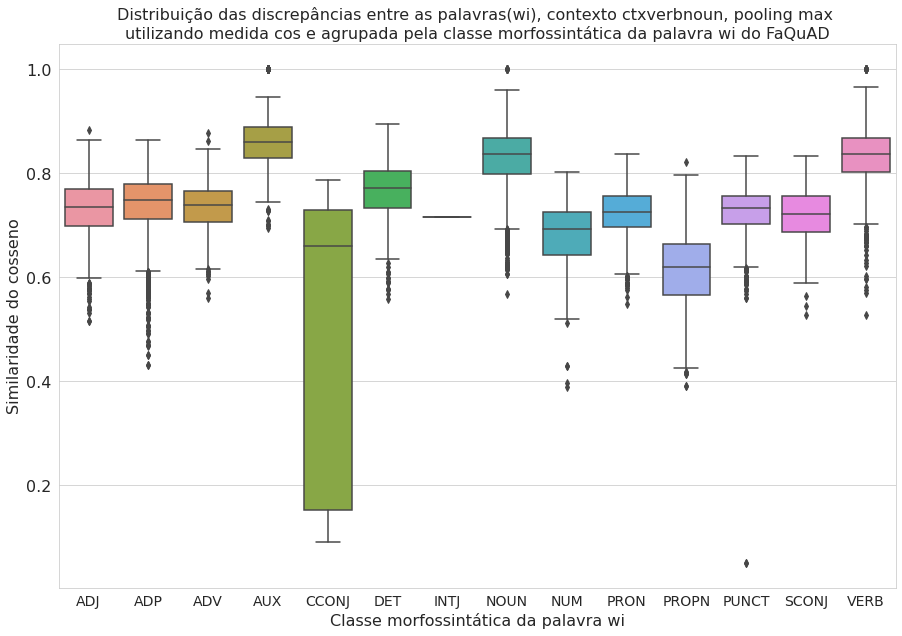

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1097.000000 26.268520 3.719172 17.057652 23.834829 25.942047 28.328365   
ADP   3170.000000 26.679972 3.284846 19.203640 24.425366 26.178908 28.202059   
ADV    417.000000 28.269475 3.311557 18.771376 25.773655 27.975853 30.467449   
AUX    904.000000 18.607150 5.779174  0.000000 17.449295 19.609452 21.504667   
CCONJ  133.000000 32.272985 6.031467 23.270773 26.754202 30.787798 38.204807   
DET   2426.000000 24.613234 2.797247 16.135458 22.654109 24.476526 26.403455   
INTJ     2.000000 27.721729 0.000000 27.721729 27.721729 27.721729 27.721729   
NOUN  4491.000000 20.804033 3.443445  0.000000 18.656158 20.726318 22.814786   
NUM     83.000000 30.047607 3.348885 22.522182 27.450523 30.040487 32.177912   
PRON  1631.000000 27.346307 2.590823 19.302406 25.596601 27.247484 28.970467   
PROPN  798.000000 29.938680 3.993541 21.686462 27.102787 29.523365 32.290591   
PUNCT 1865.000000 26.608494 2.612111 20.606083 24.969843 26.225246 27.751898   
SCONJ  432.000000 28.071982 2.967554 21.655046 25.987056 27.844440 29.755100   
VERB  2030.000000 21.578331 4.203370  0.000000 19.433904 21.602020 23.814099   

            max  
pos_i            
ADJ   42.978561  
ADP   41.161316  
ADV   43.834389  
AUX   30.816385  
CCONJ 43.860901  
DET   39.515011  
INTJ  27.721729  
NOUN  38.187222  
NUM   37.272999  
PRON  39.313953  
PROPN 46.118202  
PUNCT 44.364544  
SCONJ 37.906246  
VERB  40.630005

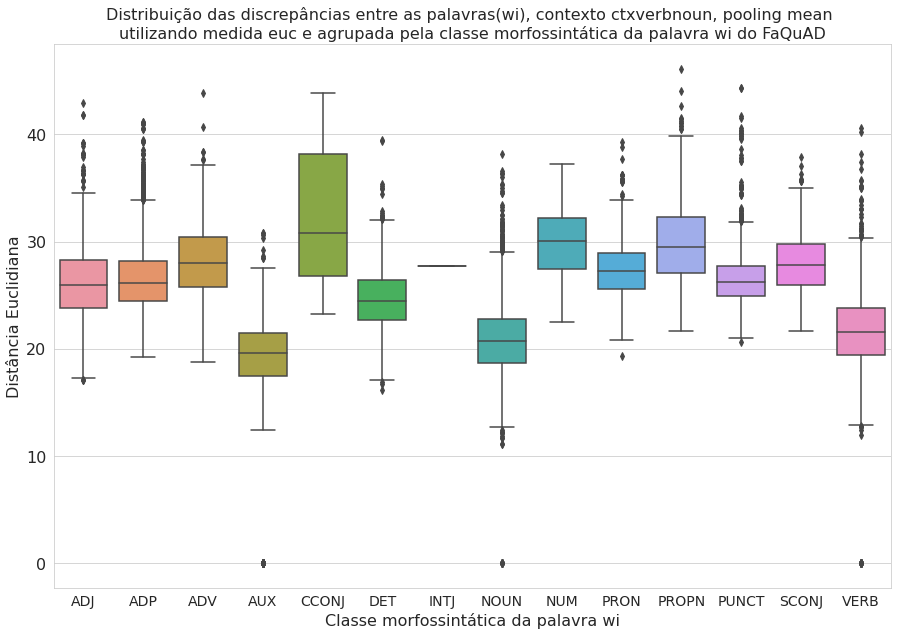

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   1097.000000 27.802495 3.531946 17.307438 25.473555 27.519644 29.735584   
ADP   3170.000000 26.679972 3.284846 19.203640 24.425366 26.178908 28.202059   
ADV    417.000000 28.381612 3.343945 18.771376 25.905043 28.049376 30.516983   
AUX    904.000000 18.607150 5.779174  0.000000 17.449295 19.609452 21.504667   
CCONJ  133.000000 32.515167 6.091875 23.270773 26.814137 30.836830 38.263805   
DET   2426.000000 24.773720 2.904448 16.135458 22.700974 24.615070 26.651091   
INTJ     2.000000 27.721729 0.000000 27.721729 27.721729 27.721729 27.721729   
NOUN  4491.000000 21.598898 3.833368  0.000000 19.144484 21.399677 23.881825   
NUM     83.000000 32.132380 5.007100 22.522182 29.386973 31.661659 34.820717   
PRON  1631.000000 27.408110 2.579255 21.015318 25.622364 27.271730 29.007006   
PROPN  798.000000 32.613213 4.031966 22.797735 29.889378 32.424191 35.158062   
PUNCT 1865.000000 26.608494 2.612111 20.606083 24.969843 26.225246 27.751898   
SCONJ  432.000000 28.071982 2.967554 21.655046 25.987056 27.844440 29.755100   
VERB  2030.000000 22.685783 4.376967  0.000000 20.432496 22.652303 25.219602   

            max  
pos_i            
ADJ   42.978561  
ADP   41.161316  
ADV   43.834389  
AUX   30.816385  
CCONJ 43.860901  
DET   39.515011  
INTJ  27.721729  
NOUN  38.187222  
NUM   49.117348  
PRON  39.313953  
PROPN 46.118202  
PUNCT 44.364544  
SCONJ 37.906246  
VERB  42.210827

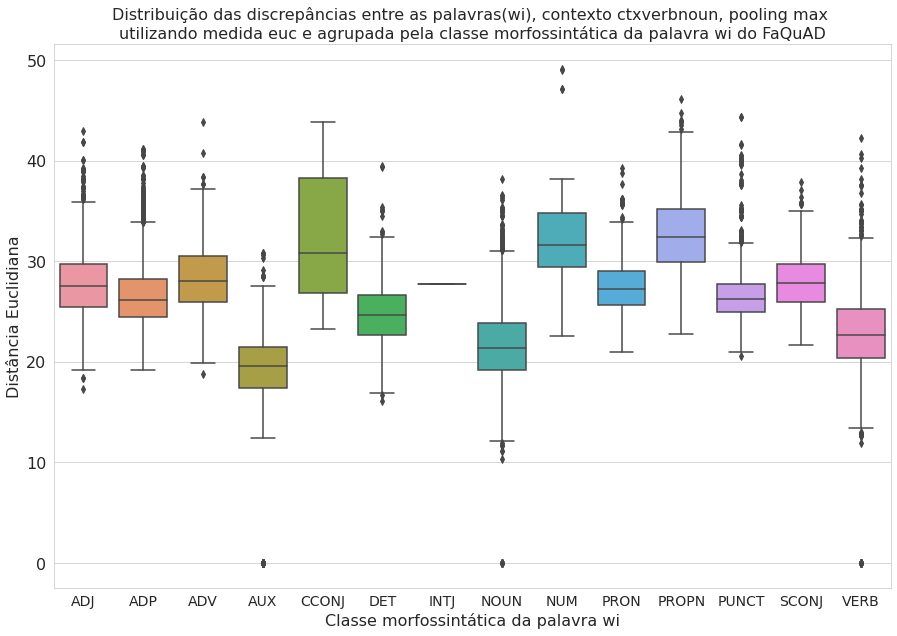

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1097.000000 1240.613699 166.306703  797.316162 1125.923828 1228.484375   
ADP   3170.000000 1302.552448 160.832479  921.840332 1192.609924 1277.141907   
ADV    417.000000 1363.780870 152.321323  906.845337 1252.379883 1344.578857   
AUX    904.000000  894.181131 278.669046    0.000000  839.332504  947.791016   
CCONJ  133.000000 1324.992787 128.768299 1108.243774 1242.928711 1295.064453   
DET   2426.000000 1197.200653 132.933821  795.732117 1105.732941 1190.176025   
INTJ     2.000000 1349.718140   0.000000 1349.718140 1349.718140 1349.718140   
NOUN  4491.000000  985.775226 159.129159    0.000000  887.111450  983.997803   
NUM     83.000000 1434.855026 144.449445 1108.642700 1327.063110 1435.018311   
PRON  1631.000000 1334.979767 129.394154  920.813293 1246.480713 1330.473145   
PROPN  798.000000 1419.718004 187.752653 1045.929688 1287.770752 1398.983765   
PUNCT 1865.000000 1307.356173 113.529285  993.288208 1229.672363 1292.093506   
SCONJ  432.000000 1376.746586 147.468248 1060.019653 1278.792633 1362.737061   
VERB  2030.000000 1033.255459 198.820514    0.000000  927.031311 1038.107544   

              75%         max  
pos_i                          
ADJ   1345.787354 1903.275391  
ADP   1378.671722 2043.186523  
ADV   1459.612305 1893.643799  
AUX   1040.233002 1516.834717  
CCONJ 1393.292358 1812.035034  
DET   1280.958862 1948.202271  
INTJ  1349.718140 1349.718140  
NOUN  1079.098145 1692.941406  
NUM   1540.653137 1695.271484  
PRON  1413.578918 1943.910889  
PROPN 1531.367188 2154.859375  
PUNCT 1367.941284 1823.615234  
SCONJ 1463.943054 1819.512207  
VERB  1137.587097 2030.208618

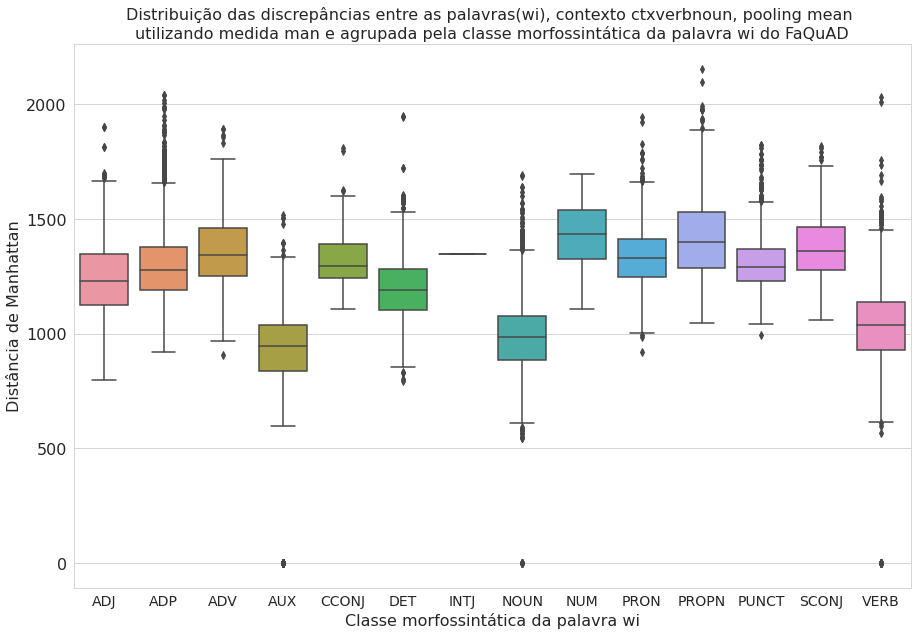

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   1097.000000 1311.843082 159.347385  797.316162 1206.706055 1296.251587   
ADP   3170.000000 1302.552448 160.832479  921.840332 1192.609924 1277.141907   
ADV    417.000000 1369.326167 153.306774  906.845337 1254.102295 1360.668213   
AUX    904.000000  894.181131 278.669046    0.000000  839.332504  947.791016   
CCONJ  133.000000 1335.093113 138.054426 1126.234497 1246.009644 1309.509766   
DET   2426.000000 1204.747101 137.724385  795.732117 1109.311584 1197.447693   
INTJ     2.000000 1349.718140   0.000000 1349.718140 1349.718140 1349.718140   
NOUN  4491.000000 1023.338360 179.955914    0.000000  908.966064 1013.699036   
NUM     83.000000 1540.298235 251.961312 1108.642700 1421.309143 1508.867920   
PRON  1631.000000 1337.631660 128.602035  998.117310 1247.096497 1332.756836   
PROPN  798.000000 1549.369590 198.721125 1049.641235 1410.769714 1533.233887   
PUNCT 1865.000000 1307.356173 113.529285  993.288208 1229.672363 1292.093506   
SCONJ  432.000000 1376.746586 147.468248 1060.019653 1278.792633 1362.737061   
VERB  2030.000000 1086.755113 210.520642    0.000000  977.615845 1082.953308   

              75%         max  
pos_i                          
ADJ   1394.418945 1982.945679  
ADP   1378.671722 2043.186523  
ADV   1471.843018 1893.643799  
AUX   1040.233002 1516.834717  
CCONJ 1401.658936 1812.035034  
DET   1294.858643 1948.202271  
INTJ  1349.718140 1349.718140  
NOUN  1127.960754 1739.203857  
NUM   1627.230347 2483.040771  
PRON  1417.379761 1943.910889  
PROPN 1677.944214 2187.465332  
PUNCT 1367.941284 1823.615234  
SCONJ 1463.943054 1819.512207  
VERB  1212.922058 2168.713379

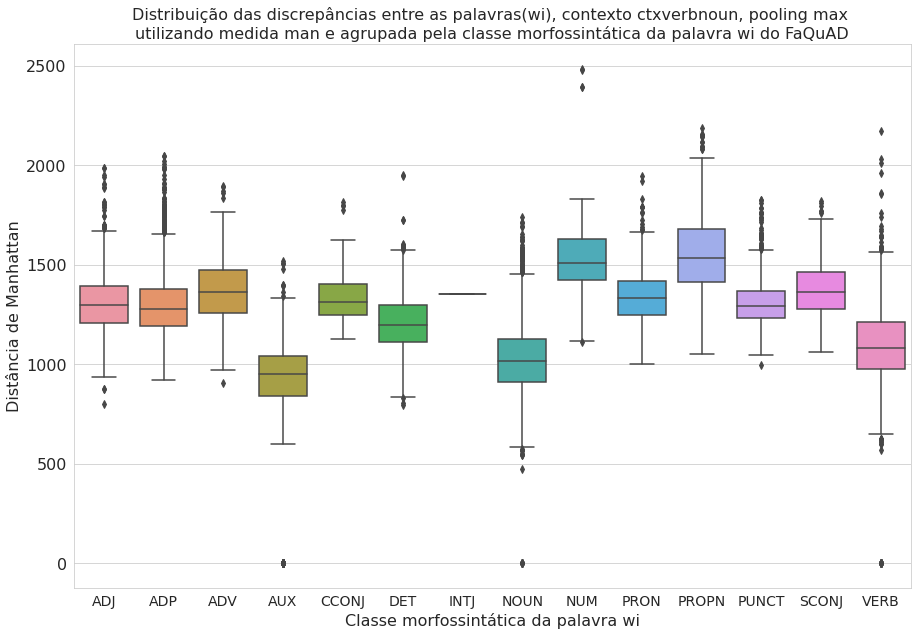

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/19484 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

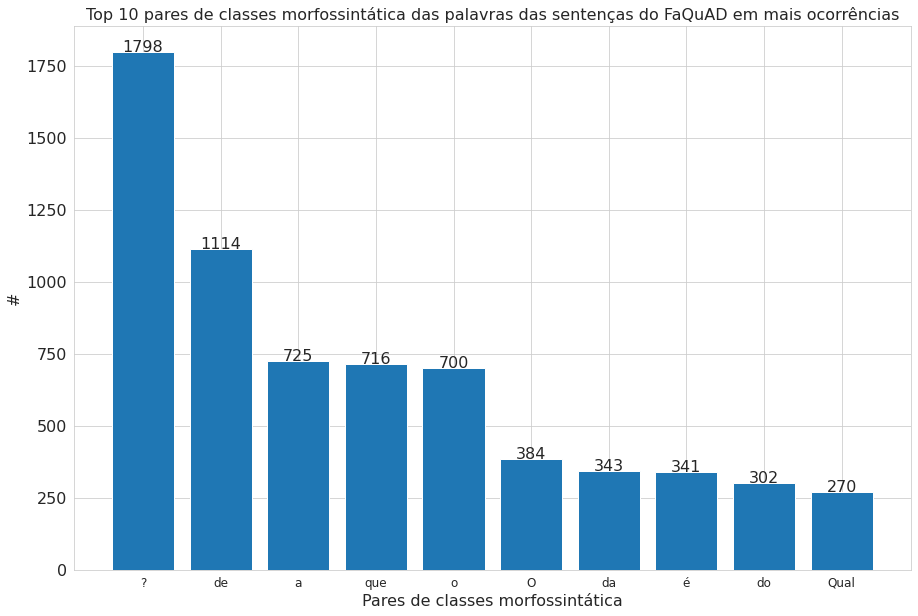

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do FaQuAD em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2030


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count      2030.000000      2030.000000     2030.000000     2030.000000   
mean          0.808285        24.089145     1209.157486        0.793934   
std           0.046281         3.874788      157.132838        0.044791   
min           0.539066        11.439407      790.707300        0.539066   
25%           0.779756        21.625501     1101.147600        0.768272   
50%           0.809923        24.009188     1198.179200        0.797025   
75%           0.839483        26.449080     1303.020575        0.824037   
max           0.939491        41.847027     2123.833000        0.906923   

       euc_ctxall_max  man_ctxall_max  
count     2030.000000     2030.000000  
mean        25.171178     1209.157486  
std          3.400965      157.132838  
min         16.289457      790.707300  
25%         22.833166     1101.147600  
50%         24.919869     1198.179200  
75%         27.143982     1303.020575  
max         41.847027     2123.833000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2030 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2  322
      2        4  287
      3        3  255
      4        5  219
      5        6  204
      6        1  165
      7        7  160
      8        8  104
      9        9   77
     10       10   56
     11       11   40
     12       12   36
     13       13   29
     14       14   26
     15       15   14
     16        0    8
     17       16    8
     18       20    4
     19       18    4
     20       41    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.059726521372795105
Limite superior             : 0.9290725067257881
Limite inferior             : 0.6901664212346077


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 2030 ( 0.0009852216748768472 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 26 de 2030 ( 0.012807881773399015 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  28 de 2030 ( 0.013793103448275862 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9394912123680116 iniciou-se
         Onde iniciou-se o desenvolvimento da primeira universidade árabe?

 2 0.9319118857383728 logarítmos
         Quem inventou os logarítmos?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5390658974647522 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5465554594993591 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.5735670924186707 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que acontece caso o Aluno Especial não tenha o aproveitamento das duas disciplinas cursadas até a data de matrícula ?
       1 0.8272116184234619 cursadas
       2 0.7957244515419006 tenha
       3 0.6887486577033997 acontece

 2 Qual a base da análise e interpretação dos dados obtidos a partir da observação de fatos e fenômenos exatamente como ocorem realmente ?
       1 0.7849771976470947 obtidos
       2 0.782579243183136 ocorem
       3 0.688194990158081 partir

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?
       1 0.7897260189056396 matricular
       2 0.7723569869995117 deve
       3 0.769128680229187 enquadrado
       4 0.7419469356536865 apresentar
       5 0.720953643321991 existir
       6 0.7155600786209106 realizadas
       7 0.6866907477378845 impeçam

 4 De quem foram as palavras “ Há po

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.055764615535736084
Limite superior             : 0.9076837301254272
Limite inferior             : 0.6846252679824829


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 37 de 2030 ( 0.018226600985221674 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  37 de 2030 ( 0.018226600985221674 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5390658974647522 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5465554594993591 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.5602651238441467 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Bra

###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 A quem é dirigida a frase " Ciência é para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos " ?
       1 0.7718521952629089 é
       2 0.6845475435256958 dirigida

 2 O que acontece caso o Aluno Especial não requeira o aproveitamento das duas disciplinas cursadas até a data de matrícula?
       1 0.7311463952064514 requeira
       2 0.683479905128479 acontece
       3 0.6634155511856079 cursadas

 3 Quando o livro Calculando com numerais hindus foi traduzido para o latim?
       1 0.7623977661132812 traduzido
       2 0.6809377670288086 Calculando

 4 Quando o livro Calculando com numerais hindus foi traduzido para o latim ?
       1 0.7623977661132812 traduzido
       2 0.6809377670288086 Calculando

 5 Em que a rápida mudança promovida pelos computadores tornou a oferta de vagas para o profissional da engenharia de computação?
       1 0.7359910011291504 tornou
       2 0.6805356740951538 promovida


##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.823578834533695
Limite superior             : 33.68444776535035
Limite inferior             : 14.390132427215567


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 29 de 2030 ( 0.014285714285714285 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5 de 2030 ( 0.0024630541871921183 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  34 de 2030 ( 0.016748768472906402 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.84702682495117 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 41.45708847045898 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 40.52007293701172 ficaram
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 4 40.472286224365234 recorre
         A resolução nº 342 torna recorre o quê?

 5 40.20133972167969 participando
         O que a UFMS visa participando do ensino e da preservação

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.439407348632812 iniciou-se
         Onde iniciou-se o desenvolvimento da primeira universidade árabe?

 2 12.814194679260254 logarítmos
         Quem inventou os logarítmos?

 3 13.63304615020752 inventou
         Quem inventou os dinossauros ?

 4 14.008913040161133 ensinava
         O que Eduba ensinava?

 5 14.18366527557373 automatizam
         O que as soluções tecnológicas automatizam?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.84702682495117 Há
       2 37.35892868041992 passava
       3 24.760927200317383 financiadas
       4 24.37208366394043 beneficiarão
       5 23.988075256347656 constituírem-se

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 41.45708847045898 Há
       2 36.86811828613281 passava
       3 36.41535949707031 transformar
       4 25.1381893157959 financiadas
       5 24.79059791564941 beneficiarão

 3 Como ficaram r a série 

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.310816287994385
Limite superior             : 33.61020636558533
Limite inferior             : 16.366941213607788


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 35 de 2030 ( 0.017241379310344827 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 2030 ( 0.0004926108374384236 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  36 de 2030 ( 0.017733990147783252 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.84702682495117 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 41.45708847045898 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 41.06435394287109 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasíl

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 16.289457321166992 pode
         Como o tema pode ser procurado ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.84702682495117 Há
       2 41.06435394287109 constituírem-se
       3 37.35892868041992 passava
       4 30.43101119995117 financiadas
       5 30.138525009155277 beneficiarão

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 41.45708847045898 Há
       2 36.86811828613281 passava
       3 36.41535949707031 transformar
       4 30.68578147888184 financiadas
       5 30.343318939208984 beneficiarão

 3 De quem foram as palav

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 224.7270749999998
Limite superior             : 1609.8571874999996
Limite inferior             : 710.9488875000004


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 17 de 2030 ( 0.008374384236453201 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 8 de 2030 ( 0.003940886699507389 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  25 de 2030 ( 0.012315270935960592 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2096.3018 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2072.389 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1839.5706 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 4 1815.0728 passava
      

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 546.87476 iniciou-se
         Onde iniciou-se o desenvolvimento da primeira universidade árabe?

 2 629.6856 logarítmos
         Quem inventou os logarítmos?

 3 658.8638 inventou
         Quem inventou os dinossauros ?

 4 679.5543 ensinava
         O que Eduba ensinava?

 5 688.70776 automatizam
         O que as soluções tecnológicas automatizam?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2096.3018 Há
       2 1839.5706 passava
       3 1219.2422 financiadas
       4 1215.3572 beneficiarão
       5 1153.0365 constituírem-se

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 2072.389 Há
       2 1815.0728 passava
       3 1745.2418 transformar
       4 1243.1453 financiadas
       5 1237.9489 beneficiarão

 3 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irr

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 201.872975
Limite superior             : 1605.8300375
Limite inferior             : 798.3381375


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 28 de 2030 ( 0.013793103448275862 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 2030 ( 0.0004926108374384236 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  29 de 2030 ( 0.014285714285714285 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2123.833 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2096.3018 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 2072.389 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 4 1924.5151 debruça

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 790.7073 pode
         Como o tema pode ser procurado ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2123.833 constituírem-se
       2 2096.3018 Há
       3 1839.5706 passava
       4 1501.3914 financiadas
       5 1478.8793 beneficiarão

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2123.833 constituírem-se
       2 2096.3018 Há
       3 1839.5706 passava
       4 1501.3914 financiadas
       5 1478.8793 beneficiarão

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade 

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 4491


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count      4491.000000      4491.000000      4491.000000     4491.000000   
mean          0.799251        23.211993      1097.051105        0.787799   
std           0.042575         3.169754       142.993978        0.042474   
min           0.612205        11.380696       545.380860        0.611669   
25%           0.773486        21.303830      1010.102785        0.763845   
50%           0.800431        23.036470      1089.222000        0.791351   
75%           0.827224        25.023160      1181.027100        0.818002   
max           0.941702        41.371395      1802.809400        0.902142   

       euc_ctxall_max  man_ctxall_max  
count     4491.000000     4491.000000  
mean        24.011409     1135.393263  
std          2.885353      133.091098  
min         16.334976      790.062130  
25%         22.043654     1042.061200  
50%         23.738420     1121.352700  
75%         25.628960     1210.122300  
max         41.371395     1802.809400

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/4491 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  584
      2        5  545
      3        4  490
      4        6  419
      5        2  408
      6        7  385
      7        8  349
      8        9  294
      9        1  238
     10       10  157
     11       11  152
     12       12  111
     13       13   87
     14       14   62
     15       15   42
     16       17   38
     17        0   29
     18       16   29
     19       18   18
     20       19   14


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0537378191947937
Limite superior             : 0.9078303277492523
Limite inferior             : 0.6928790509700775


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 29 de 4491 ( 0.006457359162769984 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 48 de 4491 ( 0.01068804275217101 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  77 de 4491 ( 0.017145401914940992 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.941701591014862 logaritmo
         Quem descobriu o logaritmo ?

 2 0.9330315589904784 trancamento
         Quando a renovação de matrícula é transformada em trancamento ?

 3 0.931590974330902 logaritmo
         Quem inventou o logaritmo?

 4 0.9274882078170776 trancamento
         Quando a renovação de matrícula é convertida em trancamento?

 5 0.9259556531906128 eletroeletrônicos
         Por que grande parte dos eletroeletrônicos são sistemas de computação?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6122053265571594 sonho
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.6160096526145935 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 0.6275510787963867 pesquisas
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasí

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?
       1 0.8023650050163269 pré-requisitos
       2 0.7475796341896057 semestre
       3 0.7451803088188171 semestre
       4 0.7305911779403687 acadêmico
       5 0.719606339931488 inicial
       6 0.7035855650901794 caso
       7 0.7007956504821777 disciplinas
       8 0.6926469206809998 carga

 2 O que a UFPE criou numa parceria com o Centro de Informática e o Departamento de Eletrônica e Sistemas?
       1 0.6916874051094055 parceria

 3 Em que ano a comunidade científica do distrito federal iniciou a criação de uma instituição voltada ao incentivo da ciência e tecnologia ?
       1 0.7990459203720093 instituição
       2 0.7867843508720398 ano
       3 0.7725094556808472 criação
       4 0.7699226140975952 incentivo
       5 0.7179945111274719 ciência
       6

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.054156988859176636
Limite superior             : 0.8992373198270798
Limite inferior             : 0.6826093643903732


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 4491 ( 0.00044533511467379205 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 75 de 4491 ( 0.016700066800267203 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  77 de 4491 ( 0.017145401914940992 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.902141571044922 mais
         O que o desenvolvimento cada vez mais rápido de novas tecnologias significa ?

 2 0.9008813500404358 cursos
         Os cursos de pós-graduação são quais cursos ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.611668586730957 colação
         Em qual ano os alunos de colação de grau poderão ser incluídos em disciplinas sem que tenham cumprido todos os pré-requisitos ?

 2 0.6122053265571594 sonho
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 0.615165650844574 colação
         Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham cumprido todos os pré-requisitos?

 4 0.6160096526145935 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasíli

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quantos projetos foram selecionados no primeiro edital da FAPDF ?
       1 0.7922924160957336 projetos
       2 0.7680560946464539 edital
       3 0.6818459033966064 FAPDF

 2 quais as condições para solicitar dispensa para fins de abreviação de curso?
       1 0.7856205105781555 dispensa
       2 0.7806468605995178 abreviação
       3 0.7646284103393555 curso
       4 0.710534930229187 condições
       5 0.6818228960037231 fins

 3 Em que lugar está a UFMS na edição de 2014 do Guia do Estudante ?
       1 0.8089191913604736 lugar
       2 0.7790758609771729 edição
       3 0.6794566512107849 UFMS

 4 Quanto do questionário deve ser respondido para que a carga horária de resposta ao questionário do estudante da Comissão Própria de Avaliação da UFMS seja válida?
       1 0.7925109267234802 carga
       2 0.7680820822715759 estudante
       3 0.7405748963356018 resposta
       4 0.7035449743270874 questionário
       5 0.697811484336853 questionário
       6 0.6793577075004578 Avalia

##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.719329833984375
Limite superior             : 30.60215473175049
Limite inferior             : 15.724835395812988


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 94


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 66 de 4491 ( 0.014696058784235137 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  160 de 4491 ( 0.03562680917390336 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.371395111083984 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 40.33634567260742 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 3 37.98458862304688 anime
         O que é necessário para que um indivíduo se anime para obter a habilitação de professor nos países europeus ?

 4 37.70808410644531 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 5 37.57270431518555 posicionamento
         Quando as vagas nas disciplinas alocadas no período de posicionamento do discente não são ocupadas ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.380696296691896 logaritmo
         Quem descobriu o logaritmo ?

 2 12.307233810424805 logaritmo
         Quem inventou o logaritmo?

 3 12.650434494018556 eletroeletrônicos
         Por que grande parte dos eletroeletrônicos são sistemas de computação?

 4 12.911957740783691 eletroeletrônicos
         Por que grande parte dos eletroeletrônicos são sistemas de controle ?

 5 13.050943374633787 eletricistas
         Para que os eletricistas contruiam circuitos eletrônicos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 41.371395111083984 r
       2 27.42708969116211 série
       3 27.04275321960449 software
       4 26.44053840637207 pacotes
       5 24.305635452270508 inovações
       6 23.91275405883789 terminais
       7 23.48380851745605 flexibilidade

 2 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 40.33634567260742 teorema
       2 25.85816764831543 conceitos
       3 25.4057674407959 cálculo
       4 23.962831497192383 definição
       5 17.780603408813477 recursividade

 3 O que é necessário para que um indivíduo se anime para obter a habilitação de professor nos países europeus ?
       1 37.98458862304688 anime
       2 26.644359588623047 países
       3 26.10820198059082 indivíduo
       4 25.064077377319336 professor
       5 24.76735115051269 habilitação

 4 Em qual semestre o acadêmico deve ser enquadrado no caso d

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.5853052139282227
Limite superior             : 31.006917476654053
Limite inferior             : 16.665696620941162


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 104


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 4491 ( 0.00044533511467379205 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  106 de 4491 ( 0.023602761077710976 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.371395111083984 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 40.33634567260742 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 3 37.98458862304688 anime
         O que é necessário para que um indivíduo se anime para obter a habilitação de professor nos países europeus ?

 4 37.70808410644531 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 5 37.57270431518555 posicionamento
         Quando as vagas nas disciplinas alocadas no período de posicionamento do discente não são ocupadas ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 16.334976196289062 cursos
         Os cursos de pós-graduação são quais cursos ?

 2 16.513425827026367 mais
         O que o desenvolvimento cada vez mais rápido de novas tecnologias significa ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 41.371395111083984 r
       2 27.922231674194336 flexibilidade
       3 27.42708969116211 série
       4 27.04275321960449 software
       5 26.44053840637207 pacotes
       6 24.305635452270508 inovações
       7 23.91275405883789 terminais

 2 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 40.33634567260742 teorema
       2 25.85816764831543 conceitos
       3 25.4057674407959 cálculo
       4 24.243371963500977 recursividade
       5 23.962831497192383 definição

 3 O que é necessário para que um indivíduo se anime para obter a habilitação de professor nos países europeus ?
       1 37.98458862304688 anime
       2 27.747648239135746 habilitação
       3 26.644359588623047 países
       4 26.10820198059082 indivíduo
       5 25.064077377319336 professor

 4 Em qual semestre o acadêmico deve ser enquadrado no caso

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 170.92431499999998
Limite superior             : 1437.4135725
Limite inferior             : 753.7163125000001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 75


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 60 de 4491 ( 0.013360053440213761 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  135 de 4491 ( 0.03006012024048096 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1802.8094 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 2 1753.3336 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 1735.7593 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 4 1703.4476 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 5 1684.4412 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de exi

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 545.38086 logaritmo
         Quem descobriu o logaritmo ?

 2 588.459 eletroeletrônicos
         Por que grande parte dos eletroeletrônicos são sistemas de computação?

 3 594.8824 logaritmo
         Quem inventou o logaritmo?

 4 603.7611 eletroeletrônicos
         Por que grande parte dos eletroeletrônicos são sistemas de controle ?

 5 610.2308 eletricistas
         Para que os eletricistas contruiam circuitos eletrônicos ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 1802.8094 teorema
       2 1204.3318 conceitos
       3 1150.7839 cálculo
       4 1149.217 definição
       5 845.5349 recursividade

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1753.3336 tempo
       2 1524.0725 realidade
       3 1519.8467 sonho
       4 1501.4371 garantia
       5 1490.948 palavras
       6 1441.3381 resultados
       7 1418.763 fatos
       8 1391.2046 futuro
       9 1327.8984 pesquisas
       10 1298.0894 idealistas
       11 1259.3232 moradores

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro m

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 168.0610999999999
Limite superior             : 1462.2139499999998
Limite inferior             : 789.9695500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 87


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 4491 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  87 de 4491 ( 0.019372077488309953 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1802.8094 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 2 1753.3336 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 1735.7593 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 4 1703.4476 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 5 1684.4412 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de exi

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 1802.8094 teorema
       2 1204.3318 conceitos
       3 1150.7839 cálculo
       4 1149.217 definição
       5 1142.1952 recursividade

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1753.3336 tempo
       2 1568.8042 idealistas
       3 1524.0725 realidade
       4 1519.8467 sonho
       5 1501.4371 garantia
       6 1490.948 palavras
       7 1441.3381 resultados
       8 1418.763 fatos
       9 1391.2046 futuro
       10 1327.8984 pesquisas
       11 1259.3232 moradores

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro 

#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count    19484.000000    19484.000000    19484.000000     2030.000000   
mean         0.815296       22.374614     1081.124375        0.808285   
std          0.056760        3.544850      160.831247        0.046281   
min          0.065848       11.003908      531.921000        0.539066   
25%          0.787975       20.002136      974.710802        0.779756   
50%          0.819557       22.098861     1071.673200        0.809923   
75%          0.849772       24.398975     1176.337975        0.839483   
max          0.949564       43.372269     2096.301800        0.939491   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count     2030.000000     2030.000000     4491.000000     4491.000000   
mean        24.089145     1156.557244        0.799251       23.211993   
std          3.874788      176.752080        0.042575        3.169754   
min         11.439407      546.874760        0.612205       11.380696   
25%         21.625501     1048.039500        0.773486       21.303830   
50%         24.009188     1151.918350        0.800431       23.036470   
75%         26.449080     1272.766575        0.827224       25.023160   
max         41.847027     2096.301800        0.941702       41.371395   

                       
      man_ctxall_mean  
count     4491.000000  
mean      1097.051105  
std        142.993978  
min        545.380860  
25%       1010.102785  
50%       1089.222000  
75%       1181.027100  
max       1802.809400

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count    19484.000000     2030.000000     4491.000000
mean         0.815296        0.808285        0.799251
std          0.056760        0.046281        0.042575
min          0.065848        0.539066        0.612205
25%          0.787975        0.779756        0.773486
50%          0.819557        0.809923        0.800431
75%          0.849772        0.839483        0.827224
max          0.949564        0.939491        0.941702

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


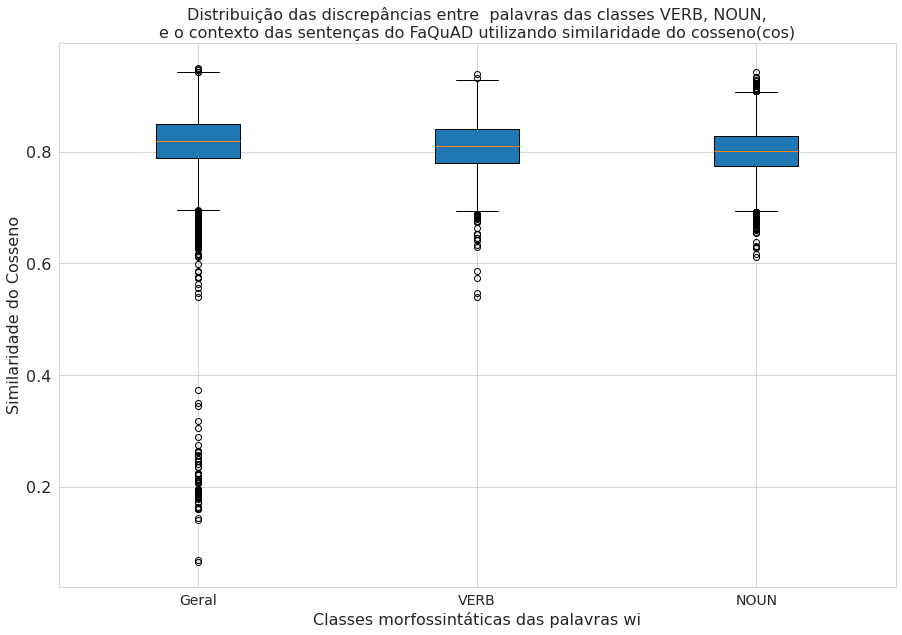

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count    19484.000000     2030.000000     4491.000000
mean        22.374614       24.089145       23.211993
std          3.544850        3.874788        3.169754
min         11.003908       11.439407       11.380696
25%         20.002136       21.625501       21.303830
50%         22.098861       24.009188       23.036470
75%         24.398975       26.449080       25.023160
max         43.372269       41.847027       41.371395

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


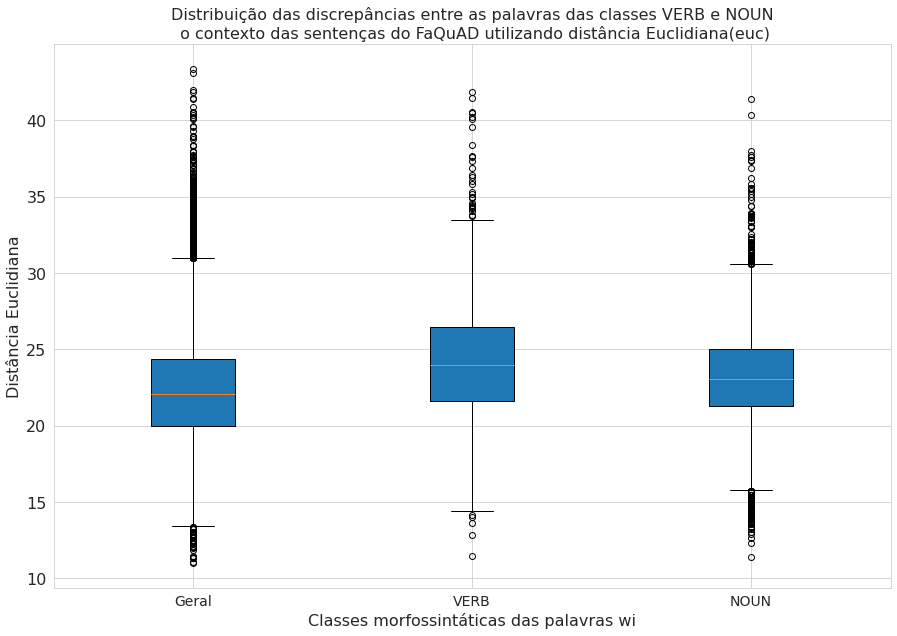

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count    19484.000000     2030.000000     4491.000000
mean      1081.124375     1156.557244     1097.051105
std        160.831247      176.752080      142.993978
min        531.921000      546.874760      545.380860
25%        974.710802     1048.039500     1010.102785
50%       1071.673200     1151.918350     1089.222000
75%       1176.337975     1272.766575     1181.027100
max       2096.301800     2096.301800     1802.809400

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


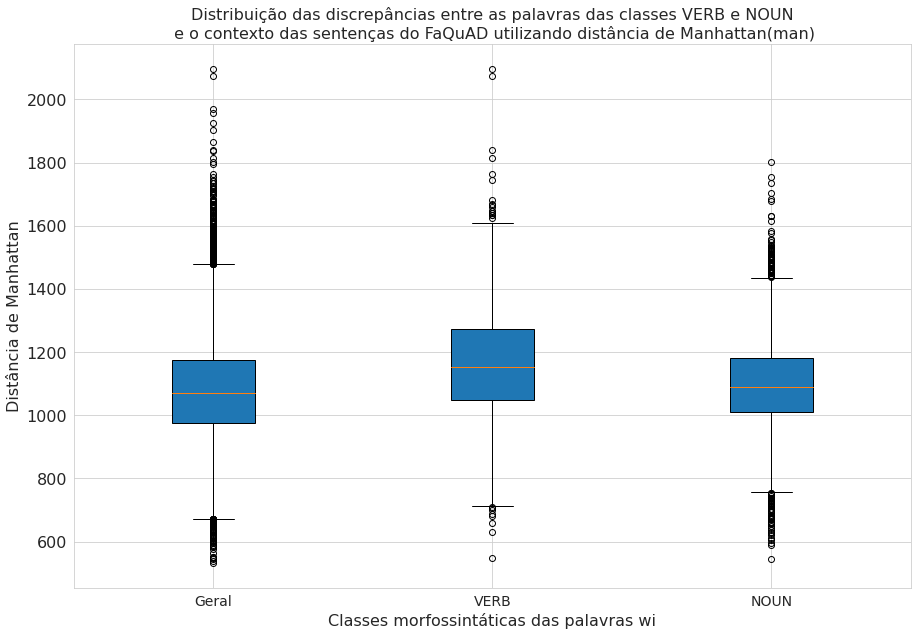

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2030


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        2030.000000        2030.000000       2030.000000   
mean            0.808555          24.014782          0.794152   
std             0.053060           3.591461          0.055498   
min             0.508645          14.396695          0.508645   
25%             0.776866          21.589018          0.760628   
50%             0.813965          24.083946          0.798898   
75%             0.846238          26.114501          0.834047   
max             0.928156          41.019470          0.928156   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       2030.000000       2030.000000        2030.000000  
mean          25.076496       1203.341596        1152.353868  
std            3.369728        163.169418         170.211290  
min           15.135900        728.473450         701.138800  
25%           23.010351       1102.439475        1034.169650  
50%           24.900990       1196.028100        1151.318900  
75%           26.902776       1293.983025        1255.178200  
max           41.765808       2148.943000        2052.186800

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2030 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2  322
      2        4  287
      3        3  255
      4        5  219
      5        6  204
      6        1  165
      7        7  160
      8        8  104
      9        9   77
     10       10   56
     11       11   40
     12       12   36
     13       13   29
     14       14   26
     15       15   14
     16        0    8
     17       16    8
     18       20    4
     19       18    4
     20       41    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06937173008918762
Limite superior             : 0.9502957314252853
Limite inferior             : 0.6728088110685349


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 29 de 2030 ( 0.014285714285714285 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  29 de 2030 ( 0.014285714285714285 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 2 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 3 0.5326684713363647 ver
         Quem é mesmo o autor da frase ” Ciência da Computação tem tanto a ver com o computador como a astronomia com o telescópio [ … ] " ?

 4 0.5430207252502441 ver
         Quem é considerado o autor da frase ”Ciência da Computação tem tanto a ver com o computador como a astronomia com o telescópio […]"?

 5 0.5529261827468872 quer
         O que quer dizer quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que fazer caso o aluno perca o prazo de seleção de disciplinas online?
       1 0.7916213274002075 perca
       2 0.6711822152137756 fazer

 2 O que dizem os portadores de traumatismos ?
       1 0.6689513921737671 dizem

 3 Quais os resultados finais que devem ser registrados para trabalho de conclusão de curso?
       1 0.7679919600486755 registrados
       2 0.6673991680145264 devem

 4 Qual um dos modelos de pós-graduação do Brasil que se parece com o do norte-americano ?
       1 0.6661950349807739 parece

 5 Desde quando os processadores vêm sendo construídos em um único circuito integrado?
       1 0.8615039587020874 integrado
       2 0.8441484570503235 construídos
       3 0.6593529582023621 vêm


##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07341882586479187
Limite superior             : 0.9441751092672348
Limite inferior             : 0.6504998058080673


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 34 de 2030 ( 0.016748768472906402 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  34 de 2030 ( 0.016748768472906402 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 2 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 3 0.5326684713363647 ver
         Quem é mesmo o autor da frase ” Ciência da Computação tem tanto a ver com o computador como a astronomia com o telescópio [ … ] " ?

 4 0.5338222980499268 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?

 5 0.5398828983306885 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 A quem o acadêmico deve ir para fazer suas avaliações acadêmicas ?
       1 0.7407531142234802 deve
       2 0.7288326025009155 fazer
       3 0.6477971076965332 ir

 2 A quem é credita a frase "Ciência é para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos"?
       1 0.6829000115394592 é
       2 0.6474058032035828 credita

 3 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 0.6861923336982727 beneficiarão
       2 0.6457883715629578 financiadas
       3 0.5885996222496033 passava
       4 0.563040018081665 Há
       5 0.5398828983306885 constituírem-se

 4 Qual a base da análise e interpretação dos dados coletados a partir da observação de fatos e fenômenos exatamente como ocorem realmente?

##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.525482654571533
Limite superior             : 32.902724504470825
Limite inferior             : 14.800793886184692


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 32 de 2030 ( 0.015763546798029555 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 2030 ( 0.0004926108374384236 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  33 de 2030 ( 0.01625615763546798 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.01947021484375 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 40.69407272338867 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 38.22304534912109 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 4 38.22304534912109 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 5 37.6559944152832 ficaram
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos t

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 14.396695137023926 ensinava
         O que Eduba ensinava?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.01947021484375 Há
       2 36.82670211791992 passava
       3 24.80210494995117 beneficiarão
       4 24.76762962341309 financiadas
       5 24.708553314208984 constituírem-se

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 40.69407272338867 Há
       2 36.36716842651367 passava
       3 35.13206100463867 transformar
       4 25.089223861694336 financiadas
       5 24.920652389526367 beneficiarão

 3 O que quer dizer Tota

##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.892425537109375
Limite superior             : 32.74141454696655
Limite inferior             : 17.171712398529053


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 44 de 2030 ( 0.02167487684729064 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 11 de 2030 ( 0.00541871921182266 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  55 de 2030 ( 0.027093596059113302 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.76580810546875 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 41.01947021484375 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 40.69407272338867 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.135899543762209 ensinar
         O que é ensinar um professor ?

 2 15.547289848327637 fica
         Onde fica o MIT?

 3 15.547289848327637 fica
         Onde fica o MIT ?

 4 16.28989028930664 disse
         O que Hollerith disse ?

 5 16.439367294311523 luta
         Pelo que o MIT luta ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.76580810546875 constituírem-se
       2 41.01947021484375 Há
       3 36.82670211791992 passava
       4 30.58774757385254 financiadas
       5 30.50898551940918 beneficiarão

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.76580810546875 constituírem-se
       2 41.01947021484375 Há
       3 36.82670211791992 passava
       4 30.58774757385254 financiadas
       5 30.50898551940918 beneficiarão

 3 De quem foram as palav

##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 221.00855
Limite superior             : 1586.691025
Limite inferior             : 702.656825


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 26 de 2030 ( 0.012807881773399015 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 2030 ( 0.0004926108374384236 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  27 de 2030 ( 0.013300492610837438 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2052.1868 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2032.3551 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1848.9463 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 4 1848.9463 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 5 1816.616 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 701.1388 ensinava
         O que Eduba ensinava?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2052.1868 Há
       2 1816.616 passava
       3 1233.0063 beneficiarão
       4 1210.4642 financiadas
       5 1192.9916 constituírem-se

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 2032.3551 Há
       2 1793.5057 passava
       3 1699.0708 transformar
       4 1240.4424 beneficiarão
       5 1235.4128 financiadas

 3 O que quer dizer Total de Alunos Equivalentes da Graduação?
       1 1848.9463 quer
       2 1530.0881 di

##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 191.54354999999987
Limite superior             : 1581.2983499999998
Limite inferior             : 815.1241500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 38 de 2030 ( 0.0187192118226601 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 11 de 2030 ( 0.00541871921182266 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  49 de 2030 ( 0.02413793103448276 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2148.943 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2052.1868 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 2032.3551 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 4 2010.2942 debruç

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 728.47345 ensinar
         O que é ensinar um professor ?

 2 752.0896 fica
         Onde fica o MIT?

 3 752.0896 fica
         Onde fica o MIT ?

 4 775.79456 luta
         Pelo que o MIT luta ?

 5 781.35596 disse
         O que Hollerith disse ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2148.943 constituírem-se
       2 2052.1868 Há
       3 1816.616 passava
       4 1499.8363 financiadas
       5 1492.6699 beneficiarão

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2148.943 constituírem-se
       2 2052.1868 Há
       3 1816.616 passava
       4 1499.8363 financiadas
       5 1492.6699 beneficiarão

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade ir

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 4491


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        4491.000000        4491.000000       4491.000000   
mean            0.826021          21.720722          0.814516   
std             0.046443           3.308261          0.054917   
min             0.577471          12.273237          0.577471   
25%             0.801362          19.556680          0.785147   
50%             0.831467          21.374775          0.823971   
75%             0.858462          23.476480          0.853456   
max             0.947550          38.564785          0.947550   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       4491.000000       4491.000000        4491.000000  
mean          22.509644       1066.782767        1029.586626  
std            3.556362        167.741339         153.835969  
min           12.273237        599.121640         599.121640  
25%           20.078531        950.002700         928.483585  
50%           22.067444       1042.219200        1010.660900  
75%           24.497017       1163.840700        1112.478600  
max           38.564785       1795.649400        1795.649400

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/4491 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  584
      2        5  545
      3        4  490
      4        6  419
      5        2  408
      6        7  385
      7        8  349
      8        9  294
      9        1  238
     10       10  157
     11       11  152
     12       12  111
     13       13   87
     14       14   62
     15       15   42
     16       17   38
     17        0   29
     18       16   29
     19       18   18
     20       19   14


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05709952116012573
Limite superior             : 0.9441112577915192
Limite inferior             : 0.7157131731510162


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 4491 ( 0.00022266755733689602 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 116 de 4491 ( 0.025829436651079937 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  117 de 4491 ( 0.026052104208416832 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9475498795509338 cursos
         Os cursos de pós-graduação são quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.577470600605011 partir
         a partir de quando o semestre de posicionamento é obrigatório ?

 2 0.5824059247970581 partir
         A partir de qual momento o tempo gasto será contabilizado ?

 3 0.5844500064849854 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 4 0.5908647179603577 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 5 0.5987075567245483 partir
         A partir de qual momento o tempo cursado será contabilizado?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Compreender diferentes formas de pesquisa nos preocupa com o quê ?
       1 0.8162012100219727 pesquisa
       2 0.8024546504020691 formas
       3 0.7152829766273499 quê

 2 Que tipo de trabalho é oferecido nos cursos de mestrado ?
       1 0.860249936580658 mestrado
       2 0.8598376512527466 trabalho
       3 0.8476399183273315 cursos
       4 0.7151427268981934 tipo

 3 Por que a contagem do tempo acadêmico é feita a partir do ingresso do acadêmico na UFMS ?
       1 0.8483459949493408 acadêmico
       2 0.7784586548805237 UFMS
       3 0.7763203382492065 ingresso
       4 0.7666493654251099 contagem
       5 0.7150131464004517 tempo

 4 O que foi feito no distrito federal em cumprimento a lei número 347 ?
       1 0.8333979249000549 lei
       2 0.817905843257904 distrito
       3 0.7924209237098694 cumprimento
       4 0.7146806716918945 número

 5 Quem é mesmo o autor da frase ” Ciência da Computação tem tanto a ver com o computador como a astronomia com o telescópio [ … ] 

##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06830880045890808
Limite superior             : 0.9559187740087509
Limite inferior             : 0.6826835721731186


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 4491 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 116 de 4491 ( 0.025829436651079937 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  116 de 4491 ( 0.025829436651079937 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.577470600605011 partir
         a partir de quando o semestre de posicionamento é obrigatório ?

 2 0.5824059247970581 partir
         A partir de qual momento o tempo gasto será contabilizado ?

 3 0.5844500064849854 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 4 0.5908647179603577 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 5 0.5987075567245483 partir
         A partir de qual momento o tempo cursado será contabilizado?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Com quem o computador moderno começou a ganhar forma?
       1 0.8207013607025146 computador
       2 0.6809452176094055 forma

 2 Qual era o número de mestrados acadêmicos no Brasil em 2017?
       1 0.7750033736228943 mestrados
       2 0.6807809472084045 número

 3 O trancamento de matrícula deve ser feito caso o regime de exercícios domicilares for superior a quantos semestres?
       1 0.8357316255569458 regime
       2 0.8060399293899536 exercícios
       3 0.720211923122406 semestres
       4 0.6807295083999634 matrícula
       5 0.6265331506729126 trancamento

 4 O que deve ser incluído no plano de estudos referente ao curso na UFMS ?
       1 0.8445814251899719 curso
       2 0.8236294388771057 plano
       3 0.801093339920044 estudos
       4 0.680568277835846 UFMS

 5 O que deve ser incluído no plano de estudos referente ao curso na UFMS?
       1 0.8445814251899719 curso
       2 0.8236294388771057 plano
       3 0.801093339920044 estudos
       4 0.680568277835846 UFMS

##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.9197998046875
Limite superior             : 29.356179237365723
Limite inferior             : 13.676980018615723


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 134


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 10 de 4491 ( 0.00222667557336896 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  144 de 4491 ( 0.03206412825651302 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.56478500366211 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 37.56013870239258 forma
         Por que o estágio é a mais procurada forma dentre as opções de atividade complementar de extensão?

 3 37.43052291870117 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 4 37.31269836425781 partir
         a partir de quando o semestre de posicionamento é obrigatório ?

 5 36.68947982788086 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 12.273237228393556 cursos
         Os cursos de pós-graduação são quais cursos ?

 2 12.974133491516112 FAPDF
         O que é a FAPDF?

 3 13.0888032913208 calculador
         O que era o calculador analítico?

 4 13.3550386428833 FAPDF
         O que a FAPDF faz ?

 5 13.391727447509766 ensino
         Quem faz o ensino superior ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 38.56478500366211 r
       2 27.17686462402344 software
       3 26.24933242797852 série
       4 24.81010055541992 flexibilidade
       5 24.689817428588867 pacotes
       6 23.685056686401367 inovações
       7 22.346424102783203 terminais

 2 Por que o estágio é a mais procurada forma dentre as opções de atividade complementar de extensão?
       1 37.56013870239258 forma
       2 24.61330223083496 estágio
       3 22.914533615112305 opções
       4 22.2696533203125 extensão
       5 20.406307220458984 atividade

 3 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 37.43052291870117 teorema
       2 24.632577896118164 conceitos
       3 23.274038314819336 cálculo
       4 21.903743743896484 definição
       5 20.111438751220703 recursividade

 4 a partir de quando o semestre de posicionamento é obrigatório ?
       

##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.418485641479492
Limite superior             : 31.12474536895752
Limite inferior             : 13.45080280303955


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 86


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 4491 ( 0.0006680026720106881 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  89 de 4491 ( 0.019817412602983746 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.56478500366211 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 37.56013870239258 forma
         Por que o estágio é a mais procurada forma dentre as opções de atividade complementar de extensão?

 3 37.43052291870117 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 4 37.31269836425781 partir
         a partir de quando o semestre de posicionamento é obrigatório ?

 5 36.68947982788086 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 12.273237228393556 cursos
         Os cursos de pós-graduação são quais cursos ?

 2 13.391727447509766 ensino
         Quem faz o ensino superior ?

 3 13.43045711517334 lógica
         O que é a lógica lógica e aritmética ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 38.56478500366211 r
       2 29.12591552734375 flexibilidade
       3 27.17686462402344 software
       4 26.24933242797852 série
       5 24.689817428588867 pacotes
       6 23.685056686401367 inovações
       7 22.346424102783203 terminais

 2 Por que o estágio é a mais procurada forma dentre as opções de atividade complementar de extensão?
       1 37.56013870239258 forma
       2 24.61330223083496 estágio
       3 22.914533615112305 opções
       4 22.2696533203125 extensão
       5 20.406307220458984 atividade

 3 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 37.43052291870117 teorema
       2 26.137348175048828 recursividade
       3 24.632577896118164 conceitos
       4 23.274038314819336 cálculo
       5 21.903743743896484 definição

 4 a partir de quando o semestre de posicionamento é obrigatório ?
       

##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 183.99501499999997
Limite superior             : 1388.4711224999999
Limite inferior             : 652.4910625


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 129


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 8 de 4491 ( 0.0017813404586951682 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  137 de 4491 ( 0.030505455355154754 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1795.6494 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 1792.2598 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1765.1887 partir
         a partir de quando o semestre de posicionamento é obrigatório ?

 4 1755.0007 meio
         por meio de quem as instituições de ensino superior devem definir as atribuições e os critérios de constituição do nde ?

 5 1755.0007 meio
         por meio de quem as instituições de ensino superior devem definir as atribuiç

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 599.12164 cursos
         Os cursos de pós-graduação são quais cursos ?

 2 623.1835 calculador
         O que era o calculador analítico?

 3 626.3518 lógica
         O que é a lógica lógica e aritmética ?

 4 632.21704 FAPDF
         O que é a FAPDF?

 5 639.00037 triagem
         O que é a triagem?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1795.6494 tempo
       2 1498.9393 realidade
       3 1476.863 sonho
       4 1459.5476 garantia
       5 1437.8235 palavras
       6 1417.2161 resultados
       7 1380.8345 fatos
       8 1375.4146 futuro
       9 1283.0126 pesquisas
       10 1260.7996 idealistas
       11 1214.7797 moradores

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 1792.2598 tempo
       2 1473.824 realidade
       3 1452.8452 garantia
       4 144

##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 213.83799999999997
Limite superior             : 1484.5976999999998
Limite inferior             : 629.2457


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 81


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 4491 ( 0.00044533511467379205 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  83 de 4491 ( 0.01848140725896237 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1795.6494 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 1792.2598 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1765.1887 partir
         a partir de quando o semestre de posicionamento é obrigatório ?

 4 1755.0007 meio
         por meio de quem as instituições de ensino superior devem definir as atribuições e os critérios de constituição do nde?

 5 1755.0007 meio
         por meio de quem as instituições de ensino superior devem definir as atribuiçõ

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 599.12164 cursos
         Os cursos de pós-graduação são quais cursos ?

 2 626.3518 lógica
         O que é a lógica lógica e aritmética ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1795.6494 tempo
       2 1532.5779 idealistas
       3 1498.9393 realidade
       4 1476.863 sonho
       5 1459.5476 garantia
       6 1437.8235 palavras
       7 1417.2161 resultados
       8 1380.8345 fatos
       9 1375.4146 futuro
       10 1283.0126 pesquisas
       11 1214.7797 moradores

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 1792.2598 tempo
       2 1521.6997 idealistas
       3 1473.824 realidade
       4 1

#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count      19484.000000      19484.000000     19484.000000     19484.000000   
mean           0.792178         23.597984         0.783791        24.181075   
std            0.066217          3.688474         0.067041         3.623004   
min            0.090934          0.000000         0.090934         0.000000   
25%            0.757515         21.183445         0.749039        21.804601   
50%            0.797423         23.491816         0.789015        24.026958   
75%            0.834170         25.809036         0.826040        26.303487   
max            1.000000         41.346760         1.000000        45.882721   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count     19484.000000      19484.000000       2030.000000       2030.000000   
mean       1165.280997       1137.434708          0.808555         24.014782   
std         175.309036        178.953528          0.053060          3.591461   
min           0.000000          0.000000          0.508645         14.396695   
25%        1050.094525       1018.019650          0.776866         21.589018   
50%        1159.470150       1134.756700          0.813965         24.083946   
75%        1270.705300       1250.062775          0.846238         26.114501   
max        2389.520500       2052.186800          0.928156         41.019470   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count      2030.000000      2030.000000      2030.000000       2030.000000   
mean          0.794152        25.076496      1203.341596       1152.353868   
std           0.055498         3.369728       163.169418        170.211290   
min           0.508645        15.135900       728.473450        701.138800   
25%           0.760628        23.010351      1102.439475       1034.169650   
50%           0.798898        24.900990      1196.028100       1151.318900   
75%           0.834047        26.902776      1293.983025       1255.178200   
max           0.928156        41.765808      2148.943000       2052.186800   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count       4491.000000       4491.000000      4491.000000      4491.000000   
mean           0.826021         21.720722         0.814516        22.509644   
std            0.046443          3.308261         0.054917         3.556362   
min            0.577471         12.273237         0.577471        12.273237   
25%            0.801362         19.556680         0.785147        20.078531   
50%            0.831467         21.374775         0.823971        22.067444   
75%            0.858462         23.476480         0.853456        24.497017   
max            0.947550         38.564785         0.947550        38.564785   

                                          
      man_ctxclean_max man_ctxclean_mean  
count      4491.000000       4491.000000  
mean       1066.782767       1029.586626  
std         167.741339        153.835969  
min         599.121640        599.121640  
25%         950.002700        928.483585  
50%        1042.219200       1010.660900  
75%        1163.840700       1112.478600  
max        1795.649400       1795.649400

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count      19484.000000       2030.000000       4491.000000
mean           0.792178          0.808555          0.826021
std            0.066217          0.053060          0.046443
min            0.090934          0.508645          0.577471
25%            0.757515          0.776866          0.801362
50%            0.797423          0.813965          0.831467
75%            0.834170          0.846238          0.858462
max            1.000000          0.928156          0.947550

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


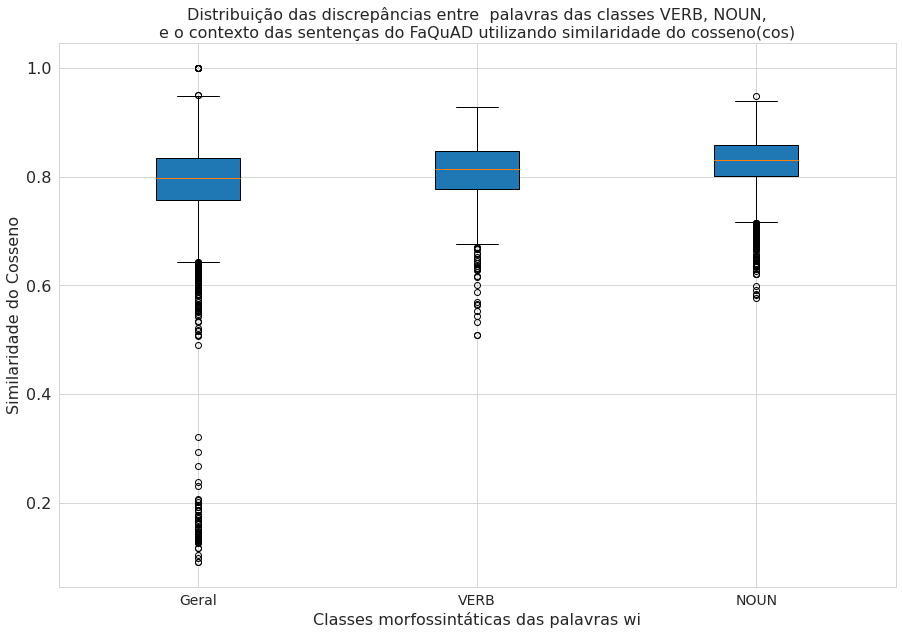

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count      19484.000000       2030.000000       4491.000000
mean          23.597984         24.014782         21.720722
std            3.688474          3.591461          3.308261
min            0.000000         14.396695         12.273237
25%           21.183445         21.589018         19.556680
50%           23.491816         24.083946         21.374775
75%           25.809036         26.114501         23.476480
max           41.346760         41.019470         38.564785

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


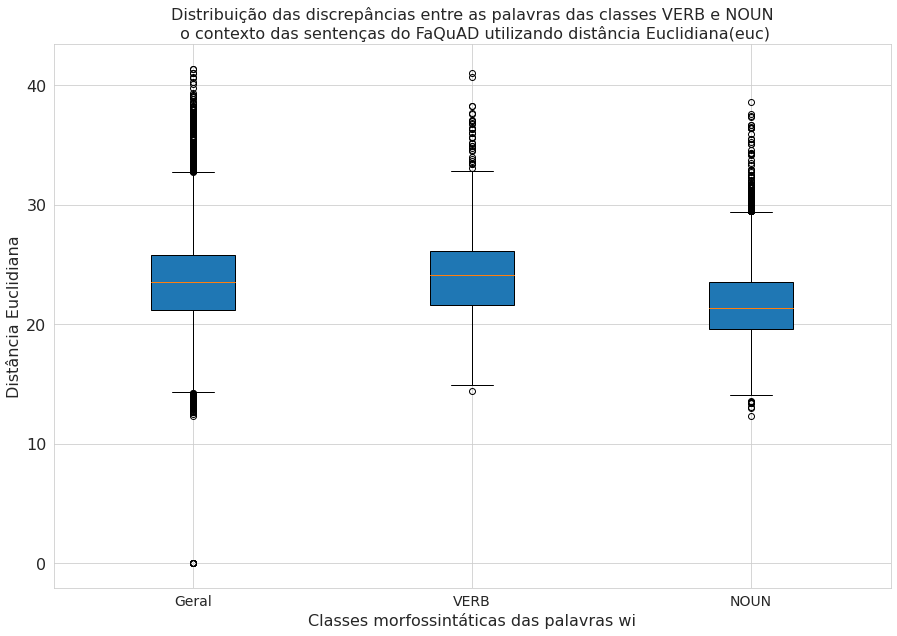

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count      19484.000000       2030.000000       4491.000000
mean        1137.434708       1152.353868       1029.586626
std          178.953528        170.211290        153.835969
min            0.000000        701.138800        599.121640
25%         1018.019650       1034.169650        928.483585
50%         1134.756700       1151.318900       1010.660900
75%         1250.062775       1255.178200       1112.478600
max         2052.186800       2052.186800       1795.649400

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


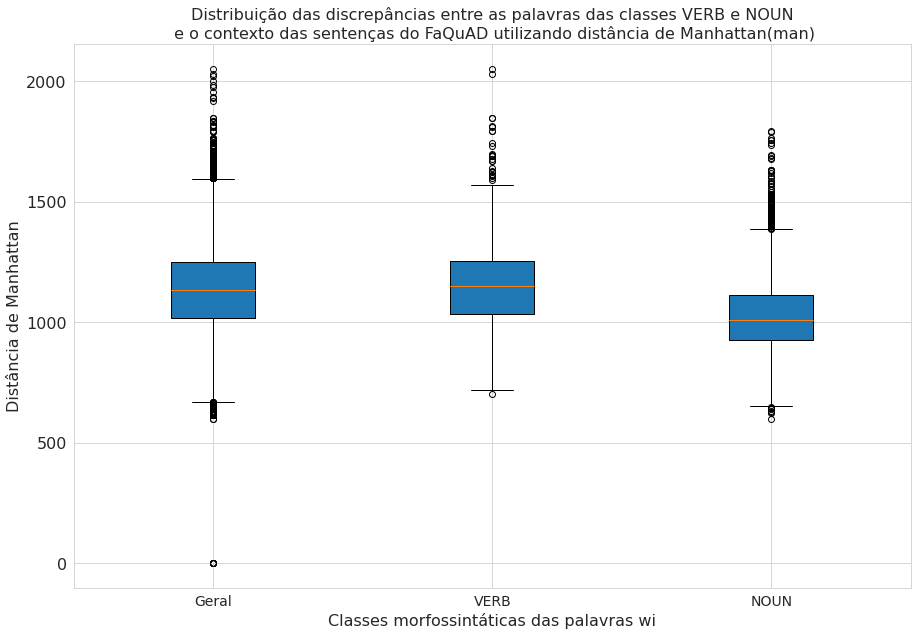

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2030


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       2030.000000       2030.000000       2030.000000      2030.000000   
mean           0.918171         13.905131        670.062459         0.903505   
std            0.058822          8.258279        398.052768         0.070988   
min            0.626744          0.000000          0.000000         0.546779   
25%            0.879928         12.676439        615.228943         0.866038   
50%            0.918653         16.286005        780.261597         0.912133   
75%            0.946714         19.302178        934.008011         0.939424   
max            1.000000         38.669708       1946.588623         1.000000   

       euc_ctxverb_max  man_ctxverb_max  
count      2030.000000      2030.000000  
mean         15.474836       746.659517  
std           8.510497       412.027770  
min           0.000000         0.000000  
25%          13.975241       676.092667  
50%          16.923749       815.029572  
75%          20.929525      1004.876511  
max          41.658283      2155.059082

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2030 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2  322
      2        4  287
      3        3  255
      4        5  219
      5        6  204
      6        1  165
      7        7  160
      8        8  104
      9        9   77
     10       10   56
     11       11   40
     12       12   36
     13       13   29
     14       14   26
     15       15   14
     16        0    8
     17       16    8
     18       20    4
     19       18    4
     20       41    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06678596138954163
Limite superior             : 1.046893134713173
Limite inferior             : 0.7797492891550064


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 29 de 2030 ( 0.014285714285714285 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  29 de 2030 ( 0.014285714285714285 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6267440319061279 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.6327266097068787 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.6792885661125183 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que quer dizer quando um professor opta por ensinar a sua matéria através de seminários ao invés de provas ?
       1 0.8899499773979187 dizer
       2 0.8549140095710754 quer
       3 0.7793856859207153 opta
       4 0.7582378387451172 ensinar

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 0.7782677412033081 constituírem-se
       2 0.7537190914154053 beneficiarão
       3 0.7428333759307861 financiadas
       4 0.6792885661125183 passava
       5 0.6267440319061279 Há

 3 O que acontece caso o acadêmico não renove a matrícula e estiver impedido de trancar?
       1 0.8778311610221863 renove
       2 0.8495268821716309 trancar
       3 0.7755675315856934 acontece

 4 A quem pode ser solicitado o aproveitamento das discipl

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07338646054267883
Limite superior             : 1.0495041012763977
Limite inferior             : 0.7559582591056824


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 70 de 2030 ( 0.034482758620689655 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  70 de 2030 ( 0.034482758620689655 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5467785000801086 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5979099273681641 cursadas
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 3 0.6085227131843567 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?

 4 0.6267440319061279 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futu

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem é considerado o autor da frase ”Ciência da Computação tem tanto a ver com o computador como a astronomia com o telescópio […]"?
       1 0.8652015924453735 tem
       2 0.8362191319465637 considerado
       3 0.7556886672973633 ver

 2 O que acontece caso o acadêmico não realizar a matrícula e estiver impedido de trancar ?
       1 0.865534782409668 realizar
       2 0.7572372555732727 trancar
       3 0.7552430033683777 acontece

 3 O candidato deve ter um vinculo efetivo com quem para se matricular sem passar pelo exame de seleção?
       1 0.8831613063812256 ter
       2 0.8555675745010376 deve
       3 0.8174008727073669 passar
       4 0.7542820572853088 matricular

 4 O candidato deve ter um vinculo efetivo com quem para se matricular sem passar pelo exame de seleção ?
       1 0.8831613063812256 ter
       2 0.8555675745010376 deve
       3 0.8174008727073669 passar
       4 0.7542820572853088 matricular

 5 Em qual semestre o acadêmico deve ser enquadrado no caso de ex

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.625739336013794
Limite superior             : 29.240786910057068
Limite inferior             : 2.737829566001892


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 15 de 2030 ( 0.007389162561576354 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 472 de 2030 ( 0.23251231527093597 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  487 de 2030 ( 0.2399014778325123 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.669708251953125 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 38.29826354980469 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 33.380943298339844 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?



###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 automatizam
         O que as soluções tecnológicas automatizam?

 2 0.0 Ocorre
         Ocorre uma interação entre quem nas hora-aula?

 3 0.0 compõem
         Qual o prazo mínimo para a divulgação das notas de todas as avaliações que compõem a média de aproveitamento ?

 4 0.0 comporão
         Qual o prazo mínimo para a divulgação das notas de todas as avaliações que comporão a média de aproveitamento?

 5 0.0 depende
         Do que a aprovação nas disciplinas depende?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 38.669708251953125 Há
       2 33.380943298339844 passava
       3 25.1396427154541 beneficiarão
       4 24.942777633666992 constituírem-se
       5 24.596269607543945 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 38.29826354980469 Há
       2 33.37413787841797 transformar
       3 32.8276481628418 passava
       4 25.460529327392575 financiadas
       5 25.42159080505371 beneficiarão

 3 De quem foram as pala

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.9542839527130145
Limite superior             : 31.360950827598575
Limite inferior             : 3.5438150167465157


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 20 de 2030 ( 0.009852216748768473 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 389 de 2030 ( 0.1916256157635468 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  409 de 2030 ( 0.20147783251231527 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.65828323364258 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 38.669708251953125 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 38.29826354980469 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasíli

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 oferecem
         O que as soluções tecnológicas oferecem ?

 2 0.0 possui
         O doutorado possui duração média de quatro anos para a realização de quê?

 3 0.0 avalia
         O que avalia a capacidade de redação de textos científicos do aluno nos trabalhos autônomos ?

 4 0.0 evidencia
         O que evidencia a capacidade de redação de textos científicos do aluno nos trabalhos autônomos?

 5 0.0 oferece
         Qual fundação do estado de São Paulo oferece bolsas de doutorado no exterior ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.65828323364258 constituírem-se
       2 38.669708251953125 Há
       3 33.380943298339844 passava
       4 30.69848251342773 beneficiarão
       5 30.34163475036621 financiadas

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.65828323364258 constituírem-se
       2 38.669708251953125 Há
       3 33.380943298339844 passava
       4 30.69848251342773 beneficiarão
       5 30.34163475036621 financiadas

 3 De quem foram as p

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 318.7790679931642
Limite superior             : 1412.1766128540041
Limite inferior             : 137.06034088134749


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 14 de 2030 ( 0.006896551724137931 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 472 de 2030 ( 0.23251231527093597 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  486 de 2030 ( 0.23940886699507388 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1946.588623046875 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 1923.420654296875 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1637.361083984375 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 4

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 automatizam
         O que as soluções tecnológicas automatizam?

 2 0.0 Ocorre
         Ocorre uma interação entre quem nas hora-aula?

 3 0.0 compõem
         Qual o prazo mínimo para a divulgação das notas de todas as avaliações que compõem a média de aproveitamento ?

 4 0.0 comporão
         Qual o prazo mínimo para a divulgação das notas de todas as avaliações que comporão a média de aproveitamento?

 5 0.0 depende
         Do que a aprovação nas disciplinas depende?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1946.588623046875 Há
       2 1637.361083984375 passava
       3 1245.264404296875 beneficiarão
       4 1224.3861083984375 constituírem-se
       5 1214.782470703125 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 1923.420654296875 Há
       2 1614.451416015625 transformar
       3 1612.451904296875 passava
       4 1263.1129150390625 financiadas
       5 1259.54541015625 beneficiarão

 3 De quem foram as palavr

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 328.7838439941406
Limite superior             : 1498.0522766113281
Limite inferior             : 182.91690063476562


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 25 de 2030 ( 0.012315270935960592 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 389 de 2030 ( 0.1916256157635468 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  414 de 2030 ( 0.20394088669950738 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2155.05908203125 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 1946.588623046875 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 1923.420654296875 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília 

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 oferecem
         O que as soluções tecnológicas oferecem ?

 2 0.0 possui
         O doutorado possui duração média de quatro anos para a realização de quê?

 3 0.0 avalia
         O que avalia a capacidade de redação de textos científicos do aluno nos trabalhos autônomos ?

 4 0.0 evidencia
         O que evidencia a capacidade de redação de textos científicos do aluno nos trabalhos autônomos?

 5 0.0 oferece
         Qual fundação do estado de São Paulo oferece bolsas de doutorado no exterior ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2155.05908203125 constituírem-se
       2 1946.588623046875 Há
       3 1637.361083984375 passava
       4 1511.4544677734375 financiadas
       5 1510.836669921875 beneficiarão

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2155.05908203125 constituírem-se
       2 1946.588623046875 Há
       3 1637.361083984375 passava
       4 1511.4544677734375 financiadas
       5 1510.836669921875 beneficiarão

 3 De quem foram as palav

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 4491


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       4053.000000       4053.000000       4053.000000      4053.000000   
mean           0.643465         32.517560       1545.522578         0.633954   
std            0.069186          4.061905        184.491885         0.071970   
min            0.387621         21.070621       1010.455994         0.387621   
25%            0.595422         29.623922       1419.823120         0.582744   
50%            0.646098         32.276436       1540.080688         0.637328   
75%            0.693847         35.059002       1668.983398         0.686874   
max            0.825155         50.967281       2227.109619         0.825155   

       euc_ctxverb_max  man_ctxverb_max  
count      4053.000000      4053.000000  
mean         33.091396      1572.410942  
std           4.069833       186.459184  
min          22.208706      1048.865356  
25%          30.278234      1439.095215  
50%          32.895458      1568.671387  
75%          35.749149      1701.798096  
max          50.967281      2227.109619

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/4491 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  584
      2        5  545
      3        4  490
      4        6  419
      5        2  408
      6        7  385
      7        8  349
      8        9  294
      9        1  238
     10       10  157
     11       11  152
     12       12  111
     13       13   87
     14       14   62
     15       15   42
     16       17   38
     17        0   29
     18       16   29
     19       18   18
     20       19   14


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 4491 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 4491 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 4491 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 4491 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 4491 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 4491 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 4491 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 4491 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 4491 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 4491 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 4491 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 4491 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 4491 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 4491 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count     17994.000000     17994.000000     17994.000000    17994.000000   
mean          0.713665        28.077130      1354.733408        0.706503   
std           0.123048         8.560336       405.978342        0.125455   
min           0.032986         0.000000         0.000000        0.032986   
25%           0.634740        25.347880      1237.774017        0.626816   
50%           0.699320        29.568674      1436.848938        0.694504   
75%           0.771240        33.302788      1604.211426        0.768070   
max           1.000000        53.025936      2238.714355        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count    17994.000000    17994.000000      2030.000000      2030.000000   
mean        28.587188     1379.115730         0.918171        13.905131   
std          8.500056      402.416144         0.058822         8.258279   
min          0.000000        0.000000         0.626744         0.000000   
25%         25.609435     1251.085754         0.879928        12.676439   
50%         29.987413     1454.140381         0.918653        16.286005   
75%         33.779559     1625.119843         0.946714        19.302178   
max         53.025936     2580.427734         1.000000        38.669708   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count      2030.000000     2030.000000     2030.000000     2030.000000   
mean        670.062459        0.903505       15.474836      746.659517   
std         398.052768        0.070988        8.510497      412.027770   
min           0.000000        0.546779        0.000000        0.000000   
25%         615.228943        0.866038       13.975241      676.092667   
50%         780.261597        0.912133       16.923749      815.029572   
75%         934.008011        0.939424       20.929525     1004.876511   
max        1946.588623        1.000000       41.658283     2155.059082   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count      4053.000000      4053.000000      4053.000000     4053.000000   
mean          0.643465        32.517560      1545.522578        0.633954   
std           0.069186         4.061905       184.491885        0.071970   
min           0.387621        21.070621      1010.455994        0.387621   
25%           0.595422        29.623922      1419.823120        0.582744   
50%           0.646098        32.276436      1540.080688        0.637328   
75%           0.693847        35.059002      1668.983398        0.686874   
max           0.825155        50.967281      2227.109619        0.825155   

                                       
      euc_ctxverb_max man_ctxverb_max  
count     4053.000000     4053.000000  
mean        33.091396     1572.410942  
std          4.069833      186.459184  
min         22.208706     1048.865356  
25%         30.278234     1439.095215  
50%         32.895458     1568.671387  
75%         35.749149     1701.798096  
max         50.967281     2227.109619

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count     17994.000000      2030.000000      4053.000000
mean          0.713665         0.918171         0.643465
std           0.123048         0.058822         0.069186
min           0.032986         0.626744         0.387621
25%           0.634740         0.879928         0.595422
50%           0.699320         0.918653         0.646098
75%           0.771240         0.946714         0.693847
max           1.000000         1.000000         0.825155

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


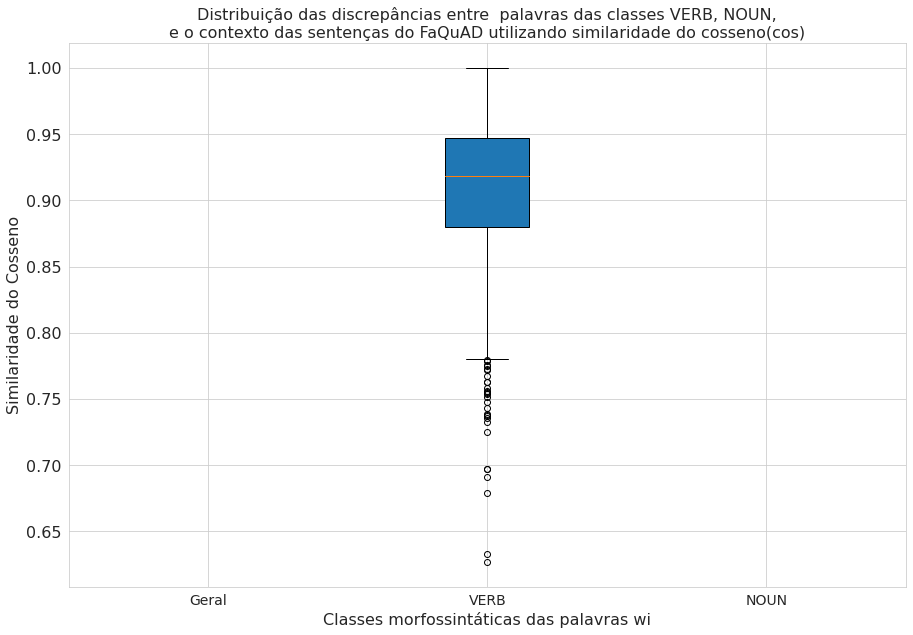

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count     17994.000000      2030.000000      4053.000000
mean         28.077130        13.905131        32.517560
std           8.560336         8.258279         4.061905
min           0.000000         0.000000        21.070621
25%          25.347880        12.676439        29.623922
50%          29.568674        16.286005        32.276436
75%          33.302788        19.302178        35.059002
max          53.025936        38.669708        50.967281

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


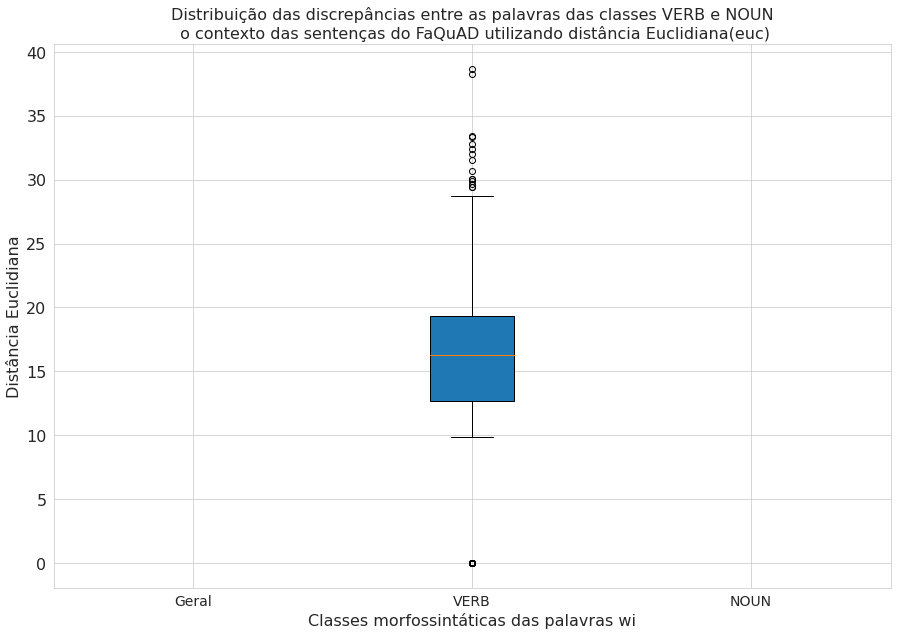

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count     17994.000000      2030.000000      4053.000000
mean       1354.733408       670.062459      1545.522578
std         405.978342       398.052768       184.491885
min           0.000000         0.000000      1010.455994
25%        1237.774017       615.228943      1419.823120
50%        1436.848938       780.261597      1540.080688
75%        1604.211426       934.008011      1668.983398
max        2238.714355      1946.588623      2227.109619

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


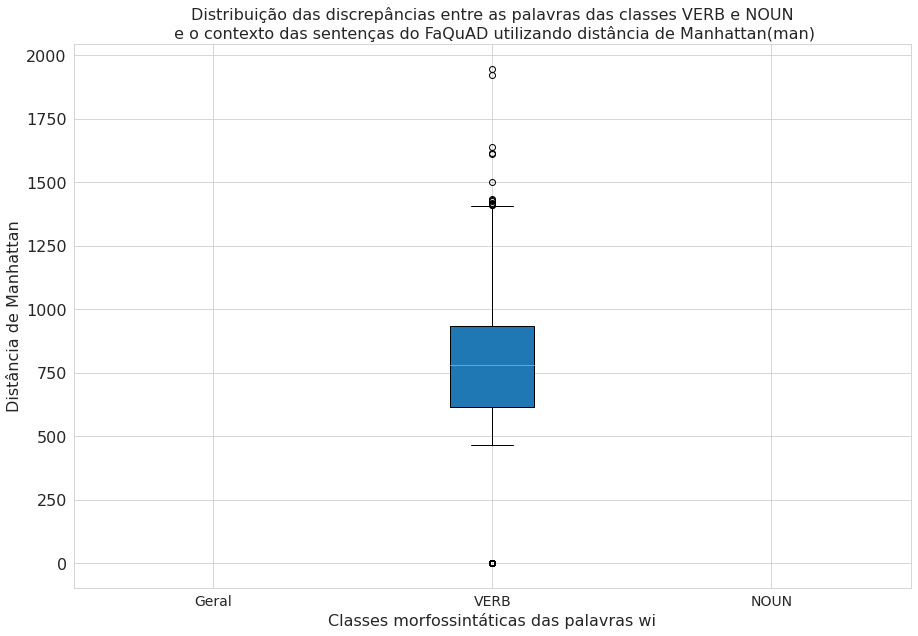

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2030


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       1958.000000       1958.000000       1958.000000      1958.000000   
mean           0.679279         30.859522       1473.374949         0.666424   
std            0.060737          3.747309        173.714185         0.059720   
min            0.449301         21.020739        990.989319         0.438007   
25%            0.640523         28.378601       1356.249573         0.630327   
50%            0.683220         30.670193       1467.096436         0.671240   
75%            0.724212         33.045288       1577.578156         0.707324   
max            0.826893         48.707672       2188.519287         0.826829   

       euc_ctxnoun_max  man_ctxnoun_max  
count      1958.000000      1958.000000  
mean         31.716097      1514.408375  
std           3.446687       161.923757  
min          21.597652      1026.994629  
25%          29.379535      1405.173004  
50%          31.396749      1504.260864  
75%          33.665613      1603.726868  
max          48.707672      2239.623535

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2030 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2  322
      2        4  287
      3        3  255
      4        5  219
      5        6  204
      6        1  165
      7        7  160
      8        8  104
      9        9   77
     10       10   56
     11       11   40
     12       12   36
     13       13   29
     14       14   26
     15       15   14
     16        0    8
     17       16    8
     18       20    4
     19       18    4
     20       41    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2030 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2030 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2030 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2030 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2030 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2030 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2030 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2030 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2030 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2030 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2030 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2030 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2030 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 4491


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       4491.000000       4491.000000       4491.000000      4491.000000   
mean           0.877929         17.637761        833.741134         0.866137   
std            0.055823          6.084048        286.363307         0.065020   
min            0.637471          0.000000          0.000000         0.591252   
25%            0.841923         15.775094        745.289490         0.830060   
50%            0.876271         18.451187        874.080261         0.868917   
75%            0.910004         21.072151        999.607971         0.906780   
max            1.000000         39.985626       1705.408447         1.000000   

       euc_ctxnoun_max  man_ctxnoun_max  
count      4491.000000      4491.000000  
mean         18.603745       879.603474  
std           6.223806       294.324832  
min           0.000000         0.000000  
25%          16.300100       771.302124  
50%          19.186712       906.463684  
75%          22.073004      1045.429016  
max          39.985626      1775.009766

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/4491 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  584
      2        5  545
      3        4  490
      4        6  419
      5        2  408
      6        7  385
      7        8  349
      8        9  294
      9        1  238
     10       10  157
     11       11  152
     12       12  111
     13       13   87
     14       14   62
     15       15   42
     16       17   38
     17        0   29
     18       16   29
     19       18   18
     20       19   14


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06808045506477356
Limite superior             : 1.0121244341135025
Limite inferior             : 0.7398026138544083


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 4491 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 33 de 4491 ( 0.007348029392117568 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  33 de 4491 ( 0.007348029392117568 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6374713778495789 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.6431444883346558 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.6653438806533813 caso
         o que acontece com o acadêmico com vínculo trancado em caso de não renovação de sua matrícula no semestre seguinte ?

 4 0.6653438806533813 caso
         o que acontece com o acadêmico com vínculo trancado em caso de não renovação de sua matrícula no semestre seguinte?

 5 0.6741862297058105 

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual é o nome dado à máquina que calcula polinômios por meio de diferenças?
       1 0.8506723046302795 diferenças
       2 0.8327732086181641 meio
       3 0.8168724179267883 máquina
       4 0.7871445417404175 polinômios
       5 0.7392746806144714 nome

 2 Qual é o nome dado à máquina que calcula polinômios por meio de diferenças ?
       1 0.8506723046302795 diferenças
       2 0.8327732086181641 meio
       3 0.8168724179267883 máquina
       4 0.7871445417404175 polinômios
       5 0.7392746806144714 nome

 3 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.8500844836235046 terminais
       2 0.8437162637710571 pacotes
       3 0.8216538429260254 inovações
       4 0.8064146637916565 série
       5 0.7677285671234131 flexibilidade
       6 0.7537640333175659 r
       7 0.7359054088592529 software

 4 por meio de quem as instituições de ensino superior devem definir as atribuições e os critérios de

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06808045506477356
Limite superior             : 1.0121244341135025
Limite inferior             : 0.7398026138544083


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 4491 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 33 de 4491 ( 0.007348029392117568 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  33 de 4491 ( 0.007348029392117568 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6374713778495789 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.6431444883346558 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.6653438806533813 caso
         o que acontece com o acadêmico com vínculo trancado em caso de não renovação de sua matrícula no semestre seguinte ?

 4 0.6653438806533813 caso
         o que acontece com o acadêmico com vínculo trancado em caso de não renovação de sua matrícula no semestre seguinte?

 5 0.6741862297058105 

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual é o nome dado à máquina que calcula polinômios por meio de diferenças?
       1 0.8506723046302795 diferenças
       2 0.8327732086181641 meio
       3 0.8168724179267883 máquina
       4 0.7871445417404175 polinômios
       5 0.7392746806144714 nome

 2 Qual é o nome dado à máquina que calcula polinômios por meio de diferenças ?
       1 0.8506723046302795 diferenças
       2 0.8327732086181641 meio
       3 0.8168724179267883 máquina
       4 0.7871445417404175 polinômios
       5 0.7392746806144714 nome

 3 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.8500844836235046 terminais
       2 0.8437162637710571 pacotes
       3 0.8216538429260254 inovações
       4 0.8064146637916565 série
       5 0.7677285671234131 flexibilidade
       6 0.7537640333175659 r
       7 0.7359054088592529 software

 4 por meio de quem as instituições de ensino superior devem definir as atribuições e os critérios de

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.297057628631592
Limite superior             : 29.01773762702942
Limite inferior             : 7.829507112503052


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 47


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 330 de 4491 ( 0.07348029392117568 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  377 de 4491 ( 0.0839456691160098 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.985626220703125 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 35.8665885925293 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 3 34.89761734008789 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?

 4 34.82576370239258 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 5 34.80305480957031 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais prom

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas automatizam?

 2 0.0 calendário
         O calendário acadêmico é aprovado por quem?

 3 0.0 professor
         O que é ensinar um professor ?

 4 0.0 professor
         O que pode ensinar um professor?

 5 0.0 professors
         O que os professors no Reino Unido geralmente fazem ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 39.985626220703125 r
       2 25.55392837524414 série
       3 25.27204704284668 software
       4 23.92705726623535 flexibilidade
       5 22.568384170532227 inovações
       6 22.421924591064453 pacotes
       7 20.425464630126957 terminais

 2 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 35.8665885925293 teorema
       2 23.57611656188965 conceitos
       3 23.104921340942383 cálculo
       4 21.580026626586918 recursividade
       5 20.9023380279541 definição

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?
       1 34.89761734008789 inicial
       2 31.011964797973636 caso
       3 29.57746124267578 carga
       4 24.63001251220703 p

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.7729034423828125
Limite superior             : 30.732358932495117
Limite inferior             : 7.640745162963867


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 52


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 277 de 4491 ( 0.0616789133823202 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  329 de 4491 ( 0.07325762636383878 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.985626220703125 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 36.30638122558594 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?

 3 36.21663284301758 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 4 35.8665885925293 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 5 35.01934814453125 interveniência
         Pelo que a instituição de ensino zela com a interveniência da celebração do contrato?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas automatizam?

 2 0.0 professor
         Junior professor é equivalente ao que nos EUA?

 3 0.0 ministério
         Pelo que é responsável o ministério da educação em Portugal?

 4 0.0 níveis
         Quais são os níveis educacionais?

 5 0.0 objetivos
         Quais são os objetivos educacionais ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 39.985626220703125 r
       2 28.39739990234375 flexibilidade
       3 25.55392837524414 série
       4 25.27204704284668 software
       5 22.568384170532227 inovações
       6 22.421924591064453 pacotes
       7 20.425464630126957 terminais

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?
       1 36.30638122558594 pré-requisitos
       2 34.89761734008789 inicial
       3 31.011964797973636 caso
       4 29.57746124267578 carga
       5 22.85964012145996 disciplinas
       6 22.422313690185547 acadêmico
       7 20.89442443847656 semestre
       8 20.286989212036133 semestre

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de s

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 254.3184814453125
Limite superior             : 1381.085693359375
Limite inferior             : 363.811767578125


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 27


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 330 de 4491 ( 0.07348029392117568 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  357 de 4491 ( 0.07949231796927188 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1705.408447265625 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 1697.614013671875 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1689.938720703125 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 4 1622.3699951171875 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 5 1579.75732421875 caso
         o que acontece com o acadê

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 2 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 3 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 4 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 5 0.0 soluções
         O que as soluções tecnológicas automatizam?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1705.408447265625 tempo
       2 1408.889404296875 garantia
       3 1407.61181640625 palavras
       4 1391.689697265625 realidade
       5 1327.529052734375 fatos
       6 1325.8167724609375 resultados
       7 1319.6343994140625 sonho
       8 1287.0753173828125 futuro
       9 1251.50634765625 pesquisas
       10 1237.653076171875 moradores
       11 1228.777587890625 idealistas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
   

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 274.12689208984375
Limite superior             : 1456.6193542480469
Limite inferior             : 360.1117858886719


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 45


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 277 de 4491 ( 0.0616789133823202 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  322 de 4491 ( 0.07169895346248052 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1775.009765625 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?

 2 1770.369873046875 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 3 1705.408447265625 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 4 1697.614013671875 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma re

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 2 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 3 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 4 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 5 0.0 professor
         O que pode ensinar um professor?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?
       1 1775.009765625 pré-requisitos
       2 1547.5325927734375 inicial
       3 1491.02099609375 caso
       4 1413.575927734375 carga
       5 1047.3621826171875 disciplinas
       6 1039.0869140625 acadêmico
       7 1013.7238159179688 semestre
       8 964.5949096679688 semestre

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?
       1 1770.369873046875 pré-requisitos
       2 1544.31298828125 inicial
       3 1490.265380859375 caso
       4 1405.537353515625 carga
       5 1056.001708984375 disciplinas
       6 1045.419677734375 acadêmico
       7 1012.9235229492188 semestre
      

#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count     18688.000000     18688.000000     18688.000000    18688.000000   
mean          0.731839        26.589417      1275.449198        0.724314   
std           0.109719         6.815917       329.202985        0.109905   
min           0.060114         0.000000         0.000000        0.060114   
25%           0.659994        23.458511      1122.554291        0.654012   
50%           0.721344        27.637681      1332.076782        0.715003   
75%           0.797876        30.895934      1490.483459        0.787063   
max           1.000000        52.020824      2521.047119        1.000000   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count    18688.000000    18688.000000      1958.000000      1958.000000   
mean        27.118432     1300.548293         0.679279        30.859522   
std          6.692019      322.957234         0.060737         3.747309   
min          0.000000        0.000000         0.449301        21.020739   
25%         24.106368     1158.800659         0.640523        28.378601   
50%         27.992985     1347.794373         0.683220        30.670193   
75%         31.242631     1505.767517         0.724212        33.045288   
max         52.020824     2549.512207         0.826893        48.707672   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count      1958.000000     1958.000000     1958.000000     1958.000000   
mean       1473.374949        0.666424       31.716097     1514.408375   
std         173.714185        0.059720        3.446687      161.923757   
min         990.989319        0.438007       21.597652     1026.994629   
25%        1356.249573        0.630327       29.379535     1405.173004   
50%        1467.096436        0.671240       31.396749     1504.260864   
75%        1577.578156        0.707324       33.665613     1603.726868   
max        2188.519287        0.826829       48.707672     2239.623535   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count      4491.000000      4491.000000      4491.000000     4491.000000   
mean          0.877929        17.637761       833.741134        0.866137   
std           0.055823         6.084048       286.363307        0.065020   
min           0.637471         0.000000         0.000000        0.591252   
25%           0.841923        15.775094       745.289490        0.830060   
50%           0.876271        18.451187       874.080261        0.868917   
75%           0.910004        21.072151       999.607971        0.906780   
max           1.000000        39.985626      1705.408447        1.000000   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count     4491.000000     4491.000000  
mean        18.603745      879.603474  
std          6.223806      294.324832  
min          0.000000        0.000000  
25%         16.300100      771.302124  
50%         19.186712      906.463684  
75%         22.073004     1045.429016  
max         39.985626     1775.009766

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count     18688.000000      1958.000000      4491.000000
mean          0.731839         0.679279         0.877929
std           0.109719         0.060737         0.055823
min           0.060114         0.449301         0.637471
25%           0.659994         0.640523         0.841923
50%           0.721344         0.683220         0.876271
75%           0.797876         0.724212         0.910004
max           1.000000         0.826893         1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


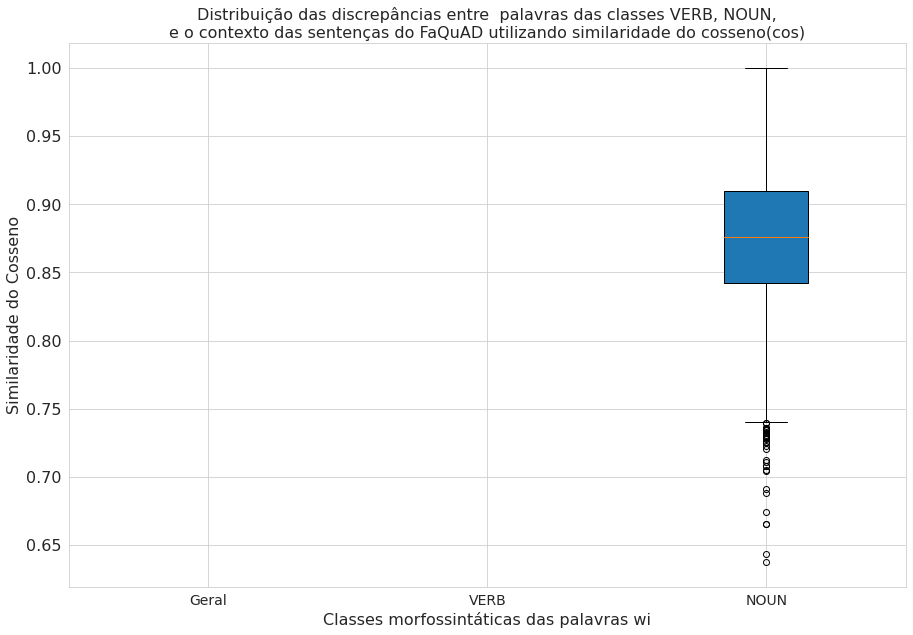

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count     18688.000000      1958.000000      4491.000000
mean         26.589417        30.859522        17.637761
std           6.815917         3.747309         6.084048
min           0.000000        21.020739         0.000000
25%          23.458511        28.378601        15.775094
50%          27.637681        30.670193        18.451187
75%          30.895934        33.045288        21.072151
max          52.020824        48.707672        39.985626

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


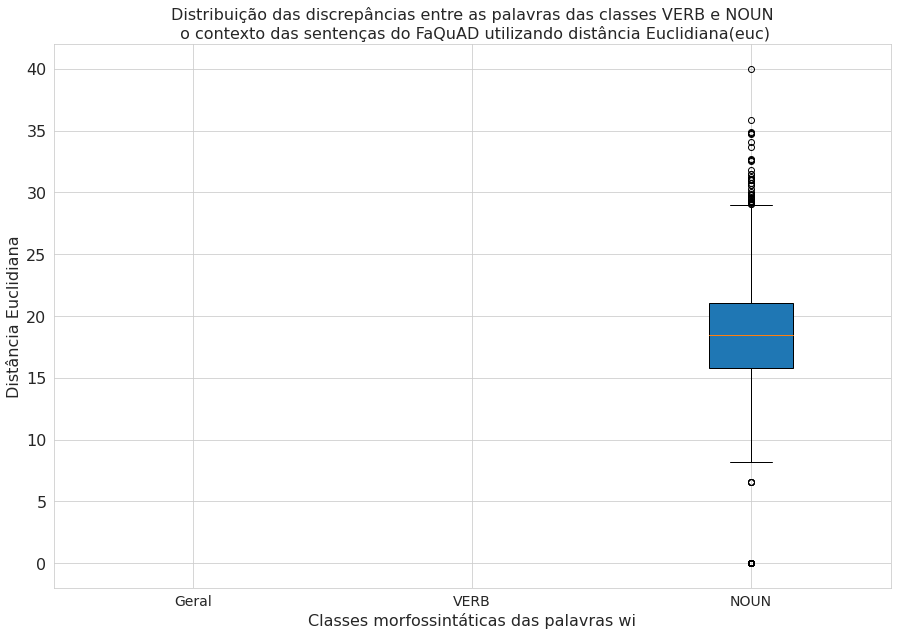

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count     18688.000000      1958.000000      4491.000000
mean       1275.449198      1473.374949       833.741134
std         329.202985       173.714185       286.363307
min           0.000000       990.989319         0.000000
25%        1122.554291      1356.249573       745.289490
50%        1332.076782      1467.096436       874.080261
75%        1490.483459      1577.578156       999.607971
max        2521.047119      2188.519287      1705.408447

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


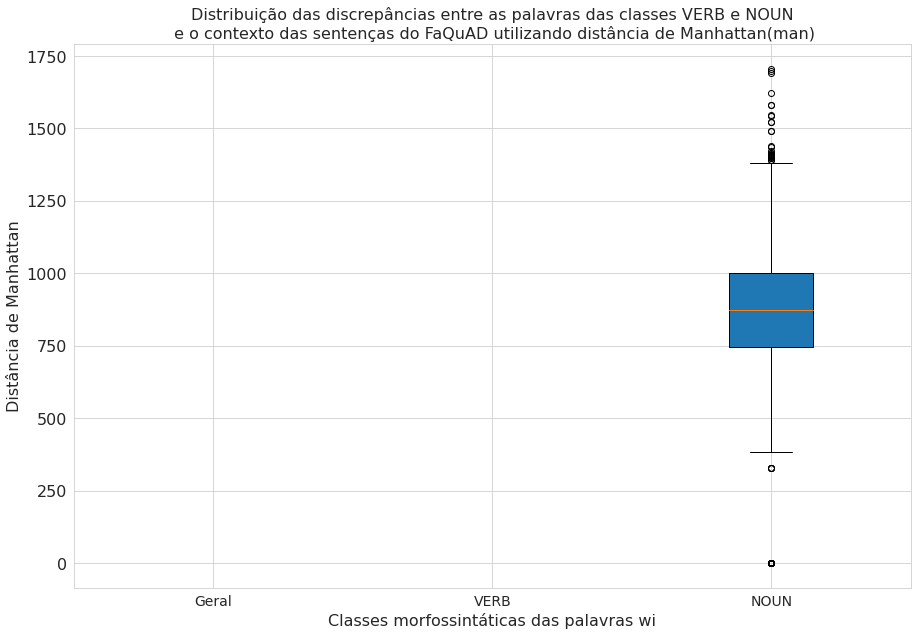

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2030


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           2030.000000           2030.000000           2030.000000   
mean               0.846837             21.578331           1033.255459   
std                0.047452              4.203370            198.820514   
min                0.574439              0.000000              0.000000   
25%                0.820311             19.433904            927.031311   
50%                0.847418             21.602020           1038.107544   
75%                0.876529             23.814099           1137.587097   
max                1.000000             40.630005           2030.208618   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          2030.000000          2030.000000          2030.000000  
mean              0.832374            22.685783          1086.755113  
std               0.056602             4.376967           210.520642  
min               0.528096             0.000000             0.000000  
25%               0.801168            20.432496           977.615845  
50%               0.836820            22.652303          1082.953308  
75%               0.867483            25.219602          1212.922058  
max               1.000000            42.210827          2168.713379

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2030 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2  322
      2        4  287
      3        3  255
      4        5  219
      5        6  204
      6        1  165
      7        7  160
      8        8  104
      9        9   77
     10       10   56
     11       11   40
     12       12   36
     13       13   29
     14       14   26
     15       15   14
     16        0    8
     17       16    8
     18       20    4
     19       18    4
     20       41    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05621720850467682
Limite superior             : 0.9608544930815697
Limite inferior             : 0.7359856590628624


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 21 de 2030 ( 0.010344827586206896 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 34 de 2030 ( 0.016748768472906402 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  55 de 2030 ( 0.027093596059113302 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 diz
         O que diz a Tese de Church-Turing?

 2 1.0 contribuiu
         À que Turing contribuiu?

 3 1.0 ensinava
         O que Eduba ensinava?

 4 1.0 localiza
         Onde se localiza a CBC ?

 5 1.0 localiza
         Onde se localiza a CBC?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5744385719299316 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.580807089805603 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.6221528649330139 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?



###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 como é realizada a seleção de alunos para uma disciplina cujo número de inscritos supera o número de vagas ?
       1 0.7594188451766968 supera
       2 0.7333250641822815 realizada

 2 Quem disse que o Brasil já conta com cursos de doutorado de qualidade suficiente ?
       1 0.7929031848907471 conta
       2 0.7328592538833618 disse

 3 O que acontece caso o candidato não compareça no prazo estabelecido em edital para matrícula ?
       1 0.8011607527732849 compareça
       2 0.7734241485595703 estabelecido
       3 0.7326989769935608 acontece

 4 O que acontece caso o candidato não compareça no prazo estabelecido em edital para matrícula?
       1 0.8011607527732849 compareça
       2 0.7734241485595703 estabelecido
       3 0.7326989769935608 acontece

 5 O que acontece com os alunos que não conseguiram vaga na turma pretendida?
       1 0.8152518272399902 pretendida
       2 0.8088378310203552 conseguiram
       3 0.7325160503387451 acontece


##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06631563603878021
Limite superior             : 0.9669568464159966
Limite inferior             : 0.7016943022608757


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 18 de 2030 ( 0.008866995073891626 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 35 de 2030 ( 0.017241379310344827 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  53 de 2030 ( 0.026108374384236452 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 diz
         O que diz a Tese de Church-Turing?

 2 1.0 contribuiu
         À que Turing contribuiu?

 3 1.0 localiza
         Onde se localiza a CBC ?

 4 1.0 localiza
         Onde se localiza a CBC?

 5 1.0 significa
         O que significa R & D?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5280957221984863 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5697070956230164 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos poderiam ser resolvidos por um método efetivo?

 3 0.5744385719299316 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 4 0.580807089805603 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é 

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que acontece caso o Aluno Especial não requeira o aproveitamento das duas disciplinas cursadas até a data de matrícula?
       1 0.7298691868782043 requeira
       2 0.6970316767692566 acontece
       3 0.6807191371917725 cursadas

 2 Qual o prazo mínimo para a divulgação das notas de todas as avaliações que comporão a média de aproveitamento?
       1 0.6963618397712708 comporão

 3 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.7883914113044739 ficaram
       2 0.6918312907218933 combinados
       3 0.677154541015625 trazidas

 4 O que quer dizer quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas?
       1 0.8066263794898987 avaliar
       2 0.7703883051872253 dizer
       3 0.7179056406021118 quer
       4 0.6883153319358826 opta

 5 Por que a contagem do tempo cursado é feita a partir do ingresso do acadêmico na UFMS?
       1 0.7985131740570068 feita
   

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.380194664001465
Limite superior             : 30.384390830993652
Limite inferior             : 12.863612174987793


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 37 de 2030 ( 0.018226600985221674 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 25 de 2030 ( 0.012315270935960592 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  62 de 2030 ( 0.030541871921182268 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.6300048828125 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 40.273075103759766 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 38.211334228515625 participando
         O que a UFMS visa participando do ensino e da preservação dos recursos naturais do meio ambiente?

 4 37.45152282714844 ficaram
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 5 36.736961364746094 conhecidas
    

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 diz
         O que diz a Tese de Church-Turing?

 2 0.0 fez
         O que Eduba fez ?

 3 0.0 ensinava
         O que Eduba ensinava?

 4 0.0 localiza
         Onde se localiza a CBC ?

 5 0.0 localiza
         Onde se localiza a CBC?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 40.6300048828125 Há
       2 35.62832260131836 passava
       3 25.78634452819824 constituírem-se
       4 25.13725852966309 beneficiarão
       5 24.633655548095703 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 40.273075103759766 Há
       2 35.23343276977539 transformar
       3 35.1844482421875 passava
       4 25.26169776916504 beneficiarão
       5 25.13746833801269 financiadas

 3 O que a UFMS visa partic

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.787106513977047
Limite superior             : 32.40026187896728
Limite inferior             : 13.251835823059087


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 30 de 2030 ( 0.014778325123152709 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 28 de 2030 ( 0.013793103448275862 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  58 de 2030 ( 0.02857142857142857 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.2108268737793 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 40.6300048828125 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 40.273075103759766 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília 

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 diz
         O que diz a Tese de Church-Turing?

 2 0.0 fez
         O que Eduba fez ?

 3 0.0 localiza
         Onde se localiza a CBC ?

 4 0.0 localiza
         Onde se localiza a CBC?

 5 0.0 significa
         O que significa R & D?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 42.2108268737793 constituírem-se
       2 40.6300048828125 Há
       3 35.62832260131836 passava
       4 30.727807998657227 beneficiarão
       5 30.41559600830078 financiadas

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 42.2108268737793 constituírem-se
       2 40.6300048828125 Há
       3 35.62832260131836 passava
       4 30.727807998657227 beneficiarão
       5 30.41559600830078 financiadas

 3 De quem foram as palavra

##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 210.5557861328125
Limite superior             : 1453.4207763671875
Limite inferior             : 611.1976318359375


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 30 de 2030 ( 0.014778325123152709 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 23 de 2030 ( 0.011330049261083743 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  53 de 2030 ( 0.026108374384236452 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2030.2086181640625 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2008.721923828125 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1757.154052734375 passava
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 610.6240234375 criada
         Quando Eduba foi criada?

 2 597.020751953125 preso
         Quando Eduba foi preso ?

 3 566.200439453125 acompanha
         O que o Siscad controla, acompanha e divulga?

 4 0.0 luta
         Pelo que o MIT luta ?

 5 0.0 fez
         O que Eduba fez ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2030.2086181640625 Há
       2 1757.154052734375 passava
       3 1245.537353515625 beneficiarão
       4 1240.8685302734375 constituírem-se
       5 1215.226806640625 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 2008.721923828125 Há
       2 1737.2327880859375 passava
       3 1693.26708984375 transformar
       4 1251.5830078125 beneficiarão
       5 1240.13671875 financiadas

 3 De quem foram as palavras “H

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 235.30621337890636
Limite superior             : 1565.8813781738284
Limite inferior             : 624.6565246582029


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 21 de 2030 ( 0.010344827586206896 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 28 de 2030 ( 0.013793103448275862 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  49 de 2030 ( 0.02413793103448276 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2168.71337890625 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2030.2086181640625 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 2008.721923828125 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 622.8912963867188 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 2 622.8912963867188 dizer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 3 622.8912963867188 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 4 622.8912963867188 dizer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 5 619.4071044921875 estudou
         Quais matérias Al-Azhar estudou ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2168.71337890625 constituírem-se
       2 2030.2086181640625 Há
       3 1757.154052734375 passava
       4 1508.5843505859375 beneficiarão
       5 1506.8321533203125 financiadas

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2168.71337890625 constituírem-se
       2 2030.2086181640625 Há
       3 1757.154052734375 passava
       4 1508.5843505859375 beneficiarão
       5 1506.8321533203125 financiadas

 3 De quem foram as p

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 4491


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           4491.000000           4491.000000           4491.000000   
mean               0.840634             20.804033            985.775226   
std                0.045643              3.443445            159.129159   
min                0.619692              0.000000              0.000000   
25%                0.811309             18.656158            887.111450   
50%                0.842754             20.726318            983.997803   
75%                0.871863             22.814786           1079.098145   
max                1.000000             38.187222           1692.941406   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          4491.000000          4491.000000          4491.000000  
mean              0.829200            21.598898          1023.338360  
std               0.056479             3.833368           179.955914  
min               0.567776             0.000000             0.000000  
25%               0.797606            19.144484           908.966064  
50%               0.836384            21.399677          1013.699036  
75%               0.867516            23.881825          1127.960754  
max               1.000000            38.187222          1739.203857

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/4491 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  584
      2        5  545
      3        4  490
      4        6  419
      5        2  408
      6        7  385
      7        8  349
      8        9  294
      9        1  238
     10       10  157
     11       11  152
     12       12  111
     13       13   87
     14       14   62
     15       15   42
     16       17   38
     17        0   29
     18       16   29
     19       18   18
     20       19   14


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06055402755737305
Limite superior             : 0.9626942873001099
Limite inferior             : 0.7204781770706177


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 11 de 4491 ( 0.002449343130705856 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 48 de 4491 ( 0.01068804275217101 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  59 de 4491 ( 0.013137385882876865 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 objetivo
         Qual o principal objetivo da PBL?

 2 1.0 objetivo
         Qual o principal objetivo da PBL ?

 3 1.0 objetivo
         Qual o objetivo do Redecomep?

 4 1.0 objetivo
         Qual o objetivo do Redecomep ?

 5 1.0 monografia
         O que a monografia visa?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6196915507316589 gestação
         Gestantes poderão ser ajudadas pelo regime de exercícios a partir de qual mês de gestação?

 2 0.6434865593910217 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 0.6480161547660828 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 4 0.6566773056983948 pesquisas
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um

###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano a comunidade científica do distrito federal iniciou a criação de uma instituição dedicada ao incentivo da ciência e tecnologia?
       1 0.8449985384941101 instituição
       2 0.8184460997581482 incentivo
       3 0.8023094534873962 criação
       4 0.7706045508384705 ano
       5 0.7406225800514221 comunidade
       6 0.7198275923728943 ciência
       7 0.7151050567626953 tecnologia
       8 0.7051663994789124 distrito

 2 A quem é credita a frase "Ciência é para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos"?
       1 0.8222848176956177 hidrodinâmica
       2 0.7611042857170105 construção
       3 0.7486582398414612 Ciência
       4 0.7424194812774658 encanamentos
       5 0.7194133996963501 frase

 3 A resolução nº 342 regula recorre o quê ?
       1 0.8140038847923279 resolução
       2 0.7669848799705505 quê
       3 0.7165746092796326 nº

 4 Qual foi a necessidade que fez a lei da criação da FAPDF ser alterada pela lei nº 3

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0699106752872467
Limite superior             : 0.9723824113607407
Limite inferior             : 0.6927397102117538


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 10 de 4491 ( 0.00222667557336896 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 99 de 4491 ( 0.022044088176352707 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  109 de 4491 ( 0.024270763749721664 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 objetivo
         Qual o principal objetivo da PBL?

 2 1.0 objetivo
         Qual o principal objetivo da PBL ?

 3 1.0 objetivo
         Qual o objetivo do Redecomep?

 4 1.0 objetivo
         Qual o objetivo do Redecomep ?

 5 1.0 objetivo
         Qual o objetivo do POSCOMP?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5677760243415833 gestação
         Gestantes poderão ser ajudadas pelo regime de exercícios a partir de qual mês de gestação?

 2 0.6057502627372742 FAPDF
         A FAPDF tem finalidade de estimular , apoiar e promover o desenvolvimento científico de qual âmbito ?

 3 0.6057502627372742 FAPDF
         A FAPDF tem finalidade de estimular, apoiar e promover o desenvolvimento científico de qual âmbito?

 4 0.6134248375892639 gestação
         Gestantes podem ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 5 0.614751398563385 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual ano os alunos de colação de grau poderão ser incluídos em disciplinas sem que tenham cumprido todos os pré-requisitos ?
       1 0.863727867603302 alunos
       2 0.8261926770210266 ano
       3 0.804959774017334 disciplinas
       4 0.6919621825218201 grau
       5 0.6234142184257507 pré-requisitos
       6 0.6231014132499695 colação

 2 Para quem foi criado os programas de “consciencialização gerencial”?
       1 0.8496769070625305 programas
       2 0.6914367079734802 consciencialização

 3 Gestantes podem ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?
       1 0.8297199010848999 regime
       2 0.7807201147079468 mês
       3 0.7745853662490845 exercícios
       4 0.7398561835289001 partir
       5 0.6911606788635254 Gestantes
       6 0.6134248375892639 gestação

 4 Onde a FAPDF se consolidou?
       1 0.8867596983909607 Onde
       2 0.6906870603561401 FAPDF

 5 Como ficaram r a série de inovações trazidas pelos pacotes de software combinado

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.158627510070801
Limite superior             : 29.052727222442627
Limite inferior             : 12.418217182159424


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 73


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 21 de 4491 ( 0.004676018704074816 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  94 de 4491 ( 0.020930750389668226 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.18722152709961 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 36.58653259277344 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 3 36.44139862060547 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?

 4 36.282997131347656 posicionamento
         Quando as vagas nas disciplinas alocadas no período de posicionamento do discente não são ocupadas ?

 5 36.05983352661133 posicionamento
         Quando as vagas nas disciplinas alocadas no período de posicionamento do discente não são garantidas?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 objetivo
         Qual o principal objetivo da PBL?

 2 0.0 universidade
         Qual a universidade mais antiga do Brasil?

 3 0.0 federação
         Qual a maior federação sindical docente de Portugal?

 4 0.0 objetivo
         Qual o objetivo do POSCOMP ?

 5 0.0 objetivo
         Qual o objetivo do POSCOMP?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 38.18722152709961 r
       2 27.413108825683597 software
       3 25.91569328308105 série
       4 24.846479415893555 flexibilidade
       5 24.24504852294922 pacotes
       6 23.51732063293457 inovações
       7 22.37946128845215 terminais

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?
       1 36.58653259277344 inicial
       2 31.15399742126465 caso
       3 29.87436866760254 carga
       4 25.40226554870605 disciplinas
       5 25.11992645263672 semestre
       6 24.665264129638672 semestre
       7 24.54801177978516 acadêmico
       8 22.62177276611328 pré-requisitos

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matri

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.73734188079834
Limite superior             : 30.98783826828003
Limite inferior             : 12.03847074508667


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 62


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 16 de 4491 ( 0.0035626809173903364 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  78 de 4491 ( 0.01736806947227789 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.18722152709961 r
         Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?

 2 36.58653259277344 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 3 36.44139862060547 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?

 4 36.282997131347656 posicionamento
         Quando as vagas nas disciplinas alocadas no período de posicionamento do discente não são ocupadas ?

 5 36.05983352661133 posicionamento
         Quando as vagas nas disciplinas alocadas no período de posicionamento do discente não são garantidas?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 objetivo
         Qual o principal objetivo da PBL?

 2 0.0 objetivo
         Qual o principal objetivo da PBL ?

 3 0.0 objetivo
         Qual o objetivo do Redecomep?

 4 0.0 objetivo
         Qual o objetivo do Redecomep ?

 5 0.0 objetivo
         Qual o objetivo do POSCOMP?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram r a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 38.18722152709961 r
       2 29.120018005371094 flexibilidade
       3 27.413108825683597 software
       4 25.91569328308105 série
       5 24.24504852294922 pacotes
       6 23.51732063293457 inovações
       7 22.37946128845215 terminais

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?
       1 36.58653259277344 inicial
       2 35.030521392822266 pré-requisitos
       3 31.15399742126465 caso
       4 29.87436866760254 carga
       5 25.40226554870605 disciplinas
       6 25.11992645263672 semestre
       7 24.665264129638672 semestre
       8 24.54801177978516 acadêmico

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matr

##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 191.9866943359375
Limite superior             : 1367.0781860351562
Limite inferior             : 599.1314086914062


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 58


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 21 de 4491 ( 0.004676018704074816 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  79 de 4491 ( 0.017590737029614785 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1692.94140625 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 1689.8319091796875 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?

 3 1640.880126953125 inicial
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 4 1639.912841796875 inicial
         Em qual semestre o acadêmico deve se

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 593.8341674804688 horária
         qual a carga horária mínima do encontro presencial?

 2 583.7129516601562 atividades
         Quais atividades estão inclusas nas atividades complementares?

 3 583.7129516601562 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 4 574.7673950195312 cursos
         Os cursos de pós-graduação englobam quais cursos?

 5 565.9820556640625 cursos
         Os cursos de pós-graduação são quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1692.94140625 tempo
       2 1471.2340087890625 realidade
       3 1434.3543701171875 palavras
       4 1423.346923828125 garantia
       5 1417.270263671875 sonho
       6 1382.550048828125 fatos
       7 1381.6409912109375 resultados
       8 1364.305908203125 futuro
       9 1293.1800537109375 pesquisas
       10 1255.148681640625 idealistas
       11 1253.906982421875 moradores

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
    

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 218.99468994140625
Limite superior             : 1456.4527893066406
Limite inferior             : 580.4740295410156


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 64


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 18 de 4491 ( 0.004008016032064128 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  82 de 4491 ( 0.018258739701625473 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1739.203857421875 conférences
         Pelo que passam os membros do corpo docente antes de serem designados Maître de conférences?

 2 1713.246826171875 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?

 3 1708.328857421875 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 4 1692.94140625 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 574.7673950195312 cursos
         Os cursos de pós-graduação englobam quais cursos?

 2 565.9820556640625 cursos
         Os cursos de pós-graduação são quais cursos ?

 3 564.263671875 cursos
         Os cursos de pós-graduação englobam quais cursos?

 4 548.343017578125 sistema
         Qual o sistema de computação mais conhecido?

 5 548.343017578125 computação
         Qual o sistema de computação mais conhecido?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Pelo que passam os membros do corpo docente antes de serem designados Maître de conférences?
       1 1739.203857421875 conférences
       2 1472.08642578125 Maître
       3 1231.979248046875 corpo
       4 1085.2919921875 membros

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem realizadas ?
       1 1713.246826171875 pré-requisitos
       2 1639.912841796875 inicial
       3 1510.209228515625 caso
       4 1432.017822265625 carga
       5 1229.4334716796875 semestre
       6 1173.765380859375 semestre
       7 1139.8309326171875 acadêmico
       8 1131.82568359375 disciplinas

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?
       1 1708.3288574

#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         19479.000000         19479.000000         19479.000000   
mean              0.775870            24.438343          1177.544636   
std               0.083559             4.718724           228.282215   
min               0.050545             0.000000             0.000000   
25%               0.728096            21.531361          1031.365417   
50%               0.777519            24.623173          1193.889282   
75%               0.833138            27.230864          1321.288879   
max               1.000000            46.118202          2154.859375   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count        19479.000000        19479.000000        19479.000000   
mean             0.767972           24.971073         1202.902271   
std              0.086757            4.826918          232.797104   
min              0.050545            0.000000            0.000000   
25%              0.720981           22.110042         1060.072693   
50%              0.769854           25.082930         1215.952881   
75%              0.825954           27.672515         1341.460632   
max              1.000000           49.117348         2483.040771   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          2030.000000          2030.000000          2030.000000   
mean              0.846837            21.578331          1033.255459   
std               0.047452             4.203370           198.820514   
min               0.574439             0.000000             0.000000   
25%               0.820311            19.433904           927.031311   
50%               0.847418            21.602020          1038.107544   
75%               0.876529            23.814099          1137.587097   
max               1.000000            40.630005          2030.208618   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count         2030.000000         2030.000000         2030.000000   
mean             0.832374           22.685783         1086.755113   
std              0.056602            4.376967          210.520642   
min              0.528096            0.000000            0.000000   
25%              0.801168           20.432496          977.615845   
50%              0.836820           22.652303         1082.953308   
75%              0.867483           25.219602         1212.922058   
max              1.000000           42.210827         2168.713379   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          4491.000000          4491.000000          4491.000000   
mean              0.840634            20.804033           985.775226   
std               0.045643             3.443445           159.129159   
min               0.619692             0.000000             0.000000   
25%               0.811309            18.656158           887.111450   
50%               0.842754            20.726318           983.997803   
75%               0.871863            22.814786          1079.098145   
max               1.000000            38.187222          1692.941406   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count         4491.000000         4491.000000         4491.000000  
mean             0.829200           21.598898         1023.338360  
std              0.056479            3.833368          179.955914  
min              0.567776            0.000000            0.000000  
25%              0.797606           19.144484          908.966064  


##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count         19479.000000          2030.000000          4491.000000
mean              0.775870             0.846837             0.840634
std               0.083559             0.047452             0.045643
min               0.050545             0.574439             0.619692
25%               0.728096             0.820311             0.811309
50%               0.777519             0.847418             0.842754
75%               0.833138             0.876529             0.871863
max               1.000000             1.000000             1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


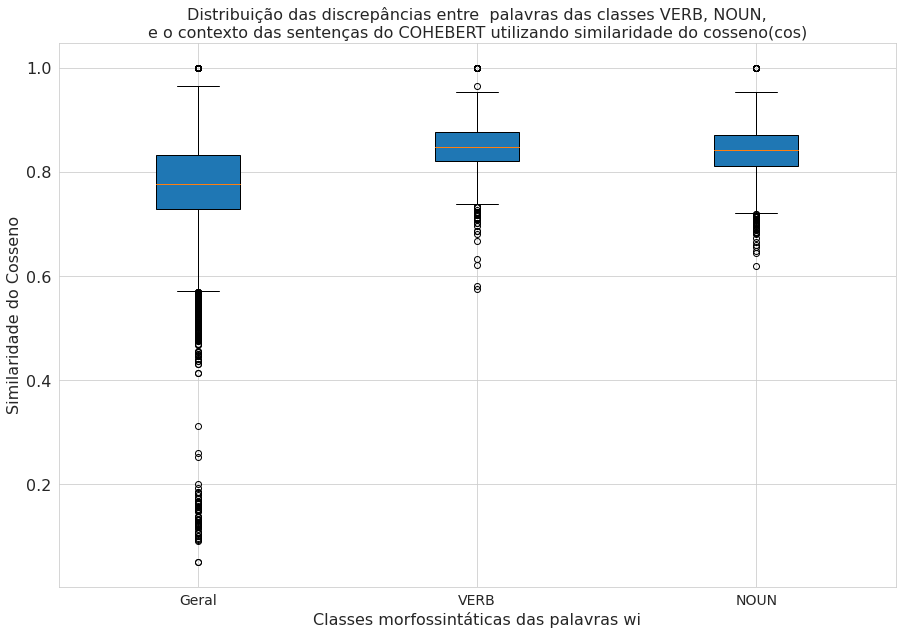

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count         19479.000000          2030.000000          4491.000000
mean             24.438343            21.578331            20.804033
std               4.718724             4.203370             3.443445
min               0.000000             0.000000             0.000000
25%              21.531361            19.433904            18.656158
50%              24.623173            21.602020            20.726318
75%              27.230864            23.814099            22.814786
max              46.118202            40.630005            38.187222

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


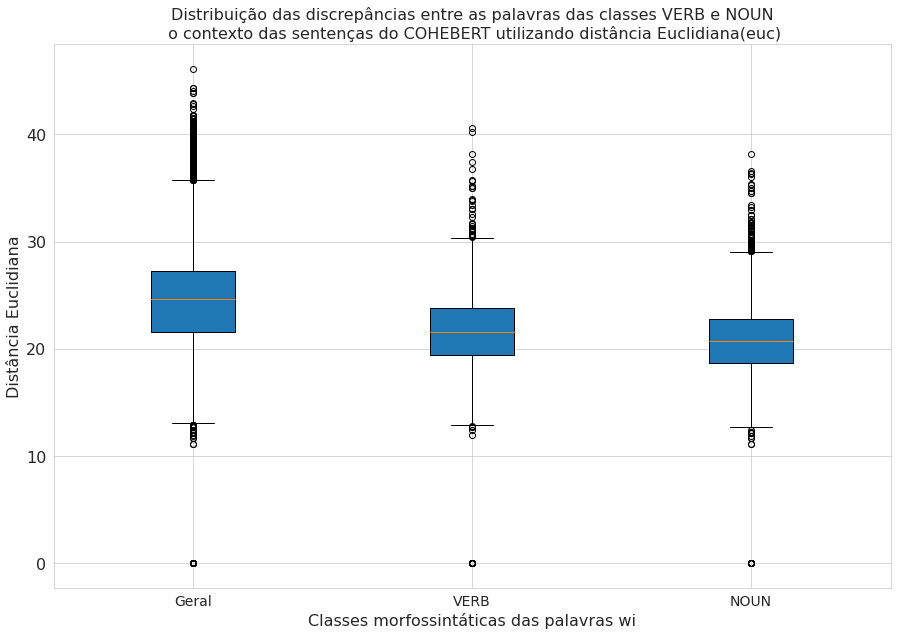

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count         19479.000000          2030.000000          4491.000000
mean           1177.544636          1033.255459           985.775226
std             228.282215           198.820514           159.129159
min               0.000000             0.000000             0.000000
25%            1031.365417           927.031311           887.111450
50%            1193.889282          1038.107544           983.997803
75%            1321.288879          1137.587097          1079.098145
max            2154.859375          2030.208618          1692.941406

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


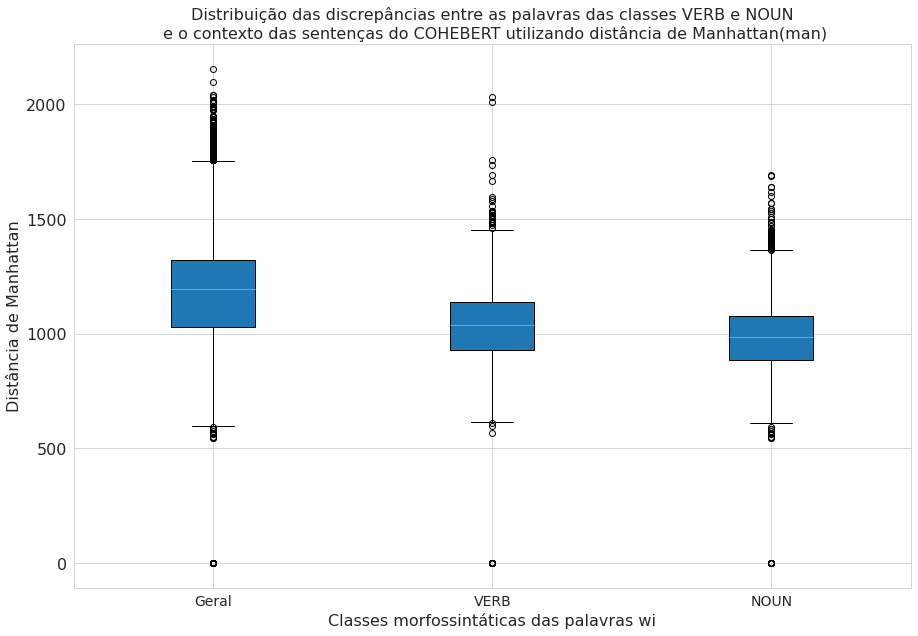

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                 
1                 0               0         0        Como  SCONJ   
1                 0               0         1  enfileirar   VERB   
1                 0               0         2   elementos   NOUN   
1                 0               0         3          em    ADP   
1                 0               0         4         uma    DET   

    cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                         
1          0.828282        21.519108      1075.545000           0.795338   
1          0.957184        10.615781       524.864750           0.923698   
1          0.803867        26.599089      1214.868700           0.868563   
1          0.871055        20.539904       985.528140           0.828741   
1          0.840564        20.068254       958.674800           0.787430   

    euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                     ...                                      
1           23.453634  ...       1157.058100         0.759586   
1           13.929335  ...       1131.780200         0.888775   
1           22.597618  ...       1028.900600         0.740469   
1           23.203224  ...       1111.173300         0.796027   
1           23.178740  ...       1096.644800         0.744569   

    euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                       
1         25.941952      1294.481201         0.680192        29.916761   
1         18.006964       972.863525         0.740781        27.314678   
1         30.121441      1415.033325         0.927326        17.372261   
1         25.312115      1248.880127         0.801384        24.997398   
1         26.130171      1257.120117         0.727427        27.010202   

    man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                              
1       1453.618900             0.733323            26.951654   
1       1333.597400             0.819909            22.602350   
1        782.108460             0.897772            20.224216   
1       1188.405400             0.829802            23.141649   
1       1257.071300             0.760827            24.886763   

    man_ctxverbnoun_max  
id                       
1           1323.588700  
1           1117.259800  
1            922.564500  
1           1105.196000  
1           1168.039700  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida cos_ctxall_mean  :  0.8090358675212904


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 elementos(NOUN)  24
4 em(ADP)  24
5 fila(NOUN)  20
6 pilha(NOUN)  20
7 e(CCONJ)  19
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida euc_ctxall_mean  :  22.545366594868323


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida man_ctxall_mean  :  1079.1845001382487


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:02:11 (h:mm:ss)
